**Jayson Salkey
ID: 17045589
Date: 17/03/2018**


# Imports and utility functions (do not modify!)

In [0]:
# Import useful libraries.
import matplotlib.pyplot as plt
import copy
import itertools
from tensorflow.examples.tutorials.mnist import input_data
import os
import numpy as np

np.random.seed(123)
%matplotlib inline

# Global variables.
log_period_samples = 10000

# Import dataset with one-hot encoding of the class labels.
def get_data():
  return input_data.read_data_sets("MNIST_data/", one_hot=True)

def plot_toleranceConverge(experiment_data):
  # Generate figure.
  # Plot all learning curves.
  for i, results in enumerate(experiment_data):
    for j, (setting, train_accuracy, test_accuracy, batch_losses, steps, weightConverge) in enumerate(results):
      fig = plt.figure(figsize=(18,12))
      st = fig.suptitle(
        "Iterations until Weight Matrix Convergence",
        fontsize="x-large")
      plt.bar(np.arange(len(weightConverge)), np.asarray(weightConverge), label='Optimiser: {}, Epochs: {}, Batch_size: {}.'.format(*setting))
      plt.xlabel('Weight Matrix Index')
      plt.ylabel('Iterations until within Tolerance')
      plt.yscale('log')
      plt.legend()
      # Prettify overall figure.
      plt.tight_layout()
      st.set_y(0.95)
      fig.subplots_adjust(top=0.91)
      plt.show()

def plot_step(experiment_data):
  # Generate figure.
  # Plot all learning curves.
  for i, results in enumerate(experiment_data):
    fig = plt.figure(figsize=(18,12))
    st = fig.suptitle(
      "Step sizes",
      fontsize="x-large")
    for j, (setting, train_accuracy, test_accuracy, batch_losses, steps, weightConverge) in enumerate(results):
      # Plot.
      xs = [x for x in range(1, len(steps))]
      plt.plot(xs, steps[:-1], label='Optimiser: {}, Epochs: {}, Batch_size: {}.'.format(*setting))
      plt.yscale('log')
      # Prettify individual plots.
      plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
      plt.xlabel('Mini-batches processed')
      plt.ylabel('step_size')
      #axes[j, i].set_title('Optimiser: {}, Epochs: {}, Batch_size: {}.'.format(*setting))
      plt.legend()
    # Prettify overall figure.
    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.91)
    plt.show()

def plot_loss(experiment_data):
  # Plot all learning curves.
  for i, results in enumerate(experiment_data):
      # Generate figure.
    fig = plt.figure(figsize=(18,12))
    st = fig.suptitle(
        "Loss Curves",
      fontsize="x-large")
    for j, (setting, train_accuracy, test_accuracy, batch_losses, step_sizes, weightConverge) in enumerate(results):
      # Plot.
      xs = [x for x in range(1, len(batch_losses))]
      plt.plot(xs, batch_losses[:-1], label='Optimiser: {}, Epochs: {}, Batch_size: {}.'.format(*setting))
      plt.yscale('log')
      # Prettify individual plots.
      plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
      plt.xlabel('Mini-batches processed')
      plt.ylabel('Cross Entropy')
      #axes[j, i].set_title('Optimiser: {}, Epochs: {}, Batch_size: {}.'.format(*setting))
      plt.legend()
    # Prettify overall figure.
    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.91)
    plt.show()
  
  
# Plot learning curves of experiments
def plot_learning_curves(experiment_data):
  # Generate figure.
  # Plot all learning curves.
  for i, results in enumerate(experiment_data):
    fig = plt.figure(figsize=(18,12))
    st = fig.suptitle(
      "Training Accuracy",
      fontsize="x-large")
    plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'rgbcmykrgbcmyk') +"
                                    "cycler('marker', ['o', '+', 'x', 's', 'p', 'd', '|', '|', 'd','p','s','x','+','o'])")
    for j, (setting, train_accuracy, test_accuracy, batch_losses, step_sizes, weightConverge) in enumerate(results):
      # Plot.
      xs = [x for x in range(1, len(train_accuracy)+1)]
      plt.plot(xs, train_accuracy, label='Optimiser: {}, Epochs: {}, Batch_size: {}.'.format(*setting))
      # Prettify individual plots.
      plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
      plt.xlabel('Number of samples processed')
      plt.ylabel('Accuracy')
      #axes[j, i].set_title('Optimiser: {}, Epochs: {}, Batch_size: {}.'.format(*setting))
      plt.legend()
    # Prettify overall figure.
    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.91)
    plt.show()

# Generate summary table of results.
def plot_summary_table(experiment_data):
  # Fill Data.
  cell_text = []
  rows = []
  columns = ['Setting 1', 'Setting 2', 'Setting 3']
  for i, results in enumerate(experiment_data):
    rows.append('Model {}'.format(i + 1))
    cell_text.append([])
    for j, (setting, train_accuracy, test_accuracy) in enumerate(results):
      cell_text[i].append(test_accuracy[-1])
  # Generate Table.
  fig=plt.figure(frameon=False)
  ax = plt.gca()
  the_table = ax.table(
      cellText=cell_text,
      rowLabels=rows,
      colLabels=columns,
      loc='center')
  the_table.scale(1, 4)
  # Prettify.
  ax.patch.set_facecolor('None')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

# Neural Network Framework

In [0]:
'''
Salkey, Jayson
20/03/2018
'''


tol_sgd = 1.e-14
tol_lbfgs = 1.e-14
tol_ncg = 1.e-14
ogDelta = 1.


'''
Definition for Trust Region
'''
def trustRegion(ann, layerIdx, truth, layerDeriv, inputData, p, delta, eta):
  h = 10.e-8
  ogShape = p.shape
  
  mk0 = ann.xEnt(layerIdx, truth, 0, 0, inputData)
   
  dW = layerDeriv.copy()
  dW = dW.reshape((-1,1))
  pT = p.copy()
  pT = pT.reshape((-1,1))
  
  
  t_ann = copy.deepcopy(ann)
  t_ann.ann_layers[layerIdx].weightMatrix += h*p
  t_ann.backprop(truth, t_ann.forward(inputData), inputData, False)
  nGrad = (t_ann.ann_layers[layerIdx+1].deltaMatrix.dot(t_ann.ann_layers[layerIdx].outputMatrix)).T
  nGrad = nGrad.reshape((-1,1))
  
  d2Wp = (nGrad - dW)/(h)
   
  
  mkpk = mk0 + np.dot(dW.T, pT) + 1/2. * np.dot(pT.T, d2Wp)
  
  #print (mk0 - ann.xEnt(layerIdx, truth, 1., p, inputData))
  #print (mk0 - mkpk)
  
  rho = (mk0 - ann.xEnt(layerIdx, truth, 1., p, inputData))/(mk0 - mkpk)
  
  if rho < .25:
    delta = .25 * delta
  else:
    if rho > .75 and np.abs(np.linalg.norm(pT) - delta) <= 1.e-6:
      delta = min(2*delta, ogDelta)
  
  #print rho
  if rho > eta:
    return delta, True
  return delta, False

'''
Definition for Backtracking Line Search
'''
def backtrackingLineSearch(ann, layerIdx, truth, layerDeriv, inputData, p, a0=1., c1=1.e-4, rho=0.8):
  alpha = a0
  alphas = [alpha]
  
  lD = layerDeriv.reshape((1,-1))
  pT = p.reshape((-1,1))
  while ann.xEnt(layerIdx, truth, alpha, p, inputData) > ann.xEnt(layerIdx, truth, 0, 0, inputData) + c1*alpha*np.dot(lD,pT):
    alpha *= rho
    alphas.append(alpha)
  return alpha,alphas

'''
Definition for ReLu activation function
'''
def relu(x, derivative=False):
  tx = np.copy(x)
  if derivative:
    tx[tx > 0] = 1.
    tx[tx <= 0] = 0.
    return tx
  tx[tx <= 0] = 0.
  return tx

def sigmoid(x, derivative=False):
  t = x.copy()
  if not derivative:
    t[t>=0.] = 1./(1.+np.exp(-t[t>=0.]))
    t[t<0.] = np.exp(t[t<0.])/(1.+np.exp(t[t<0.]))
    return t
  return sigmoid(t,derivative=False)*(1-sigmoid(t,derivative=False))  

'''
Definition for the softmax activation function.
Used for the output layer.
'''
def softmax(x):
  t = x.max(axis=1).reshape(((x.max(axis=1)).shape[0],1))
  q = np.sum(np.exp(x-t),axis=1)
  return np.exp(x-t)/(q.reshape(q.shape[0],1))

In [0]:


'''
Class definition for each Layer of the neural network.
'''
class Layer:
  def __init__(self, layerSize, batchSize, bias=0., activation=sigmoid,
               inputLayer=False, outputLayer=False):
    self.inputLayer = inputLayer # signifies if this is the input layer
    self.outputLayer = outputLayer # signifies if this is the output layer
    self.activation = activation # activiation function specified for this layer
    self.bias = bias # bias associated with this layer
    self.layerSize = layerSize # signifies the number of nodes for this layer
    self.weightMatrix = np.random.normal(size=layerSize).astype(np.float64) if outputLayer == False else None # the outgoing weightMatrix for this layer
    self.inputMatrix = np.zeros((batchSize, layerSize[0])) if inputLayer == False else None # the inputMatrix for this layer
    self.deltaMatrix = np.zeros((batchSize, layerSize[0])) if inputLayer == False else None # the error deltaMatrix for each layer
    self.activationDeriv = np.zeros((layerSize[0], batchSize)) if inputLayer == False and outputLayer == False else None # holds the activationDerivatives for each layer
    self.outputMatrix = np.zeros((batchSize, layerSize[0])) # the outputMatrix for each specified layer
    self.batchSize = batchSize
    
  ''' Forward Pass for each layer '''
  def forward(self):
    if self.inputLayer: # We do not place an activation function on the inputs
      return self.outputMatrix.dot(self.weightMatrix)
    self.outputMatrix = self.activation(self.inputMatrix) # Otherwise we utilize the activation function
    if self.outputLayer: # If this is the outputMatrix, we have no weightMatrix to multiply on so we simply return this result
      return self.outputMatrix
    self.activationDeriv = self.activation(self.inputMatrix, derivative=True).T # Calculate the activation derivatives for the given layer for backprop
    self.outputMatrix = self.outputMatrix#np.append(self.outputMatrix, self.bias * np.ones((self.outputMatrix.shape[0], 1)), axis=1) # We append our predefined bias for the layers and pass
    return self.outputMatrix.dot(self.weightMatrix) # we propogate by multiplying with our weights

'''
Class definition for the neural network.
'''

class ANN(object):
  def __init__(self, batchSize, layers, layersBias=0., step=backtrackingLineSearch):
    self.depth = len(layers) # Number of layers
    self.batchSize = batchSize # Batch size
    self.ann_layers = list() # Complete list of Layers along with their configurations
    self.layersBias = layersBias # Bias for each layer
    self.layers = layers
    self.step = step
    self.stepsUntilWeightMatrixInTolerance = [-1.]*len(self.layers)
    self.layerIterCount = [0.]*len(self.layers)
    
    '''Step to initialise each layer'''
    for idx in xrange(self.depth):
      if idx == 0: # Initialise the input layer with its corresponding input and output size matrices, batchsize, bias, and input setting
          self.ann_layers.append(Layer([layers[0],layers[1]],batchSize,bias=self.layersBias,inputLayer=True))
      elif idx == len(layers)-1: # Initialise the output layer with a softmax
          self.ann_layers.append(Layer([layers[-1],None],batchSize,bias=self.layersBias,activation=softmax,outputLayer=True))
      else: # Initialise the input layer with its corresponding input and output size matrices, batchsize, bias, and output setting
          self.ann_layers.append(Layer([layers[idx], layers[idx+1]], batchSize, bias=self.layersBias))
  
  '''
  Forward pass
  - Refer to the Layer definition for more detail on this function
  '''
  def forward(self, inputData):
    '''Begin the forward pass by letting the input layers output be the data with bias'''
    self.ann_layers[0].outputMatrix = inputData#np.append(inputData, self.layersBias * np.ones((inputData.shape[0], 1)), axis=1)
    '''Forward on each layer subsequently and return the final layers output matrix'''
    for idx in xrange(self.depth-1):
      self.ann_layers[idx+1].inputMatrix = self.ann_layers[idx].forward()
    return self.ann_layers[-1].forward()
  
  def xEnt(self, layerIdx, truth, alpha, p, inputData):
    og_matrix = self.ann_layers[layerIdx].weightMatrix.copy()
    self.ann_layers[layerIdx].weightMatrix += alpha*p
    prediction = self.forward(inputData).astype(np.float64)
    truth = truth.astype(np.float64)
    self.ann_layers[layerIdx].weightMatrix = og_matrix
    prediction[prediction == 0.] = np.finfo(np.float64).tiny
    return np.mean(-np.sum(truth*np.log(prediction),axis=1))


In [0]:
#@title
class ANN_GRADIENT_DESCENT(ANN):
  def __init__(self, *args, **kwargs):
    super(ANN_GRADIENT_DESCENT, self).__init__(*args, **kwargs)
  
  def gradDescent(self, dW):
    return -dW
  
  '''
  Backpropagation
   - via gradient descent
  '''
  def backprop(self, truth, prediction, inputData, update=True):
    if not(-1. in self.stepsUntilWeightMatrixInTolerance[:-1]):
      return 'converged'
    
    self.ann_layers[-1].deltaMatrix = (prediction - truth).T # the error vector corresponding to the output and truth values
    for idx in xrange(self.depth-2,0,-1): 
        # Let the delta matrix of each other of the layers be the weight matrix multiplied by the next layers delta matrix and this layers activation derivatives
        # Essentially we are propagating an error signal corresponding to a derivative back through the layers, like chain rule.
      self.ann_layers[idx].deltaMatrix = (self.ann_layers[idx].weightMatrix).dot(self.ann_layers[idx+1].deltaMatrix) * self.ann_layers[idx].activationDeriv
    if not update:
      return
    for idx in xrange(0, self.depth-1): # Here we update the weights and bias
      
      
      pk = self.gradDescent((self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T) 
      ak,aks = self.step(self, idx, truth, (self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T, inputData, pk)
      
      #print np.linalg.norm((ak*pk).reshape((-1,1)))/np.linalg.norm((self.ann_layers[idx].weightMatrix + ak * pk).reshape((-1,1))) 
      if np.linalg.norm((ak*pk).reshape((-1,1)))/np.linalg.norm((self.ann_layers[idx].weightMatrix).reshape((-1,1))) < tol_sgd:
        if self.stepsUntilWeightMatrixInTolerance[idx] == -1.:
          print 'Weight Matrix ' + str(idx) + ' has converged.'
          self.stepsUntilWeightMatrixInTolerance[idx] = self.layerIterCount[idx]
      else:  
        self.ann_layers[idx].weightMatrix += ak * pk
        self.layerIterCount[idx] += 1.
    return ak

In [0]:
#@title
class ANN_LBFGS(ANN):
  def __init__(self, m, *args, **kwargs):
    super(ANN_LBFGS, self).__init__(*args, **kwargs)
    self.M = m
    self.hist = {}
    
  def lBFGS(self, dW, W, layerIdx):
    if not (layerIdx in self.hist):
      self.hist[layerIdx] = {'prevGradients':[], 'prevIterates':[]}

    ogShape = dW.shape
    dW = dW.reshape((-1,1))
    W = W.reshape((-1,1))

    q = dW
    a = []

    if len(self.hist[layerIdx]['prevIterates']) != 0:
      for idr, (g,x) in enumerate(zip(self.hist[layerIdx]['prevGradients'],self.hist[layerIdx]['prevIterates'])):
        a.append(1./(np.matmul(g.T,x)) * np.matmul(x.T, q))
        q = q - a[-1]*g

      gamma = np.matmul(self.hist[layerIdx]['prevIterates'][0].T,self.hist[layerIdx]['prevGradients'][0])/np.matmul(self.hist[layerIdx]['prevGradients'][0].T,self.hist[layerIdx]['prevGradients'][0])
      r = np.matmul(gamma * np.eye(q.shape[0]), q)

      for idr in xrange(len(self.hist[layerIdx]['prevGradients'])-1,-1,-1):
        beta = 1./(np.matmul(self.hist[layerIdx]['prevGradients'][idr].T,self.hist[layerIdx]['prevIterates'][idr])) * np.matmul(self.hist[layerIdx]['prevGradients'][idr].T,r)
        r = r + self.hist[layerIdx]['prevIterates'][idr]*(a[idr] - beta)

      p_k = -r;
    else:
      p_k = -dW;

    return p_k.reshape(ogShape)
  
  def updateHist(self, oG, nI, oI, inputData, truth, layerIdx):
    
    t_ann = copy.deepcopy(self)
    t_ann.ann_layers[layerIdx].weightMatrix = nI
    t_ann.backprop(truth, t_ann.forward(inputData), inputData, False)
    nG = (t_ann.ann_layers[layerIdx+1].deltaMatrix.dot(t_ann.ann_layers[layerIdx].outputMatrix)).T
      
    nG = nG.reshape((-1,1))
    oG = oG.reshape((-1,1))
    nI = nI.reshape((-1,1))
    oI = oI.reshape((-1,1))

    y_k = nG - oG
    s_k = nI - oI
    if np.sum(y_k) != 0. and np.sum(s_k) != 0.:
      self.hist[layerIdx]['prevGradients'].insert(0, y_k)
      self.hist[layerIdx]['prevIterates'].insert(0, s_k)
      if len(self.hist[layerIdx]['prevIterates']) >= self.M:
        #print 'Deleting...'
        del self.hist[layerIdx]['prevIterates'][-1]
        del self.hist[layerIdx]['prevGradients'][-1]
    return
  
  '''
  Backpropagation
   - via lbfgs
  '''
  def backprop(self, truth, prediction, inputData, update=True):
    if not(-1. in self.stepsUntilWeightMatrixInTolerance[:-1]):
      return 'converged'
    
    self.ann_layers[-1].deltaMatrix = (prediction - truth).T # the error vector corresponding to the output and truth values
    for idx in xrange(self.depth-2,0,-1):
        # Let the delta matrix of each other of the layers be the weight matrix multiplied by the next layers delta matrix and this layers activation derivatives
        # Essentially we are propagating an error signal corresponding to a derivative back through the layers, like chain rule.
      self.ann_layers[idx].deltaMatrix = (self.ann_layers[idx].weightMatrix).dot(self.ann_layers[idx+1].deltaMatrix) * self.ann_layers[idx].activationDeriv
    
    if not update:
      return
    
    for idx in xrange(0, self.depth-1): # Here we update the weights and bias
      
      pk = self.lBFGS((self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T, self.ann_layers[idx].weightMatrix, idx) 
      ak,aks = self.step(self, idx, truth, (self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T, inputData, pk)
      
      #print np.linalg.norm((ak*pk).reshape((-1,1)))/np.linalg.norm((self.ann_layers[idx].weightMatrix).reshape((-1,1)))
      if np.linalg.norm((ak*pk).reshape((-1,1)))/np.linalg.norm((self.ann_layers[idx].weightMatrix + ak * pk).reshape((-1,1))) < tol_lbfgs:
        if self.stepsUntilWeightMatrixInTolerance[idx] == -1.:
          self.stepsUntilWeightMatrixInTolerance[idx] = self.layerIterCount[idx]
      else:  
        self.updateHist((self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T, self.ann_layers[idx].weightMatrix + ak*pk, self.ann_layers[idx].weightMatrix, inputData, truth, idx)
        self.ann_layers[idx].weightMatrix += ak * pk
        self.layerIterCount[idx] += 1.
    return ak
      

In [0]:
#@title
class ANN_LINEAR_NEWTON_CG(ANN):
  def __init__(self, maxIterNCG, *args, **kwargs):
    super(ANN_LINEAR_NEWTON_CG, self).__init__(*args, **kwargs)
    self.MAXITER_NEWTONCG = maxIterNCG
    self.NCG_Iterations = []
    for x in xrange(self.depth):
      self.NCG_Iterations.append([])
    
  def newtonConjugateGradient(self, cGrad, layerIdx, inputData, truth):    
    ogShape = cGrad.shape
    cGrad = cGrad.reshape((-1,1))
    
    eps = min(0.5, np.sqrt(np.linalg.norm(cGrad))) * np.linalg.norm(cGrad)
    z = 0.
    r = cGrad
    d = -r
    h = 10.e-8
    maxIter = self.MAXITER_NEWTONCG

    for j in xrange(0,maxIter):
      
      t_ann = copy.deepcopy(self)
      t_ann.ann_layers[layerIdx].weightMatrix += h*d.reshape(ogShape)
      t_ann.backprop(truth, t_ann.forward(inputData), inputData, False)
      nGrad = (t_ann.ann_layers[layerIdx+1].deltaMatrix.dot(t_ann.ann_layers[layerIdx].outputMatrix)).T
      nGrad = nGrad.reshape((-1,1))
      
      Bd = (nGrad - cGrad)/(h)
      if np.dot(d.T,Bd) <= 0.:
        self.NCG_Iterations[layerIdx].append(j)
        if j == 0:
          return -cGrad.reshape(ogShape)
        else:
          return z.reshape(ogShape)
      a = np.dot(r.T,r)/np.dot(d.T,Bd)
      z += a*d
      old_r = r#.copy()
      r += a*Bd
      if np.linalg.norm(r) < eps:
        self.NCG_Iterations[layerIdx].append(j)
        return z.reshape(ogShape)
      beta = np.dot(r.T,r)/np.dot(old_r.T,old_r)
      d = -r + beta*d
      
    print 'nothing'
  
  '''
  Backpropagation
   - via ncg
  '''
  def backprop(self, truth, prediction, inputData, update=True):
    if not(-1. in self.stepsUntilWeightMatrixInTolerance[:-1]):
      return 'converged'
    
    self.ann_layers[-1].deltaMatrix = (prediction - truth).T # the error vector corresponding to the output and truth values
    for idx in xrange(self.depth-2,0,-1): 
        # Let the delta matrix of each other of the layers be the weight matrix multiplied by the next layers delta matrix and this layers activation derivatives
        # Essentially we are propagating an error signal corresponding to a derivative back through the layers, like chain rule.
      self.ann_layers[idx].deltaMatrix = (self.ann_layers[idx].weightMatrix).dot(self.ann_layers[idx+1].deltaMatrix) * self.ann_layers[idx].activationDeriv
    if not update:
      return
    for idx in xrange(0, self.depth-1): # Here we update the weights and bias  
      pk = self.newtonConjugateGradient((self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T , idx, inputData, truth) 
      #print pk
      ak,aks = self.step(self, idx, truth, (self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T, inputData, pk)
      
      if np.linalg.norm((ak*pk).reshape((-1,1)))/np.linalg.norm((self.ann_layers[idx].weightMatrix).reshape((-1,1))) < tol_ncg:
        if self.stepsUntilWeightMatrixInTolerance[idx] == -1.:
          self.stepsUntilWeightMatrixInTolerance[idx] = self.layerIterCount[idx]
      else:  
        self.ann_layers[idx].weightMatrix += ak * pk
        self.layerIterCount[idx] += 1.
    return ak

In [0]:
#@title
class ANN_NEWTON_CG_STEIHAUG(ANN):
  def __init__(self, maxIterNCG, tolerance, eta, delta, *args, **kwargs):
    super(ANN_NEWTON_CG_STEIHAUG, self).__init__(*args, **kwargs)
    self.MAXITER_NEWTONCG = maxIterNCG
    self.NCG_Iterations = []
    self.toler = tolerance
    self.eta = eta
    self.layerDeltas = [delta]*self.depth
    
    for x in xrange(self.depth):
      self.NCG_Iterations.append([])
    
  def newtonConjugateGradient(self, delta, cGrad, layerIdx, inputData, truth):    
    ogShape = cGrad.shape
    cGrad = cGrad.reshape((-1,1))
    
    z = np.zeros(cGrad.shape)
    r = cGrad
    d = -r
    h = 10.e-8
    maxIter = self.MAXITER_NEWTONCG
    
    if np.linalg.norm(r) < self.toler:
      return z.reshape(ogShape)

    for j in xrange(0,maxIter):
      
      t_ann = copy.deepcopy(self)
      t_ann.ann_layers[layerIdx].weightMatrix += h*d.reshape(ogShape)
      t_ann.backprop(truth, t_ann.forward(inputData), inputData, False)
      nGrad = (t_ann.ann_layers[layerIdx+1].deltaMatrix.dot(t_ann.ann_layers[layerIdx].outputMatrix)).T
      nGrad = nGrad.reshape((-1,1))
      
      Bd = (nGrad - cGrad)/(h)
      if np.dot(d.T,Bd) <= 0.:
        self.NCG_Iterations[layerIdx].append(j)
        
        c1 = np.dot(d.T,d)
        c2 = 2. * np.dot(d.T,z)
        c3 = np.dot(z.T,z) - delta**2.
        
        tau = (-c2 + np.sqrt(c2*c2 - 4*c1*c3))/(2*c1)
        return (z + tau*d).reshape(ogShape)
      
      a = np.dot(r.T,r)/np.dot(d.T,Bd)
      old_z = z.copy()
      z += a*d
      if np.linalg.norm(z) >= delta:
        #print delta
        self.NCG_Iterations[layerIdx].append(j)
        c1 = np.dot(d.T,d)
        c2 = 2. * np.dot(d.T, old_z)
        c3 = np.dot(old_z.T, old_z) - delta**2.
        arr = np.asarray([c1,c2,c3]).flatten()
        sol = np.roots(arr)
        tau = sol[np.imag(sol) == 0.]
        tau = tau[tau >= 0.]
        #print tau
        return (old_z + tau[0]*d).reshape(ogShape) if len(tau) > 0 else old_z.reshape(ogShape)
        
      old_r = r.copy()
      r += a*Bd
      if np.linalg.norm(r) < self.toler:
        self.NCG_Iterations[layerIdx].append(j)
        return z.reshape(ogShape)
      beta = np.dot(r.T,r)/np.dot(old_r.T,old_r)
      d = -r + beta*d
  
  '''
  Backpropagation
   - via ncg-steihaug
  '''
  def backprop(self, truth, prediction, inputData, update=True):
    if not(-1. in self.stepsUntilWeightMatrixInTolerance[:-1]):
      return 'converged'
    
    self.ann_layers[-1].deltaMatrix = (prediction - truth).T # the error vector corresponding to the output and truth values
    for idx in xrange(self.depth-2,0,-1): 
        # Let the delta matrix of each other of the layers be the weight matrix multiplied by the next layers delta matrix and this layers activation derivatives
        # Essentially we are propagating an error signal corresponding to a derivative back through the layers, like chain rule.
      self.ann_layers[idx].deltaMatrix = (self.ann_layers[idx].weightMatrix).dot(self.ann_layers[idx+1].deltaMatrix) * self.ann_layers[idx].activationDeriv
    if not update:
      return
    for idx in xrange(0, self.depth-1): # Here we update the weights and bias  
      
      pk = self.newtonConjugateGradient(self.layerDeltas[idx], (self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T , idx, inputData, truth) 
      
      
      self.layerDeltas[idx],reductRatio = self.step(self, idx, truth, (self.ann_layers[idx+1].deltaMatrix.dot(self.ann_layers[idx].outputMatrix)).T, inputData, pk, self.layerDeltas[idx], self.eta)
      #print reductRatio
      
      
      
      if np.linalg.norm((pk).reshape((-1,1)))/np.linalg.norm((self.ann_layers[idx].weightMatrix).reshape((-1,1))) < 1e-32:
        if self.stepsUntilWeightMatrixInTolerance[idx] == -1.:
          self.stepsUntilWeightMatrixInTolerance[idx] = self.layerIterCount[idx]
      else:
        if reductRatio == True:
          self.ann_layers[idx].weightMatrix += pk
          self.layerIterCount[idx] += 1.
    
    return np.linalg.norm(pk.reshape((-1,1)))

In [0]:
# CAREFUL: Running this CL resets the experiments_task1 dictionary where results should be stored.
# Store results of runs with different configurations in a dictionary.
# Use a tuple (num_epochs, learning_rate) as keys, and a tuple (training_accuracy, testing_accuracy)

num_epochs = 1

one_layerModels = [ANN_GRADIENT_DESCENT(batchSize=100,
                     layers=[784,10]),
                   ANN_LBFGS(5,
                    batchSize=100,
                    layers=[784,10]),
                   ANN_LINEAR_NEWTON_CG(1000000,
                               batchSize=100,
                               layers=[784,10]),
                  ANN_NEWTON_CG_STEIHAUG(1000000,1.e-5,0.0005,1.,
                               batchSize=100,
                               layers=[784,10],step=trustRegion)]


two_layerModels = [ANN_GRADIENT_DESCENT(batchSize=100,
                    layers=[784,20,10]),
                  ANN_LBFGS(5,
                    batchSize=100,
                    layers=[784,20,10]),
                  ANN_LINEAR_NEWTON_CG(1000000,
                               batchSize=100,
                               layers=[784,20,10]),
                  ANN_NEWTON_CG_STEIHAUG(1000000,1.e-5,0.0005,1.,
                               batchSize=100,
                               layers=[784,20,10],step=trustRegion)]

three_layerModels = [ANN_GRADIENT_DESCENT(batchSize=100,
                      layers=[784,20,20,10]),
                    ANN_LBFGS(5,
                      batchSize=100,
                      layers=[784,20,20,10]),
                    ANN_LINEAR_NEWTON_CG(1000000,
                                 batchSize=100,
                                 layers=[784,20,20,10])]

four_layerModels = [ANN_GRADIENT_DESCENT(batchSize=100,
                      layers=[784,20,20,20,10]),
                    ANN_LBFGS(5,
                      batchSize=100,
                      layers=[784,20,20,20,10]),
                    ANN_LINEAR_NEWTON_CG(1000000,
                                 batchSize=100,
                                 layers=[784,20,20,20,10])]

five_layerModels = [ANN_GRADIENT_DESCENT(batchSize=100,
                      layers=[784,20,20,20,20,10]),
                    ANN_LBFGS(5,
                      batchSize=100,
                      layers=[784,20,20,20,20,10]),
                    ANN_LINEAR_NEWTON_CG(1000000,
                                 batchSize=100,
                                 layers=[784,20,20,20,20,10])]

experiments = [one_layerModels, two_layerModels, three_layerModels, four_layerModels, five_layerModels]
#experiments = [[ANN_LINEAR_NEWTON_CG(1000000,
 #                              batchSize=100,
 #                              layers=[784,10])]]
experiment_results = [[], [], [], [], []]

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LINEAR_NEWTON

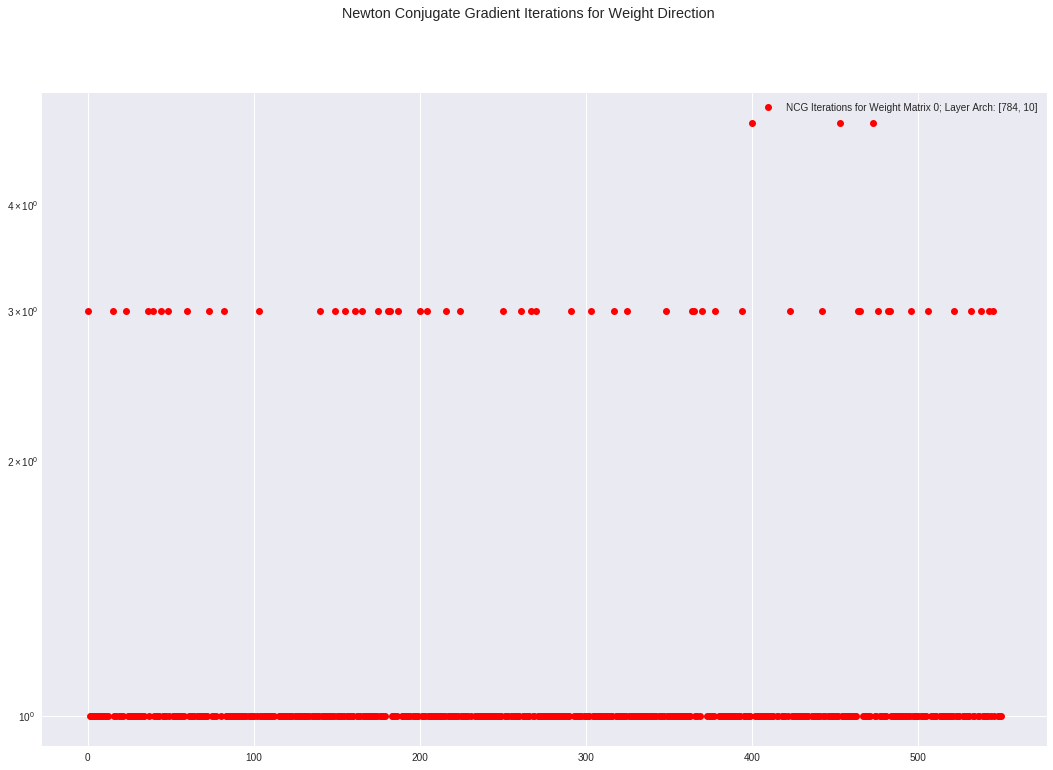

ANN_NEWTON_CG_STEIHAUG
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in divide


Iteration: 100
Iteration: 200
Iteration: 300


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in divide


Iteration: 400
Iteration: 500


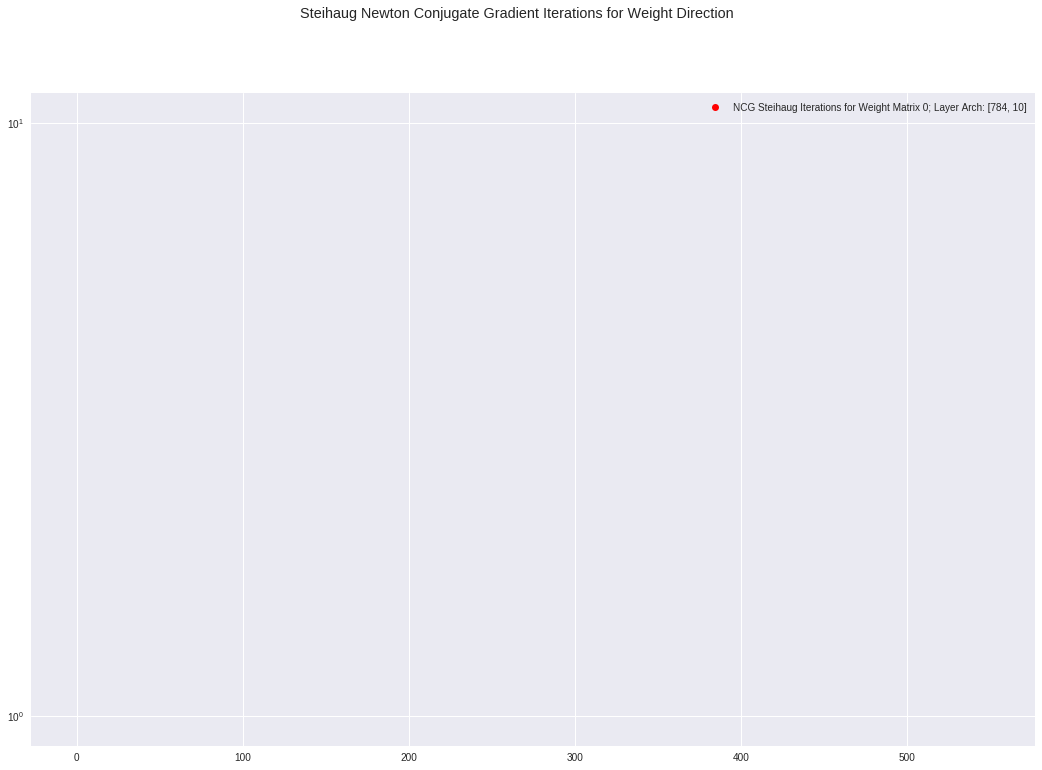

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LINEAR_NEWTON

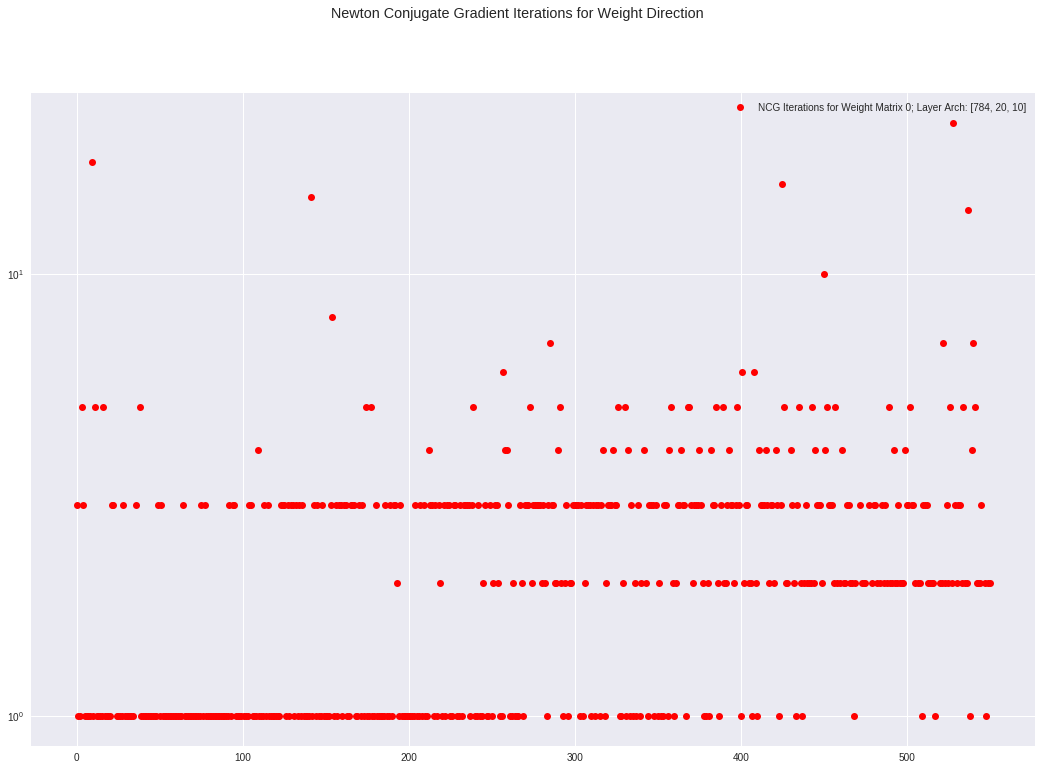

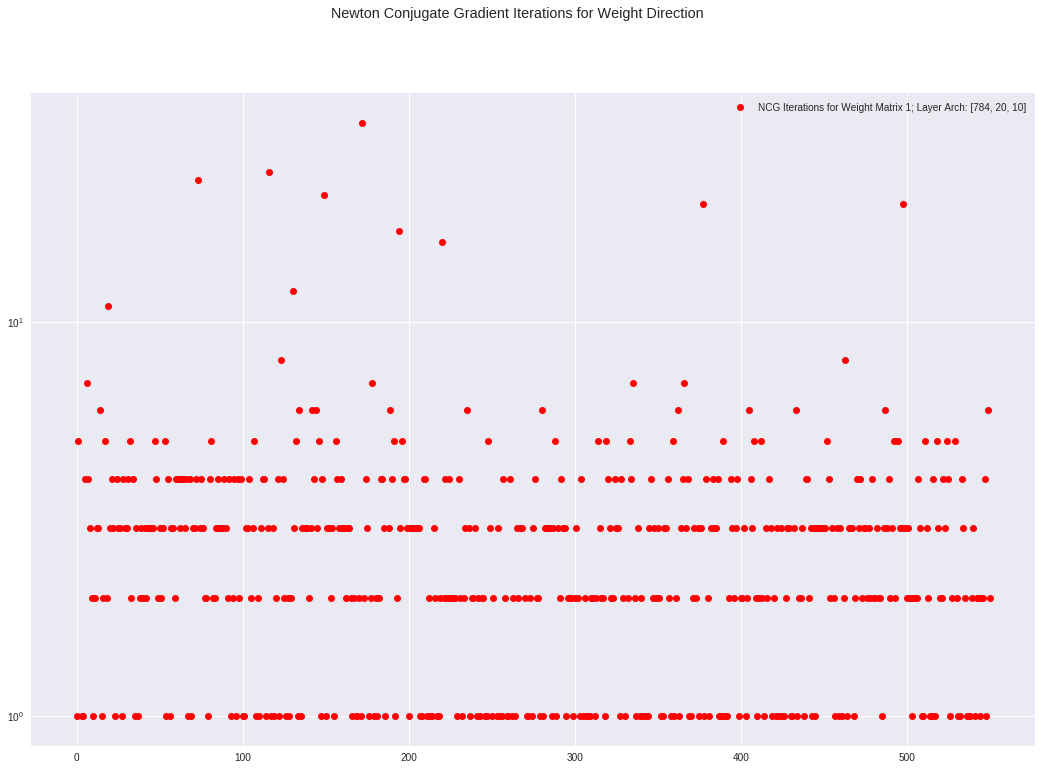

ANN_NEWTON_CG_STEIHAUG
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


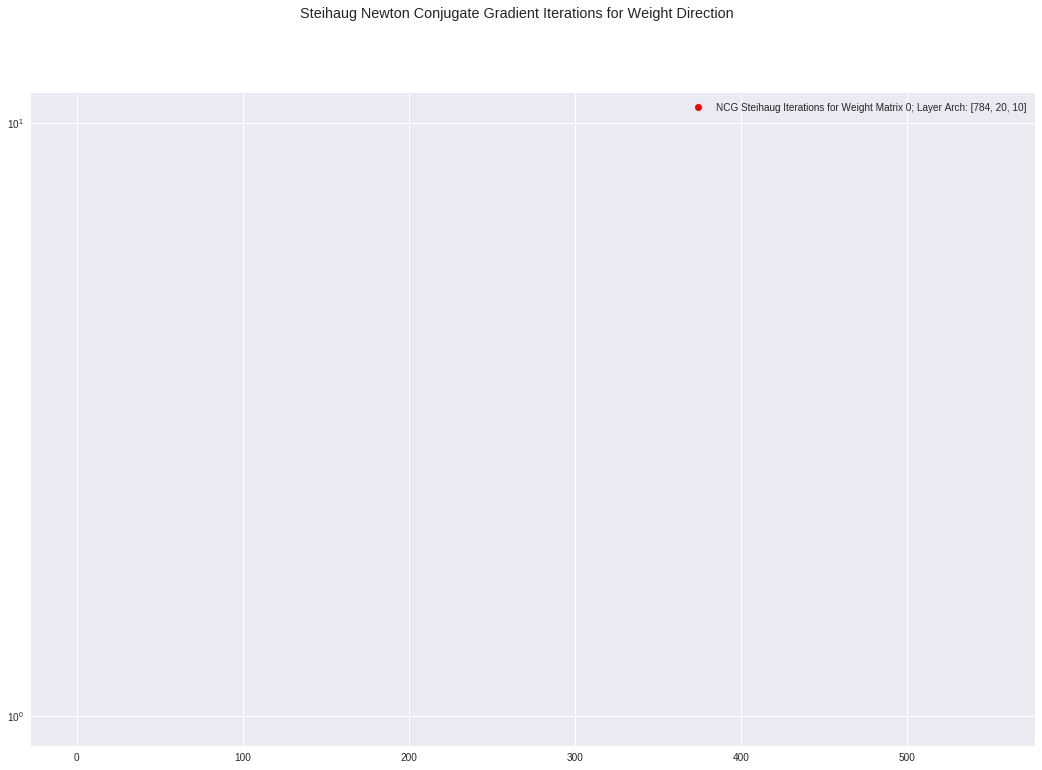

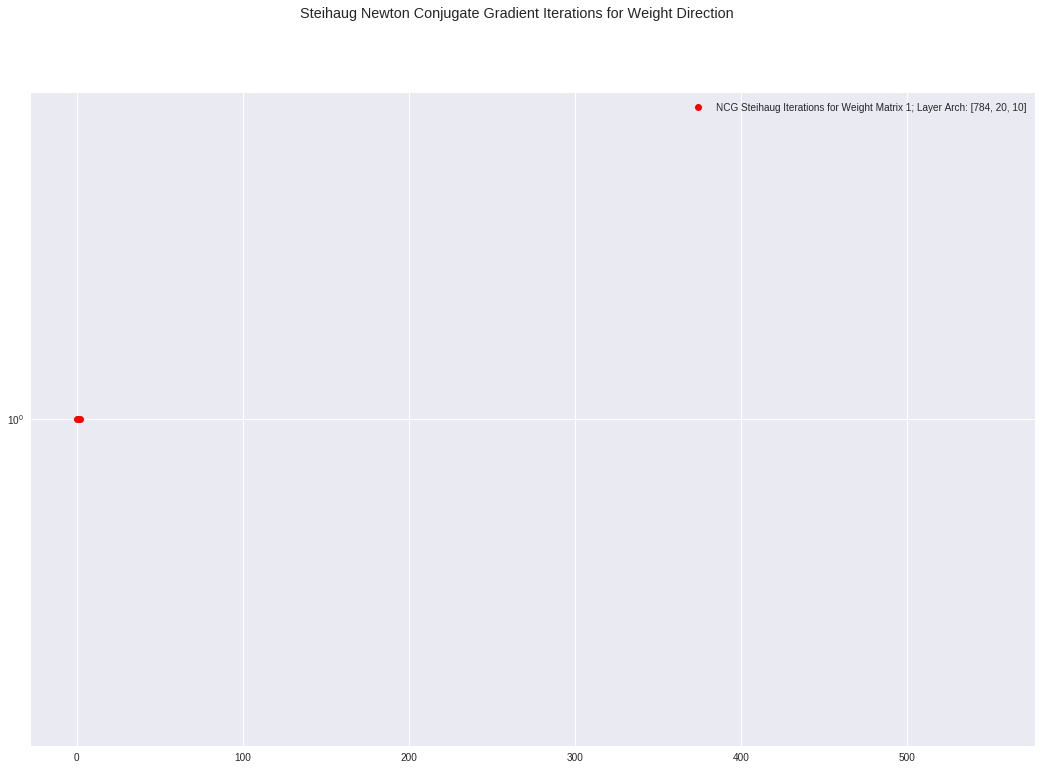

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Weight Matrix 2 has converged.
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
I

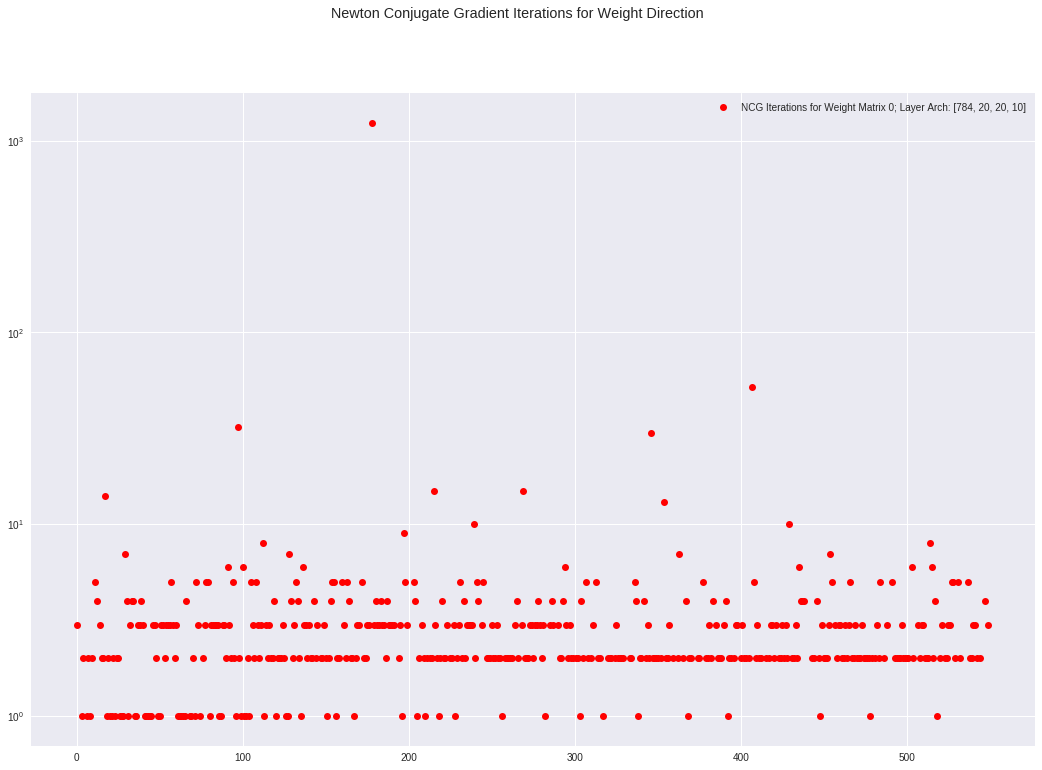

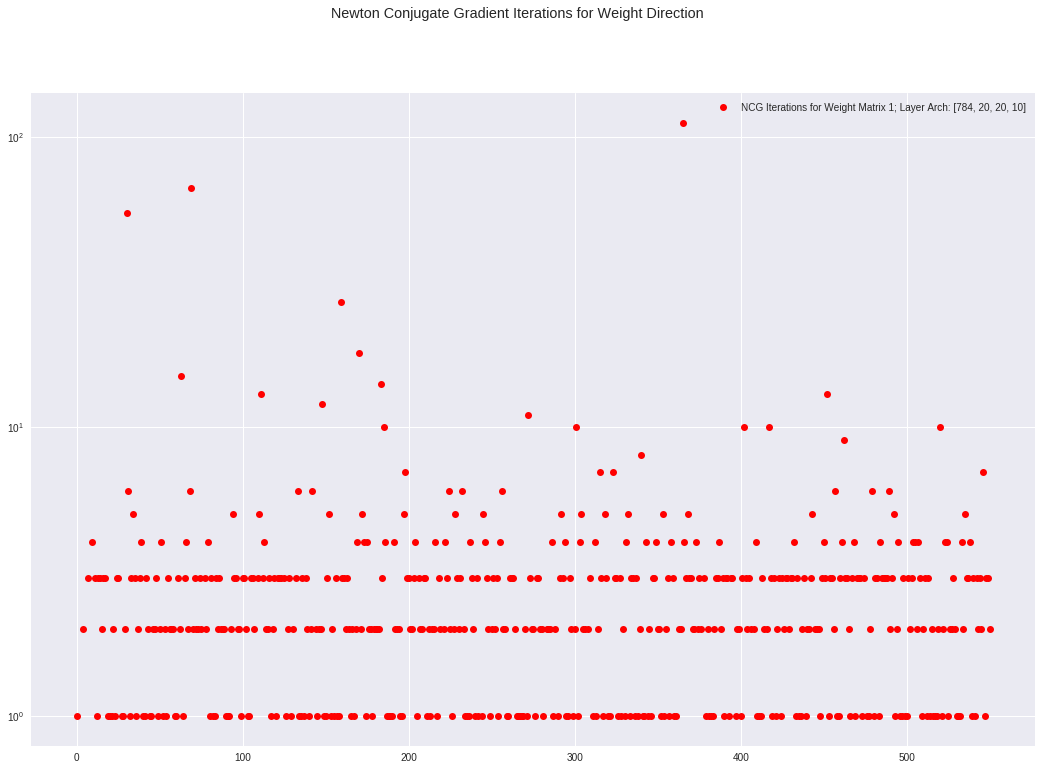

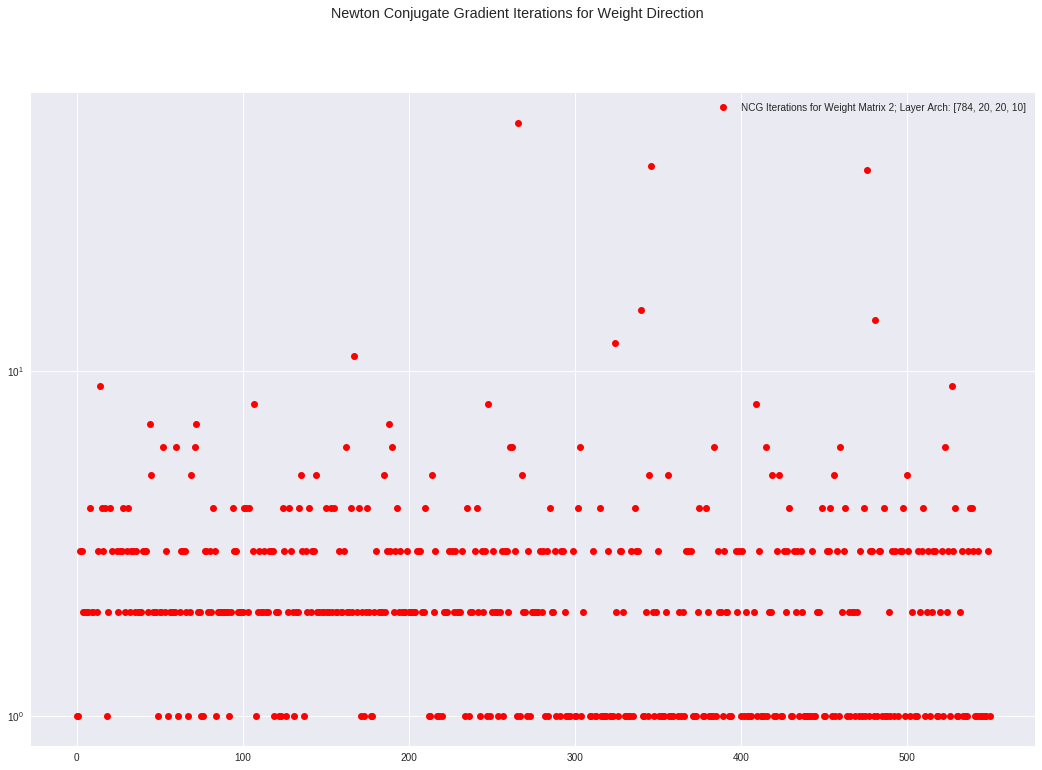

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Weight Matrix 2 has converged.
Weight Matrix 3 has converged.
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200


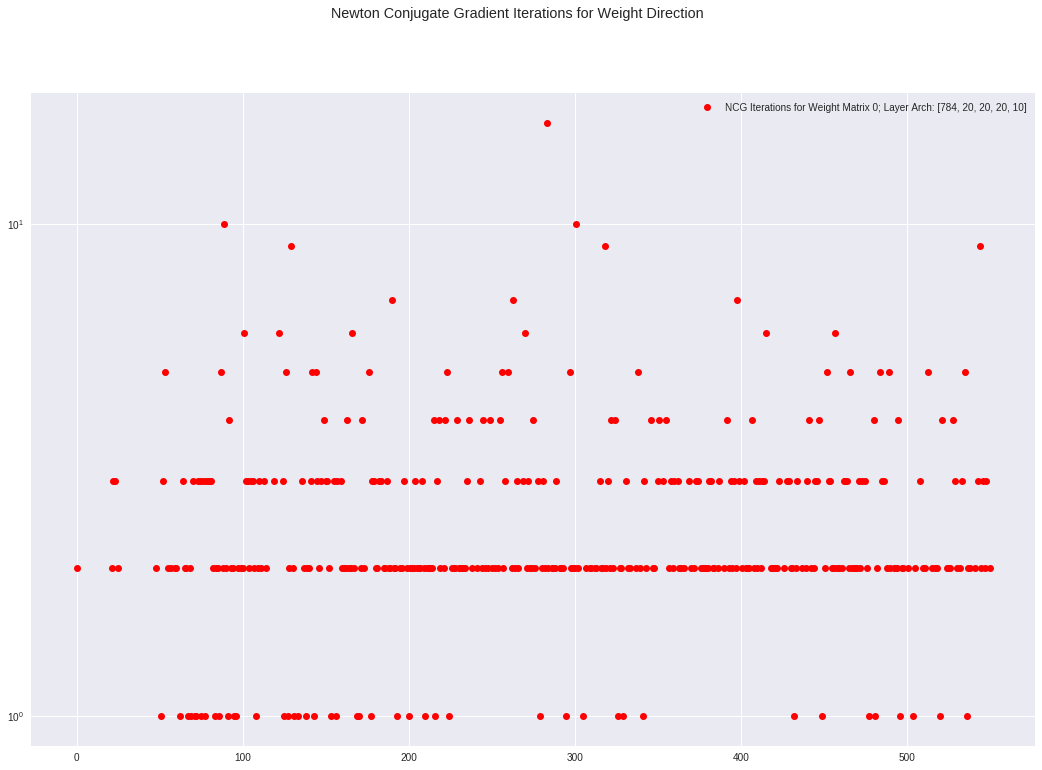

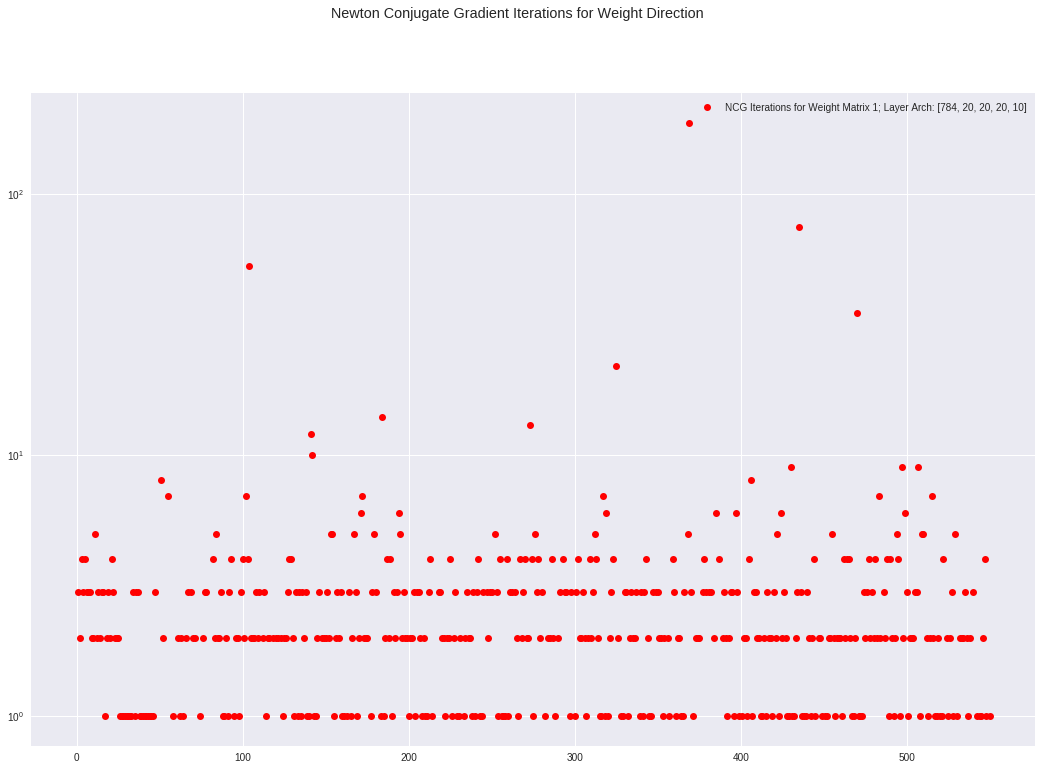

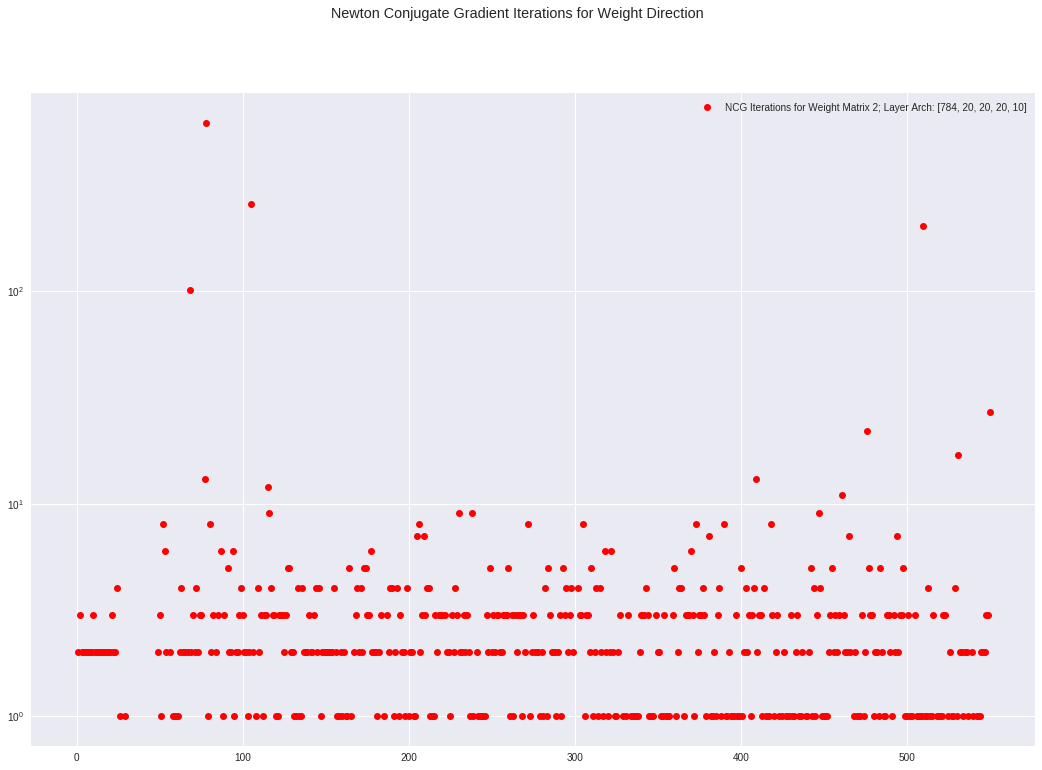

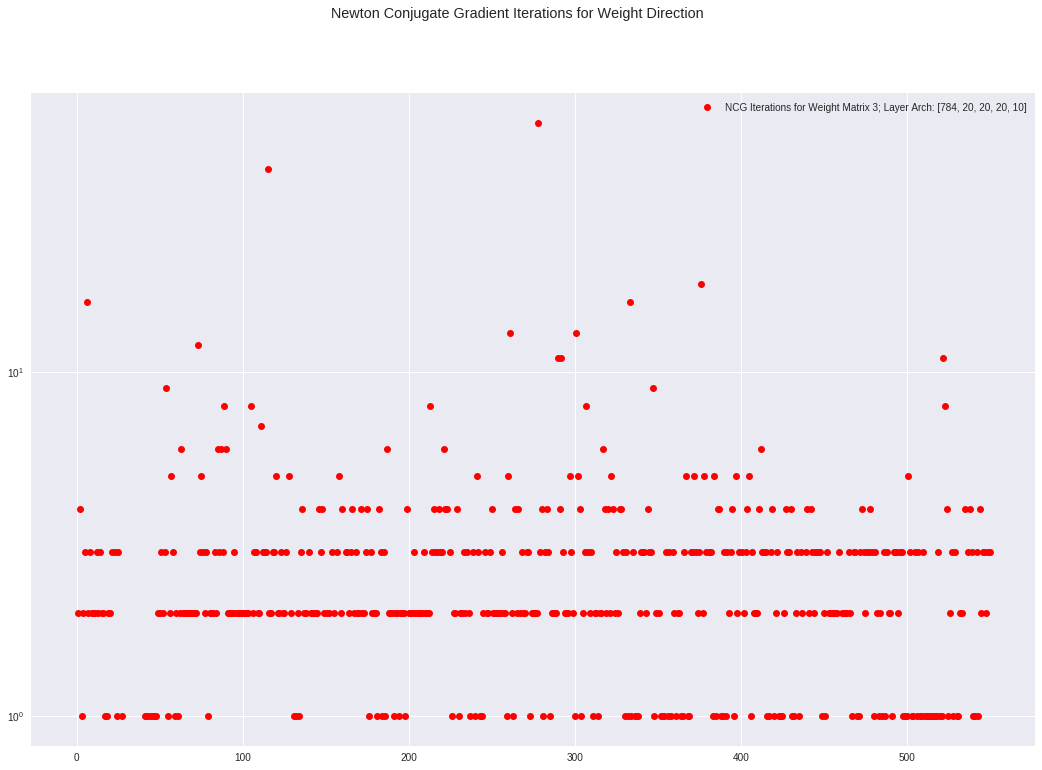

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Weight Matrix 4 has converged.
Iteration: 0
Weight Matrix 3 has converged.
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200


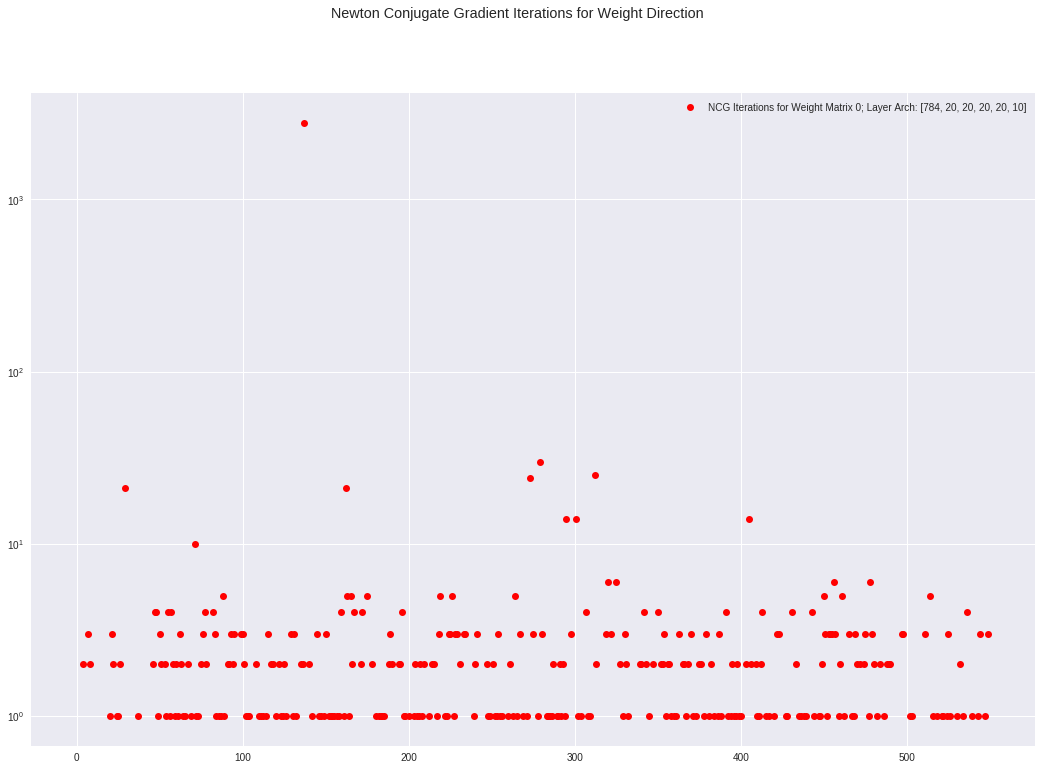

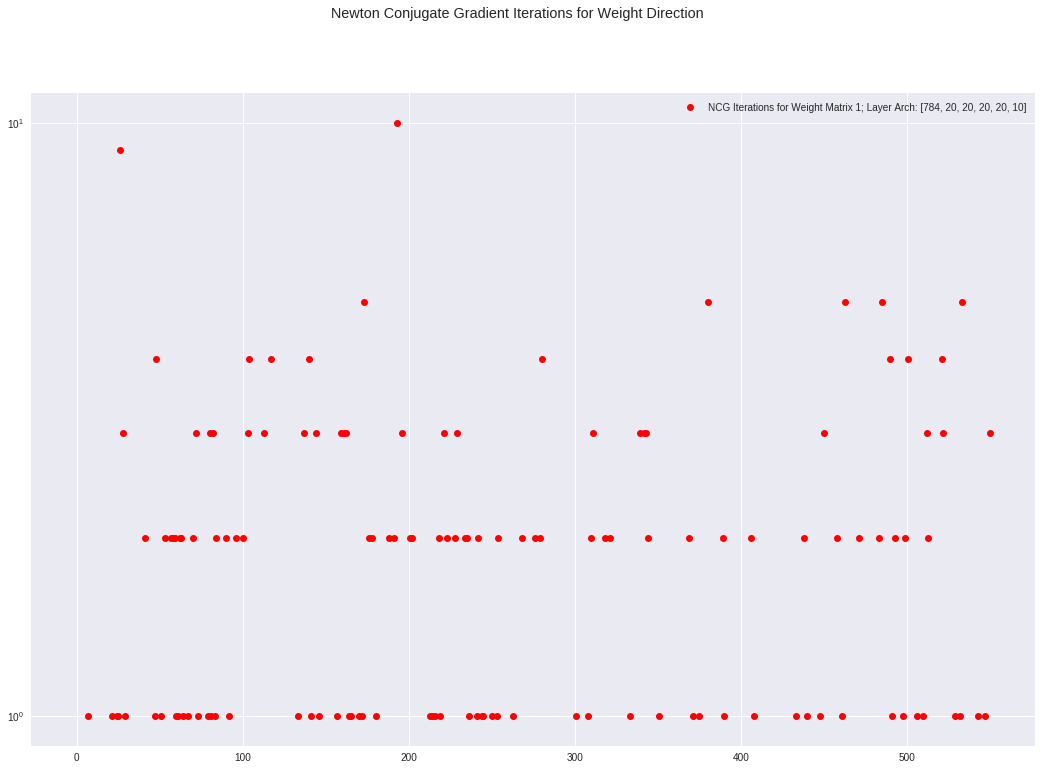

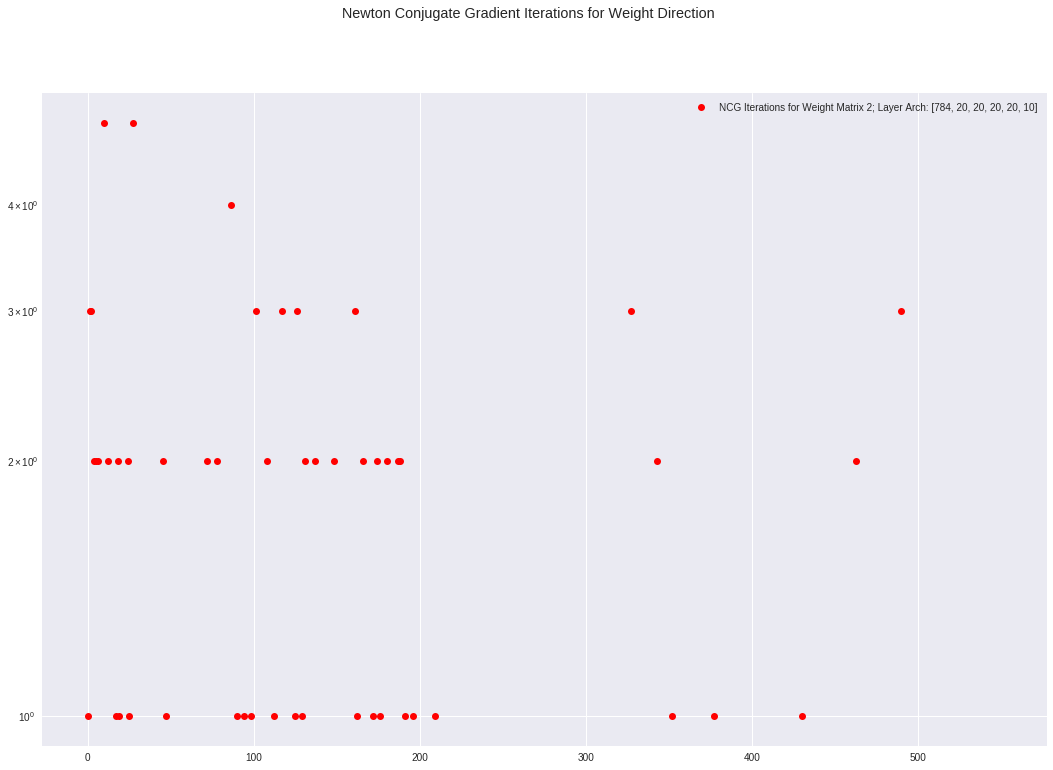

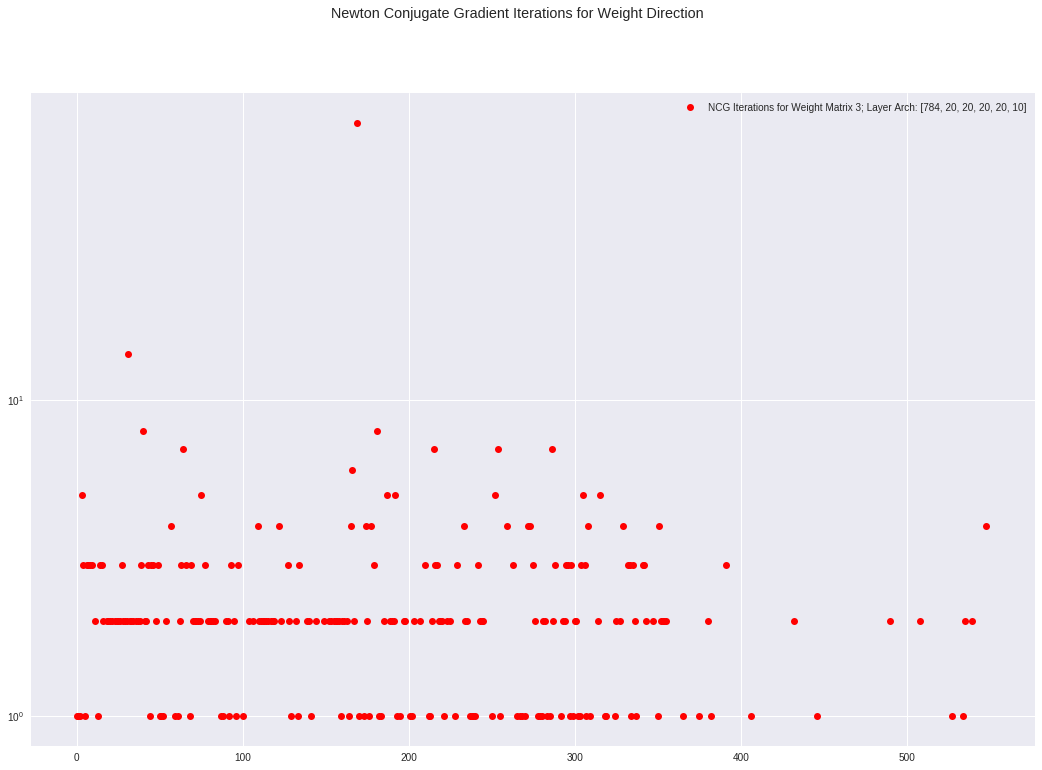

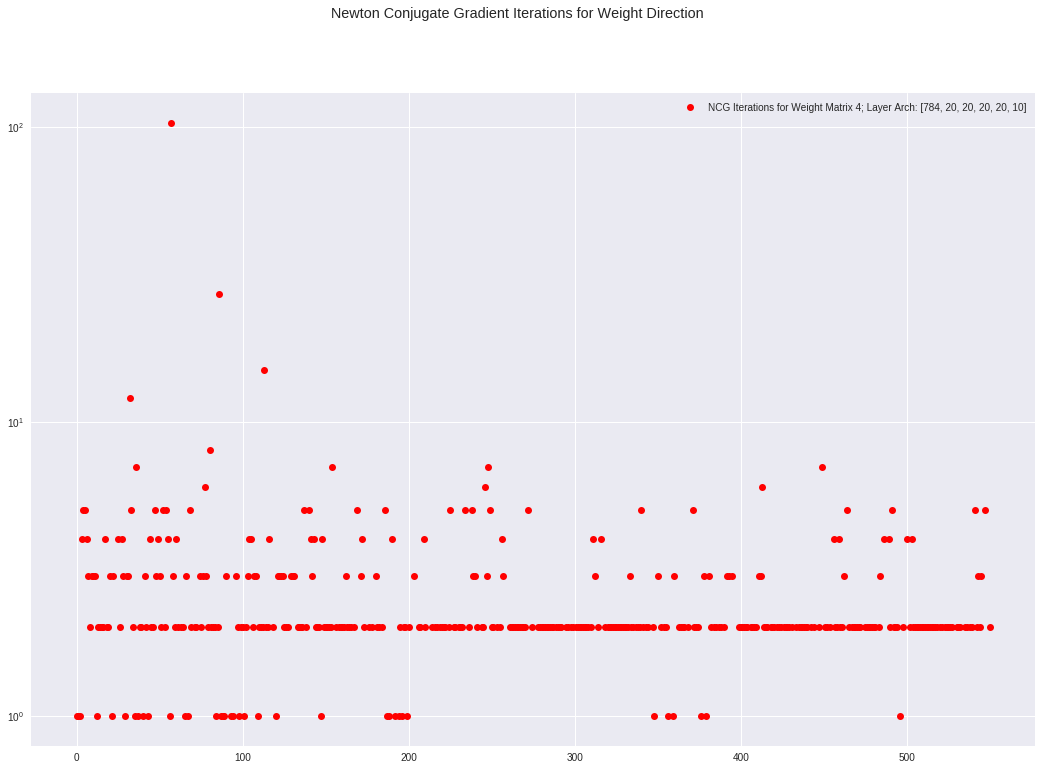

In [40]:
for idm,models in enumerate(experiments):
  while len(models) != 0:
    name = models[0].__class__.__name__ 
    print name

    # Reset graph, recreate placeholders and dataset.
    mnist = get_data()
    eval_mnist = get_data()

    #####################################################
    # Define model, loss, update and evaluation metric. #
    #####################################################

    ann = models[0]    
    batch_size = ann.batchSize

    del models[0]

    # Train.
    i, train_accuracy, test_accuracy, losses, step_sizes = -1, [], [], [], []
    log_period_updates = int(log_period_samples / batch_size)
    while mnist.train.epochs_completed < num_epochs:

      # Update.
      i += 1
      batch_xs, batch_ys = mnist.train.next_batch(batch_size)

      if i==0:
        losses.append(ann.xEnt(0,batch_ys,0,0,batch_xs/255.))

      #################
      # Training step #
      #################
      
      res = ann.backprop(batch_ys, ann.forward(batch_xs/255.), batch_xs/255.)
      losses.append(ann.xEnt(0,batch_ys,0,0,batch_xs/255.))

      # Periodically evaluate.
      if i % log_period_updates == 0:
        print 'Iteration: ' + str(i)
        #####################################
        # Compute and store train accuracy. #
        #####################################

        out = ann.forward(batch_xs/255.)

        prediction = np.argmax(out, axis=1)
        truth = np.argmax(batch_ys, axis=1)

        correct = 0.
        for a,b in zip(prediction,truth):
          if a == b:
            correct += 1.

        train_accuracy.append(correct/(batch_ys.shape[0]))
        #####################################
        # Compute and store test accuracy. #
        #####################################
        test_xs, test_ys = mnist.test.images, mnist.test.labels

        out = ann.forward(test_xs/255.)

        prediction = np.argmax(out, axis=1)
        truth = np.argmax(test_ys, axis=1)

        correct = 0.
        for a,b in zip(prediction,truth):
          if a == b:
            correct += 1.

        test_accuracy.append(correct/test_ys.shape[0])
        
      #if res == 'converged':
      #  break
      #else:
      step_sizes.append(res)

    name += '_' + str(ann.layers)
    if 'BFGS' in name:
      name += ', M = ' + str(ann.M)
      
    if 'CG_STEIHAUG' in name:
      for idx,iterList in enumerate(ann.NCG_Iterations[:-1]):
        fig = plt.figure(figsize=(18,12))
        st = fig.suptitle(
            "Steihaug Newton Conjugate Gradient Iterations for Weight Direction",
            fontsize="x-large")
        plt.yscale('log')
        #print iterList
        plt.plot(iterList, linestyle='None', marker='o', label='NCG Steihaug Iterations for Weight Matrix ' + str(idx) + '; Layer Arch: ' + str(ann.layers))
        plt.legend()
        plt.show()
    elif 'CG' in name:
      for idx,iterList in enumerate(ann.NCG_Iterations[:-1]):
        fig = plt.figure(figsize=(18,12))
        st = fig.suptitle(
            "Newton Conjugate Gradient Iterations for Weight Direction",
            fontsize="x-large")
        #print iterList
        plt.yscale('log')
        plt.plot(iterList, linestyle='None', marker='o', label='NCG Iterations for Weight Matrix ' + str(idx) + '; Layer Arch: ' + str(ann.layers))
        plt.legend()
        plt.show()
      
    experiment_results[idm].append(
        ((name, num_epochs, ann.batchSize), train_accuracy, test_accuracy, losses, step_sizes, ann.layerIterCount[:-1]))
  

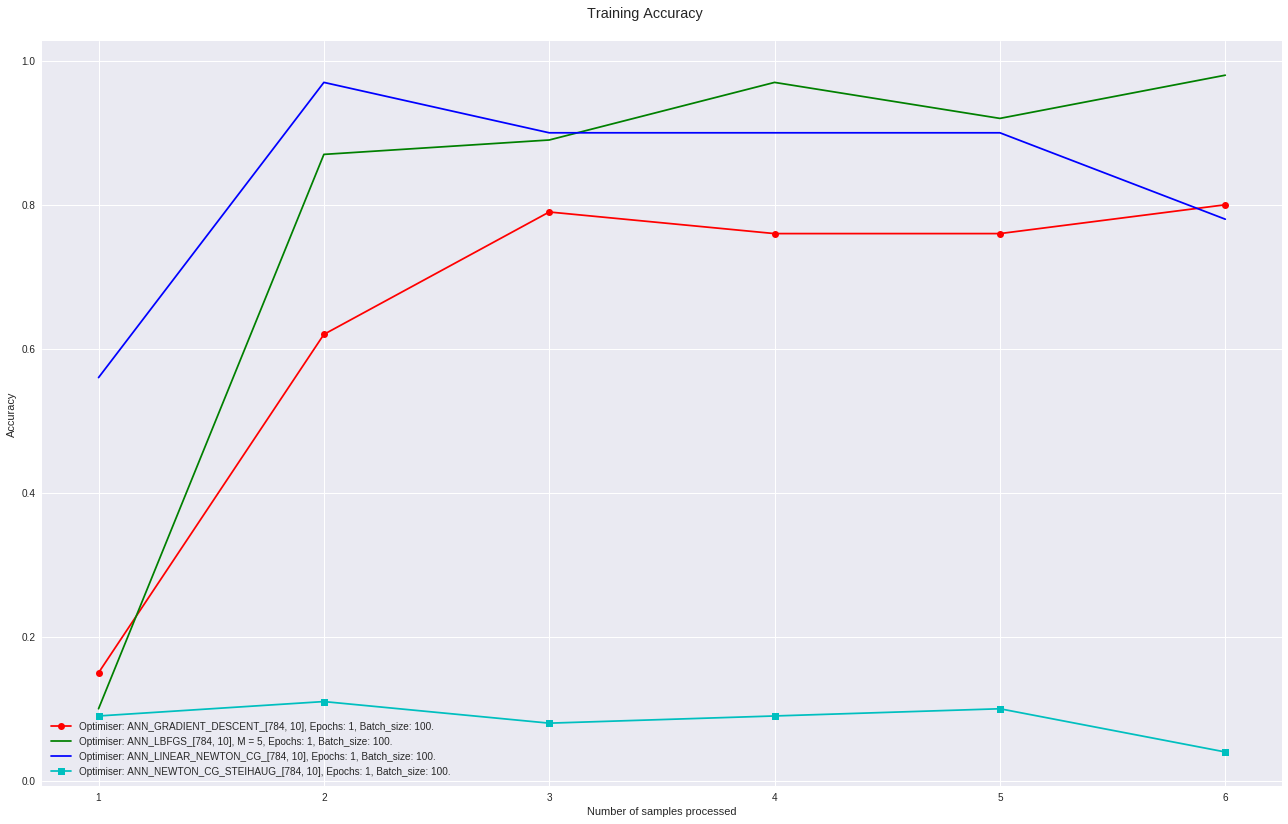

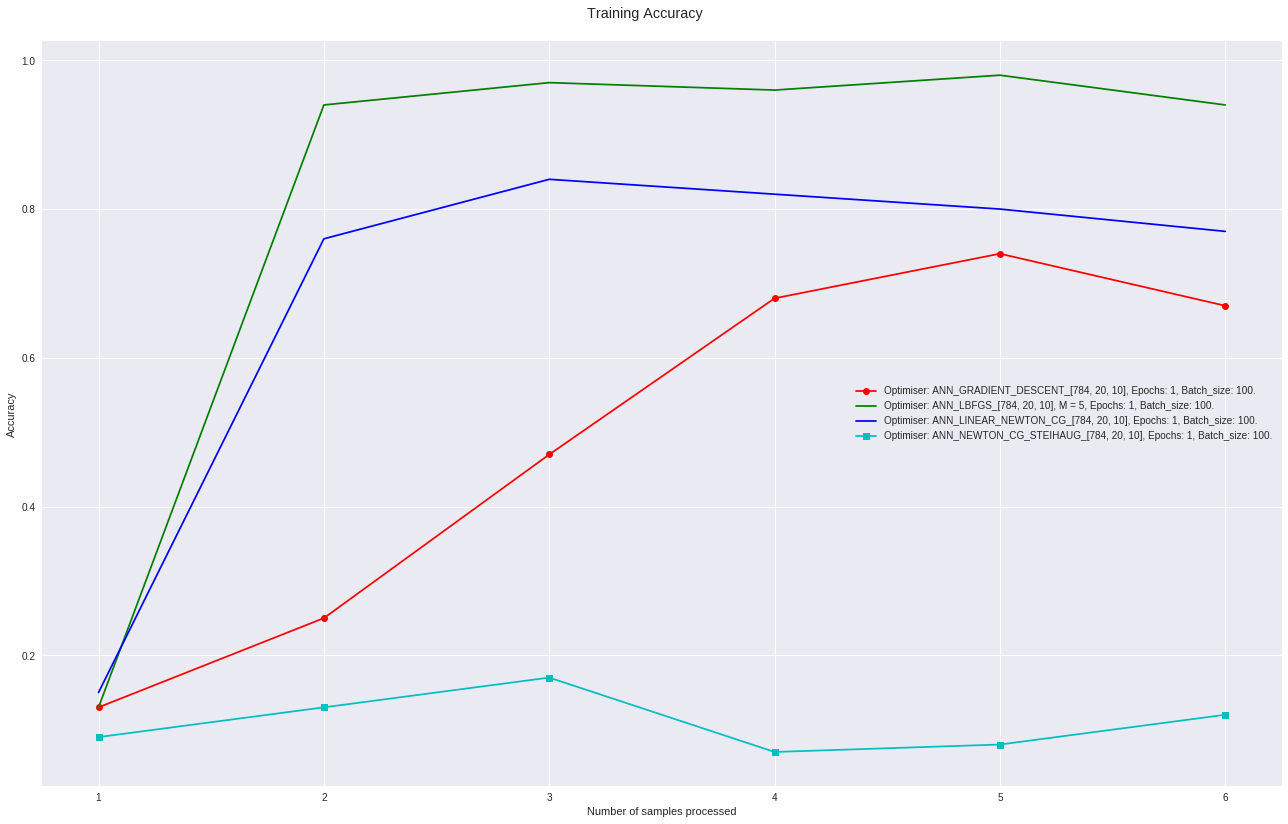

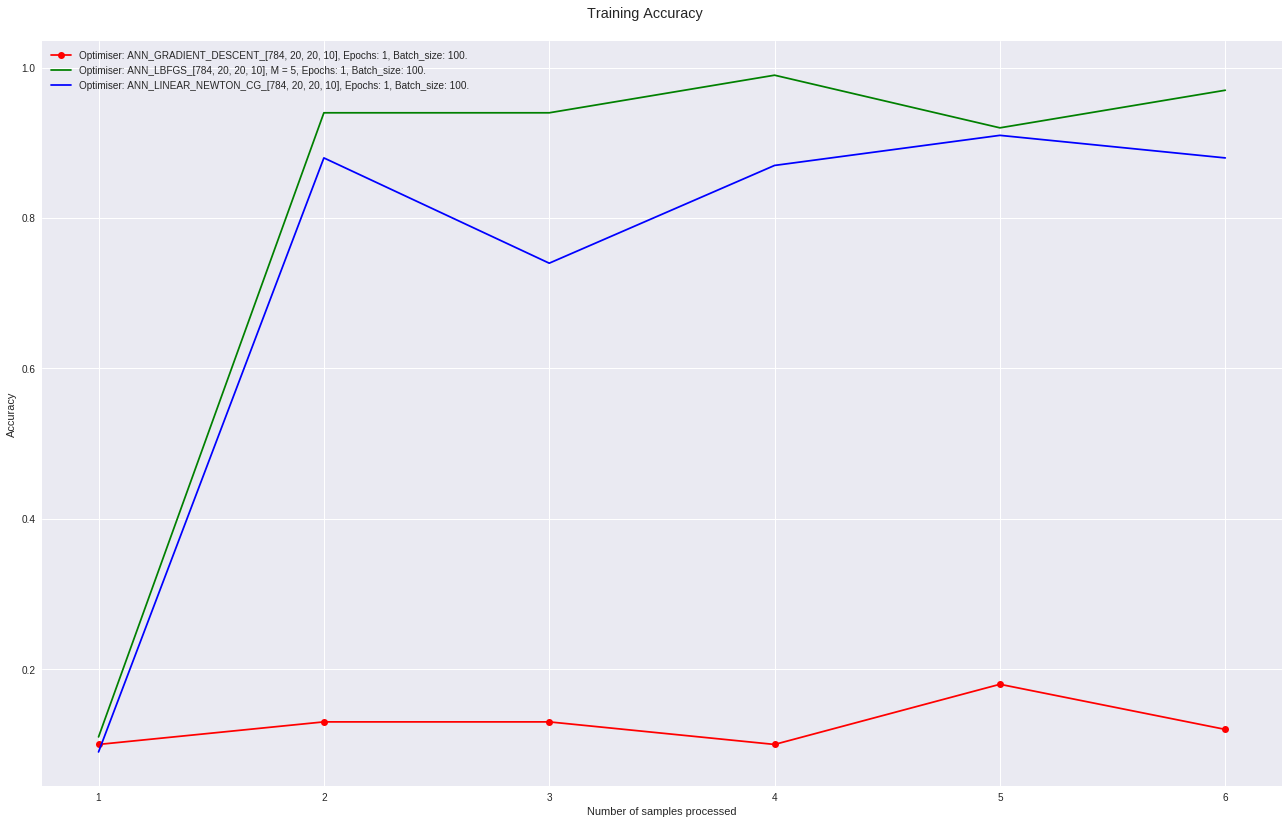

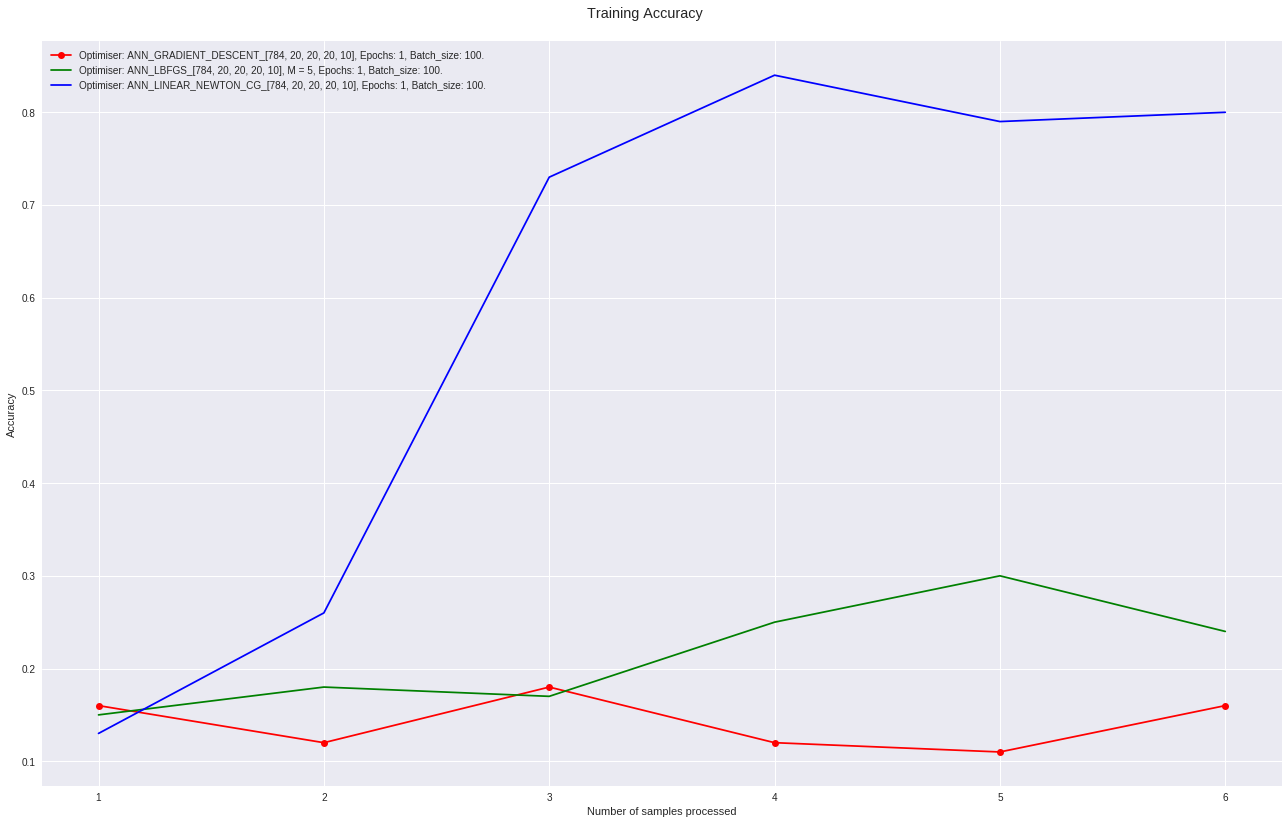

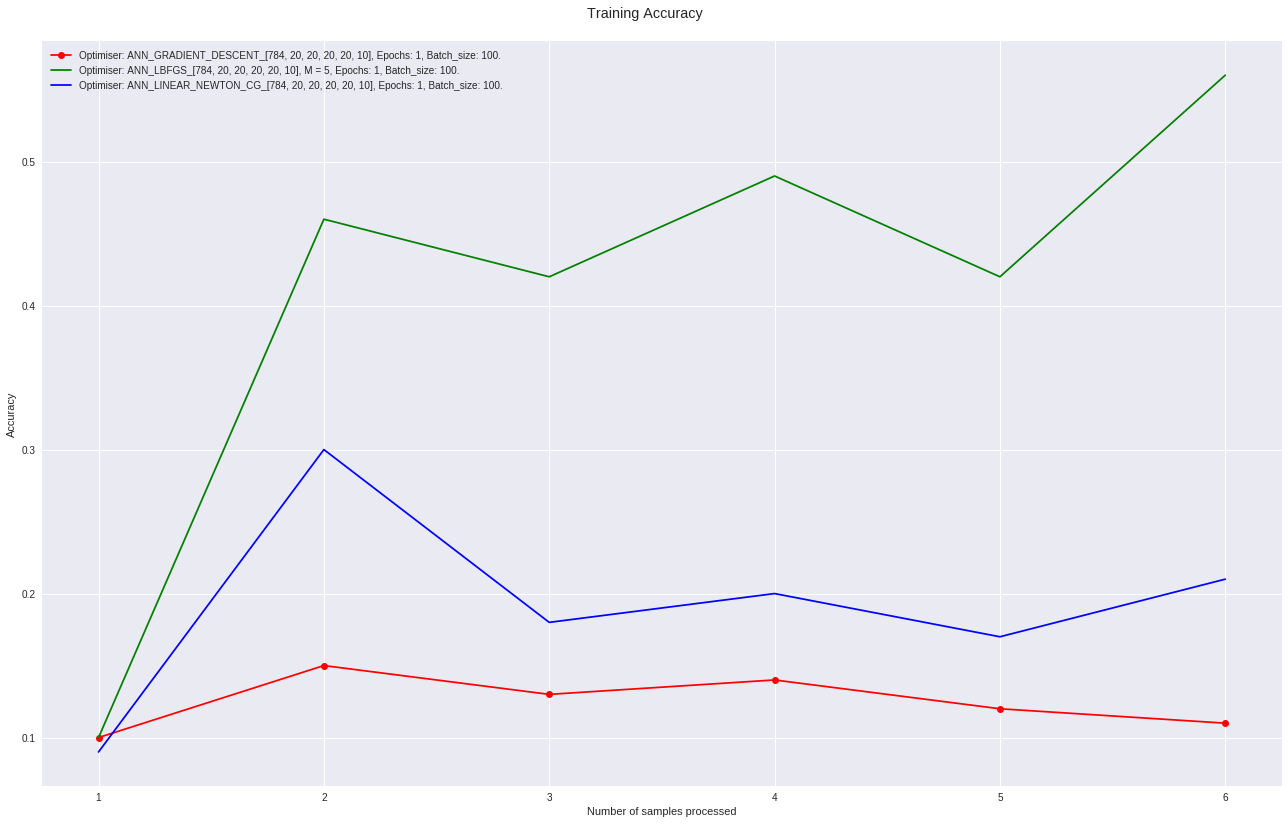

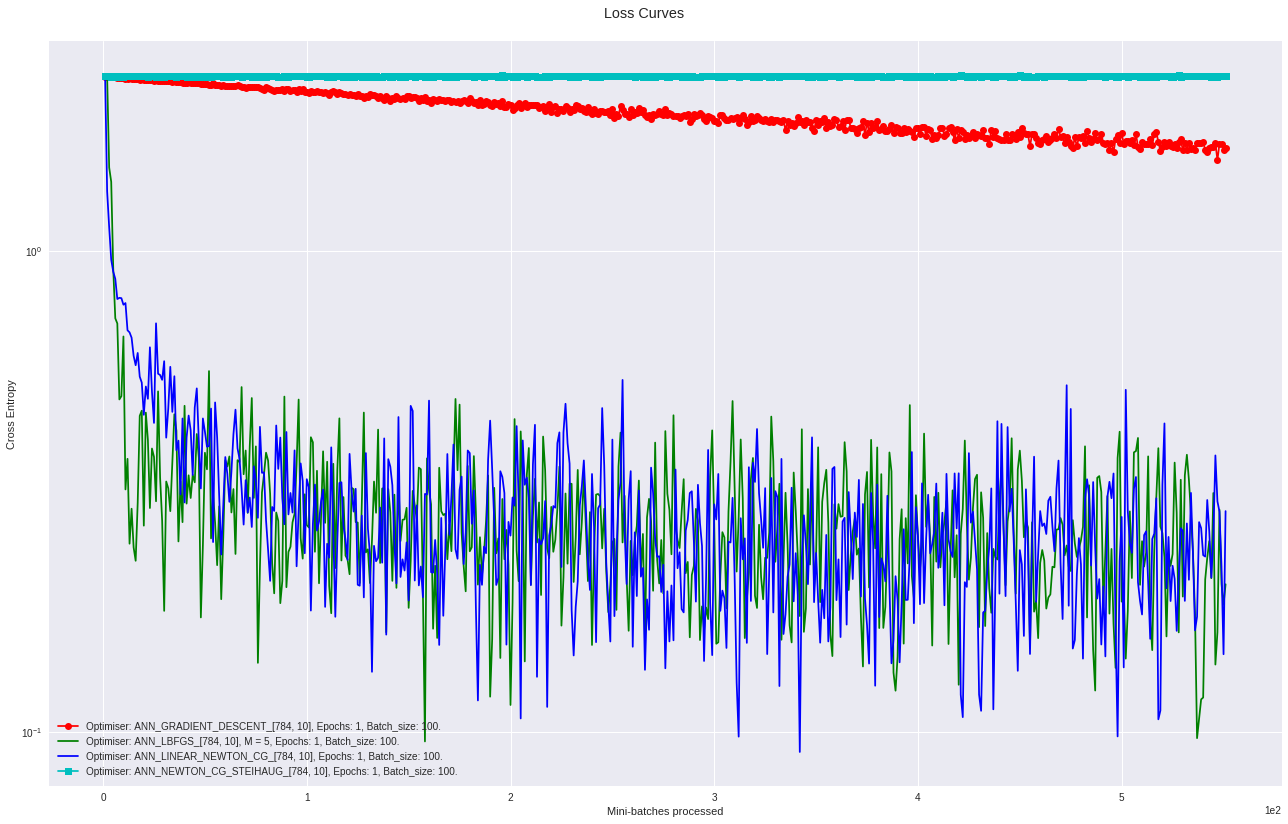

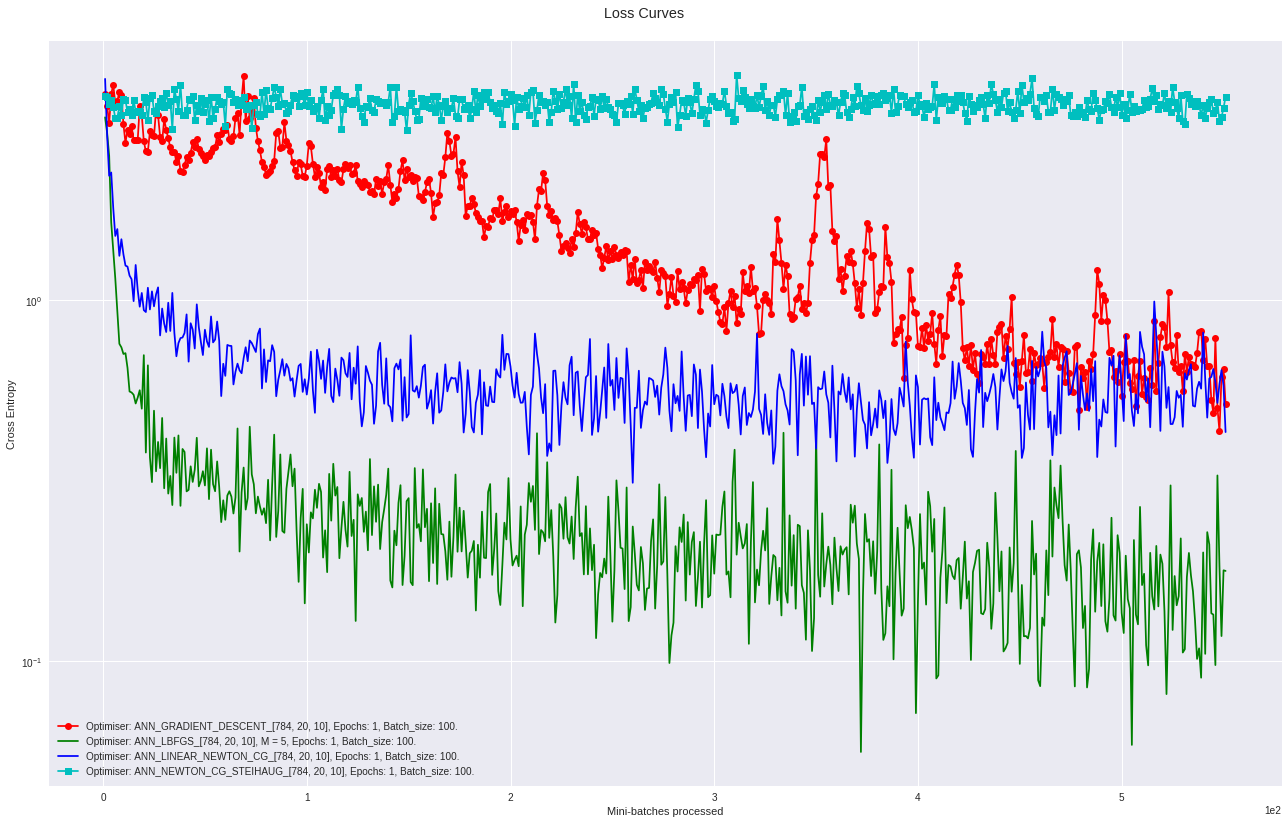

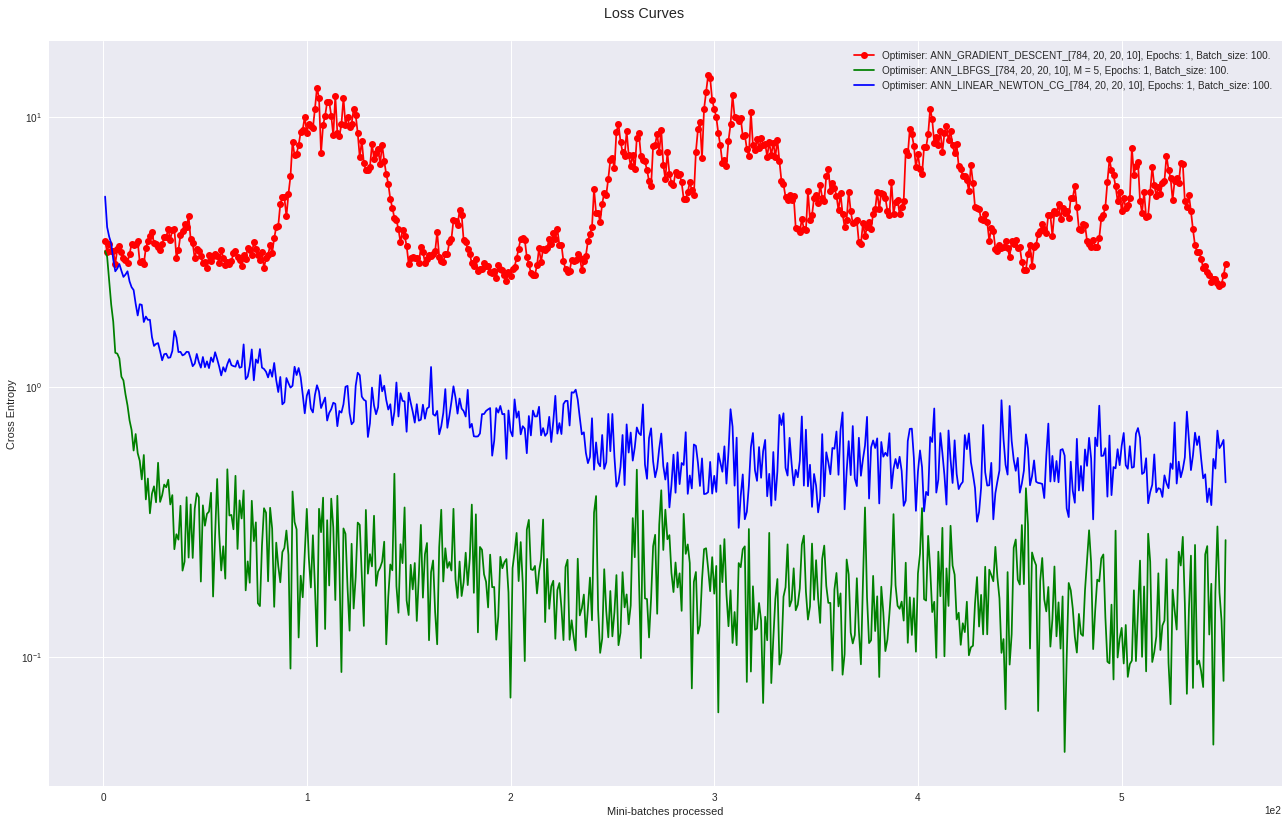

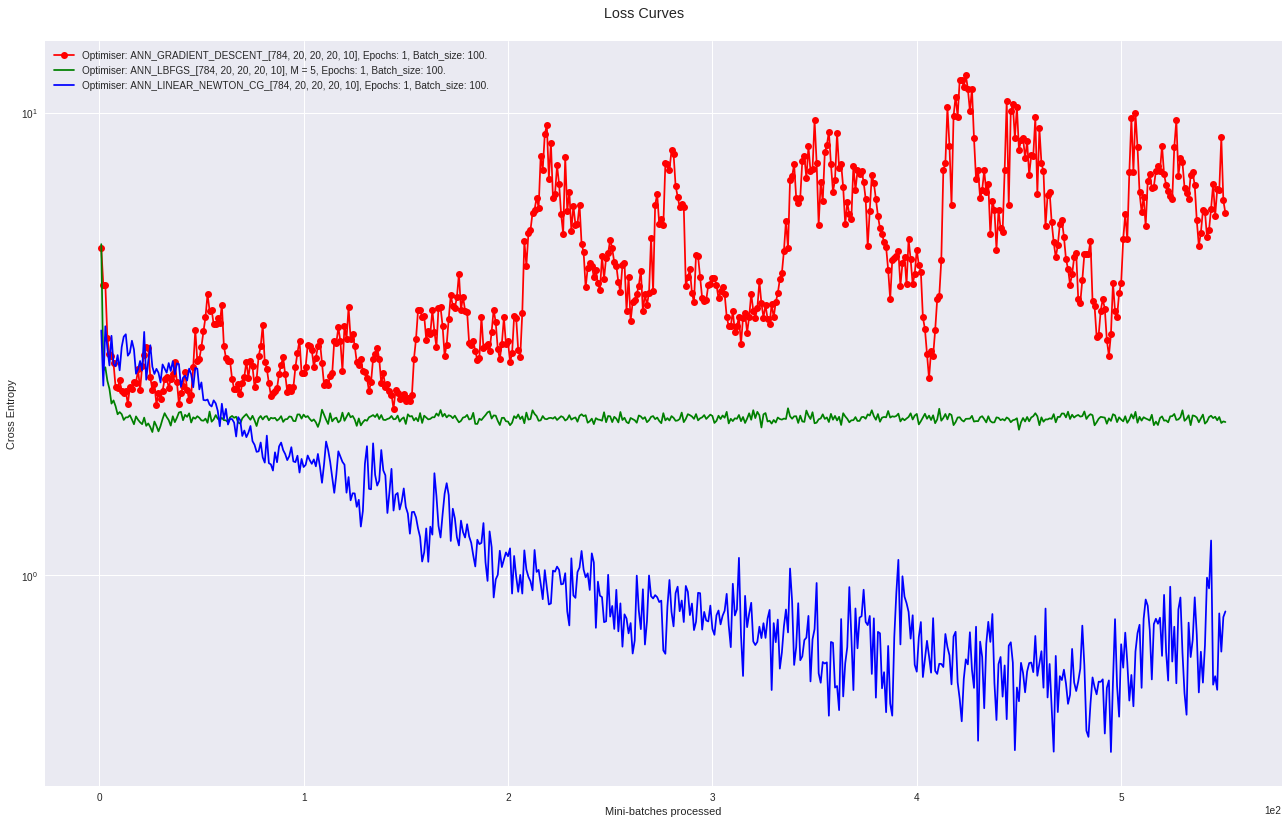

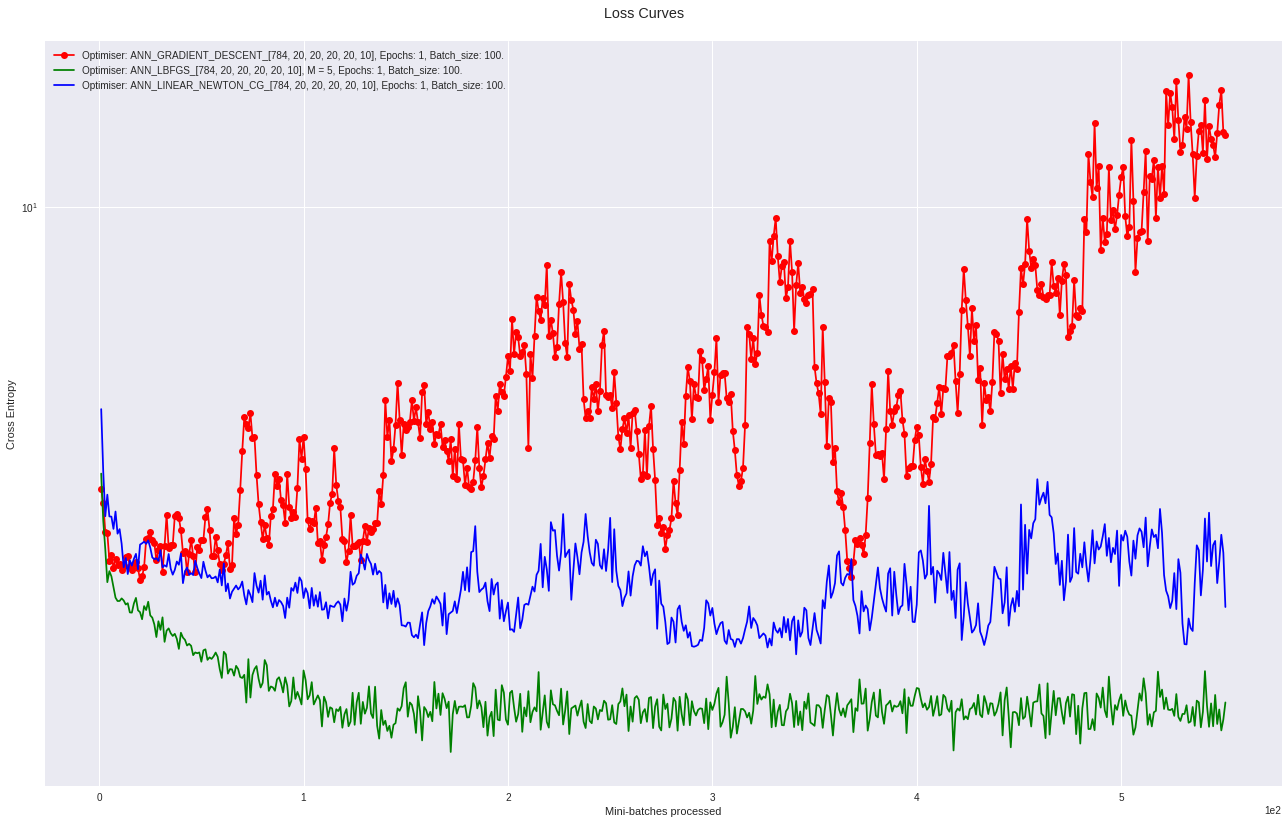

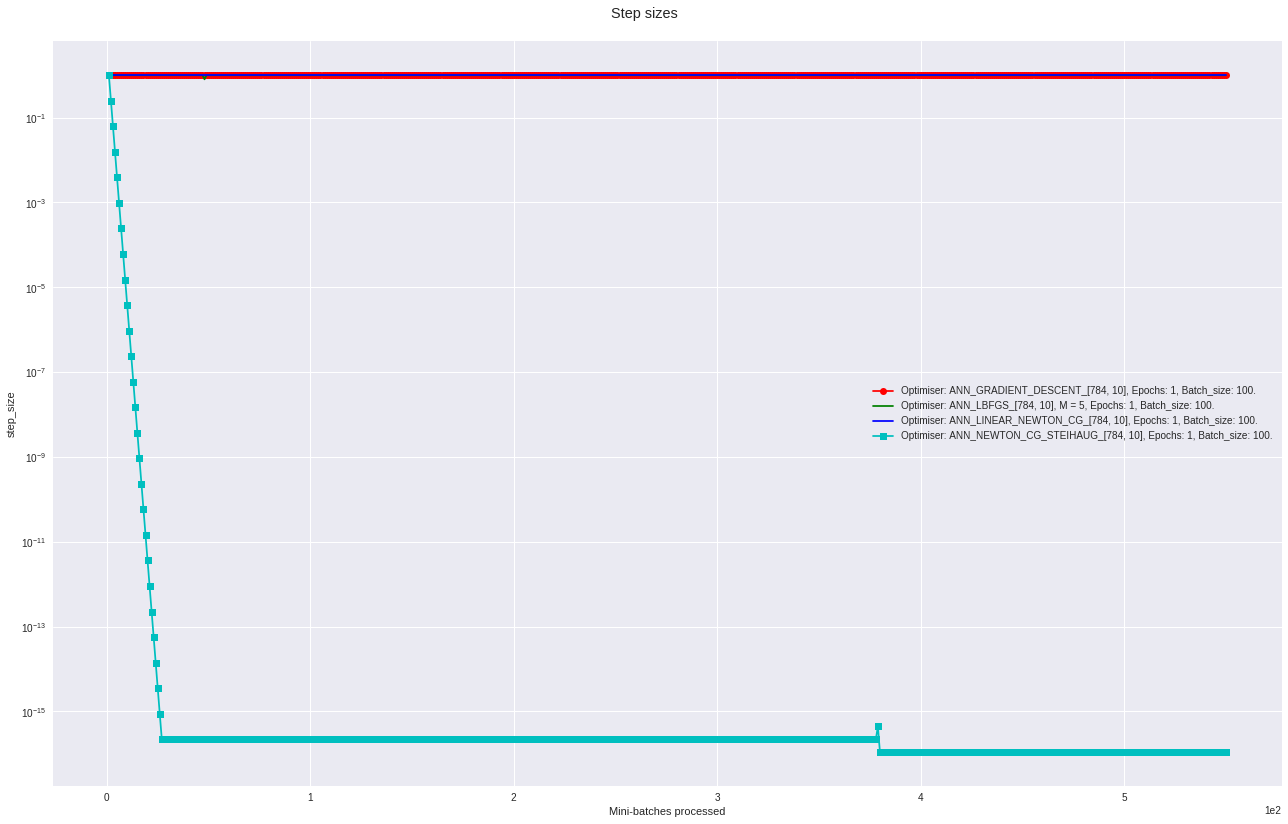

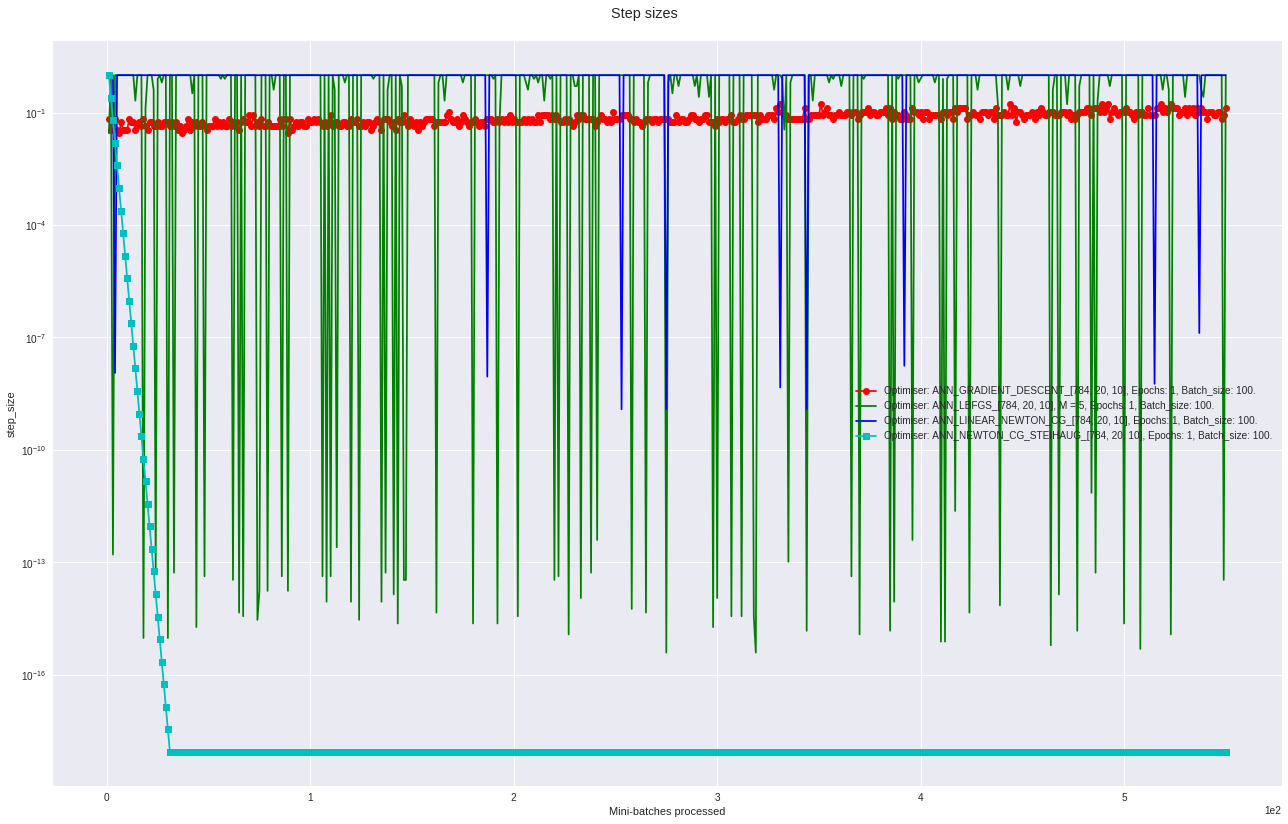

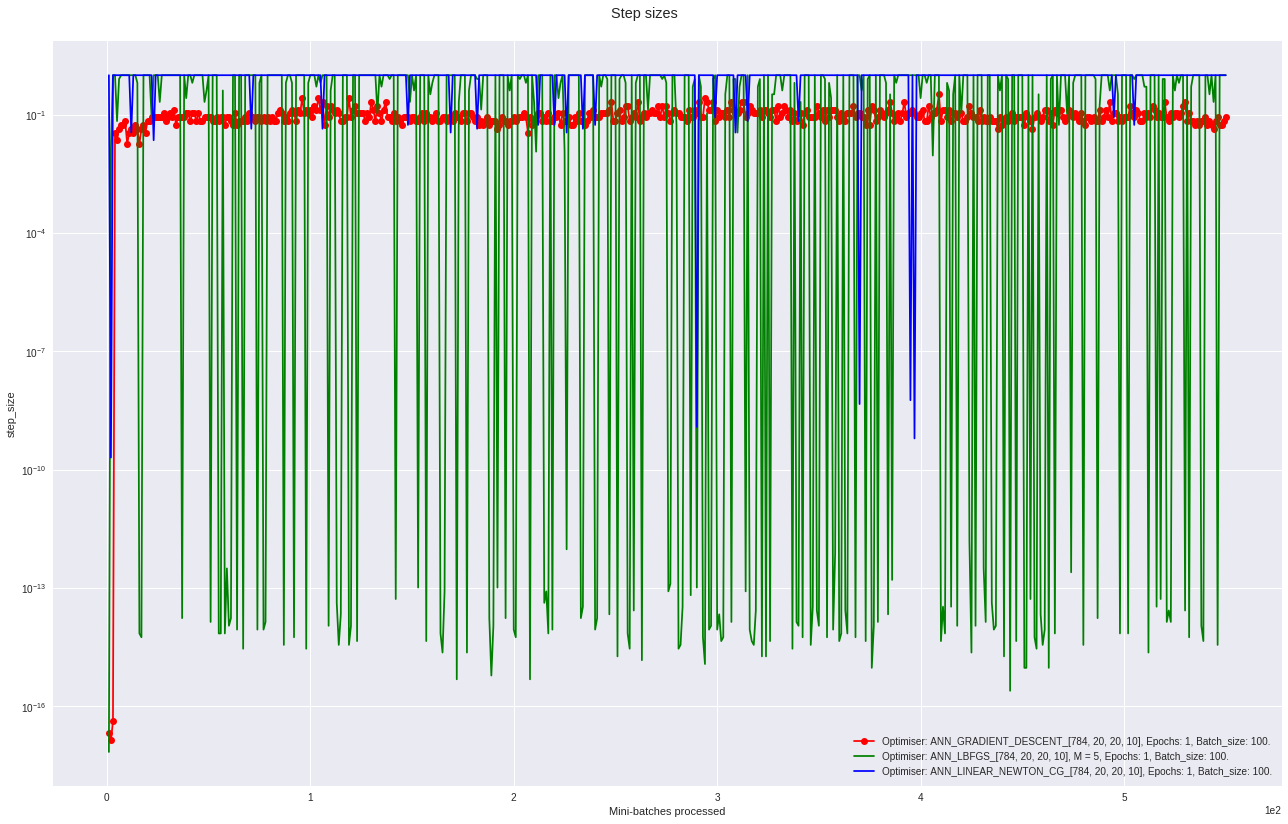

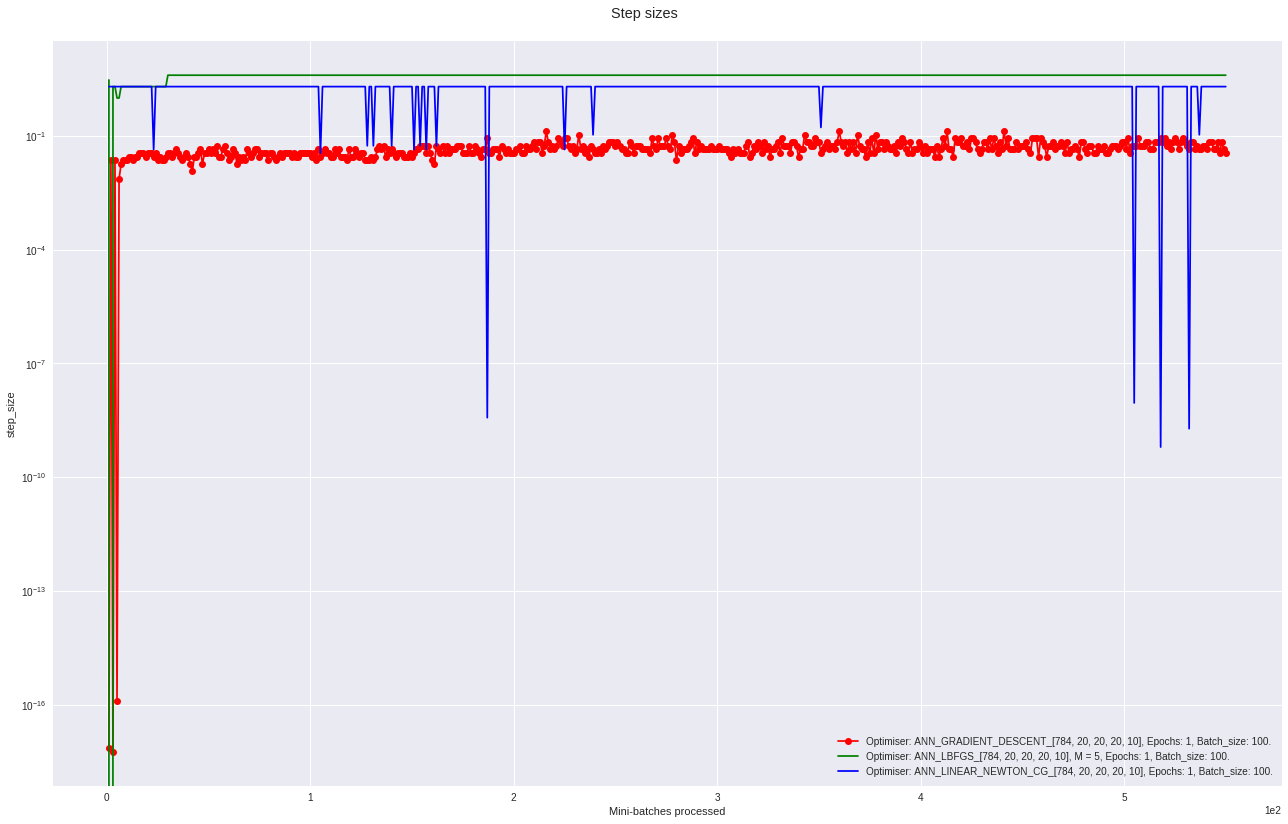

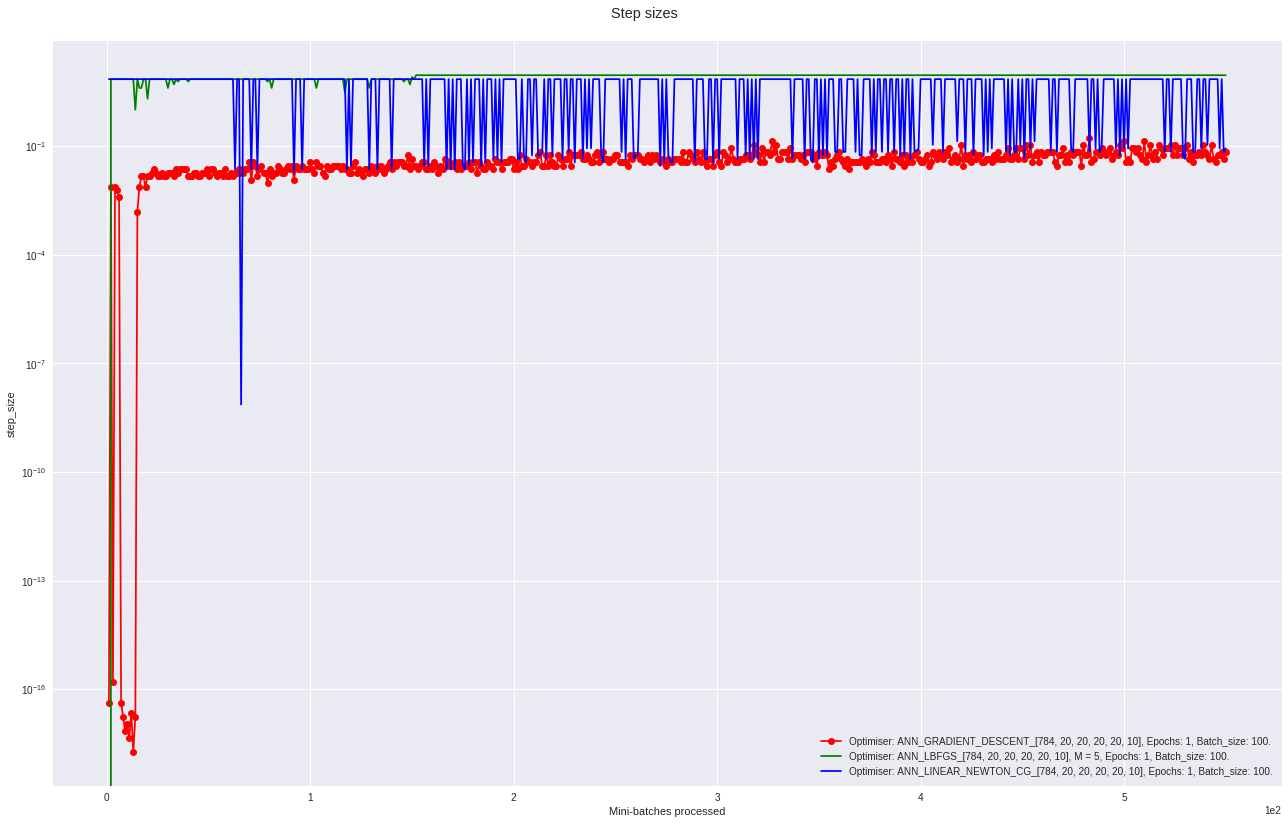

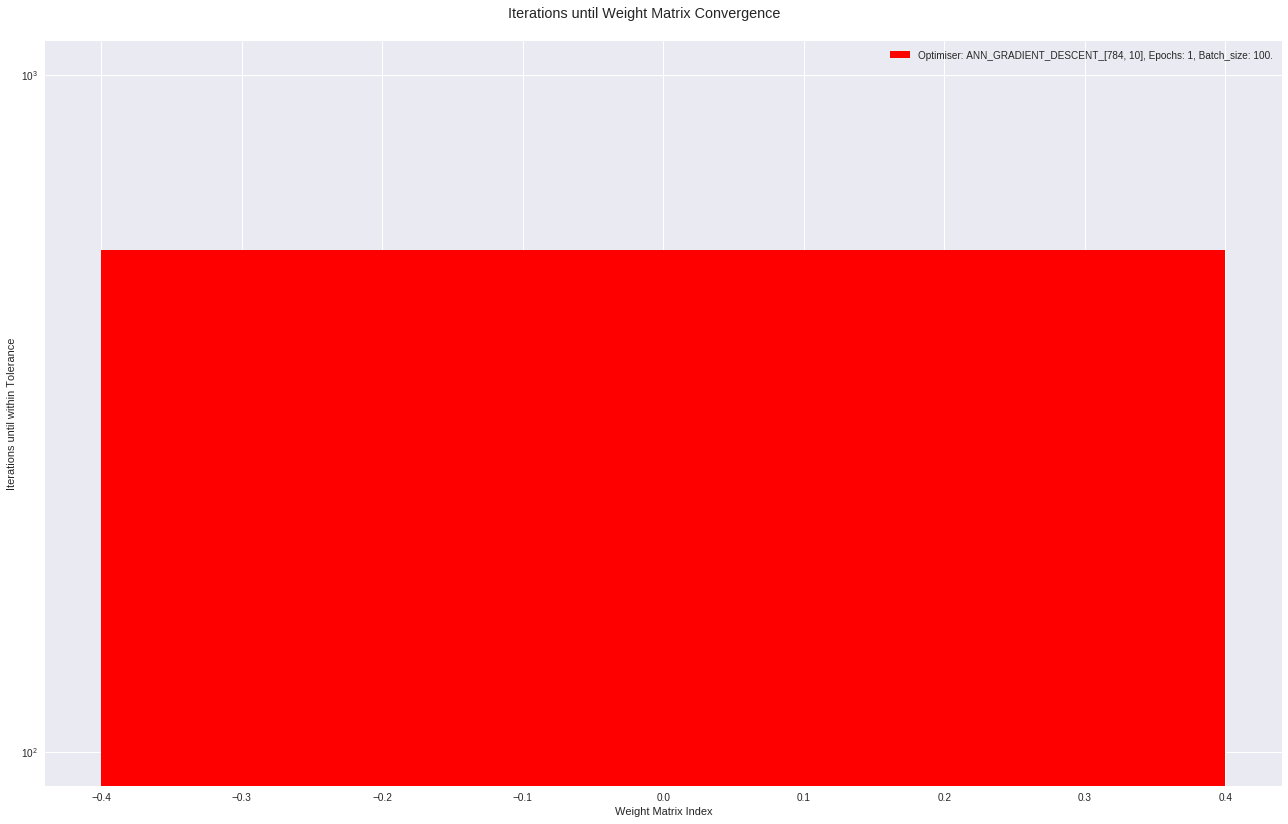

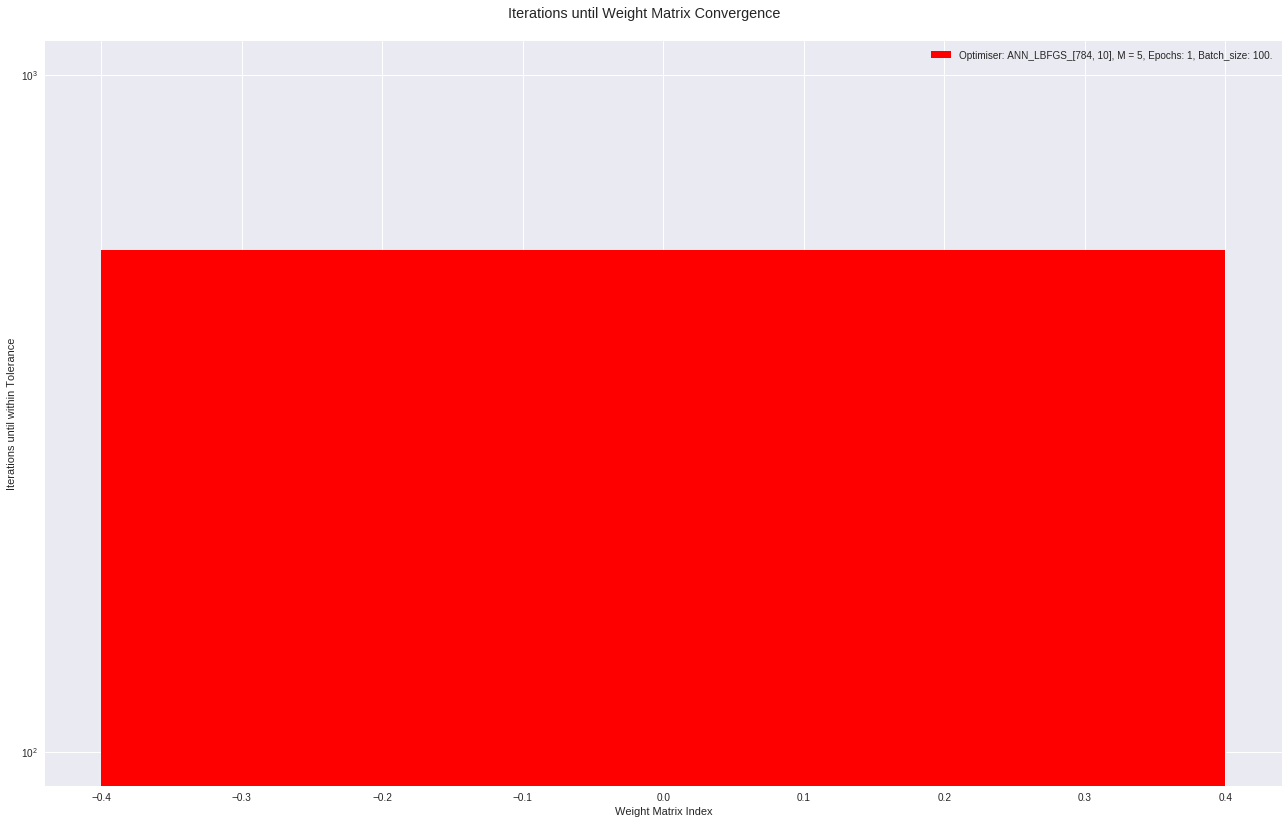

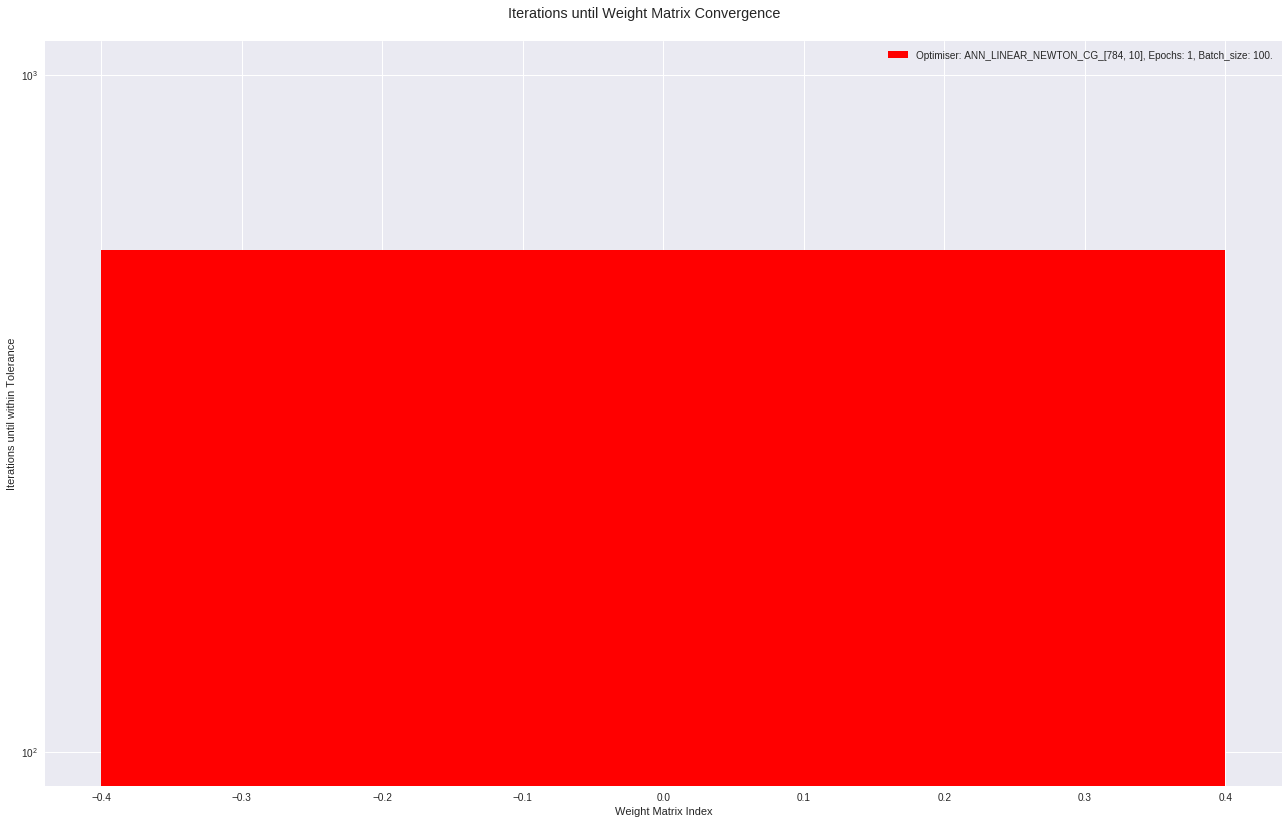

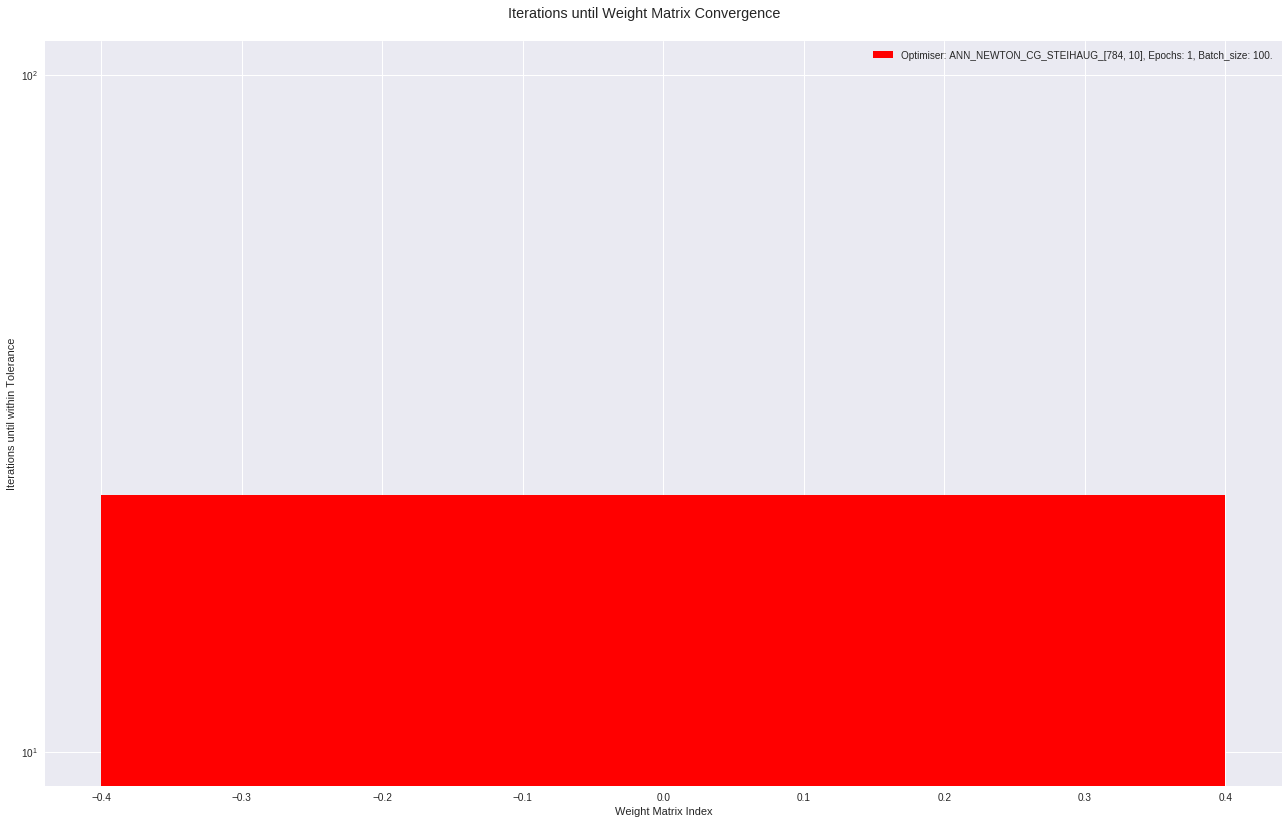

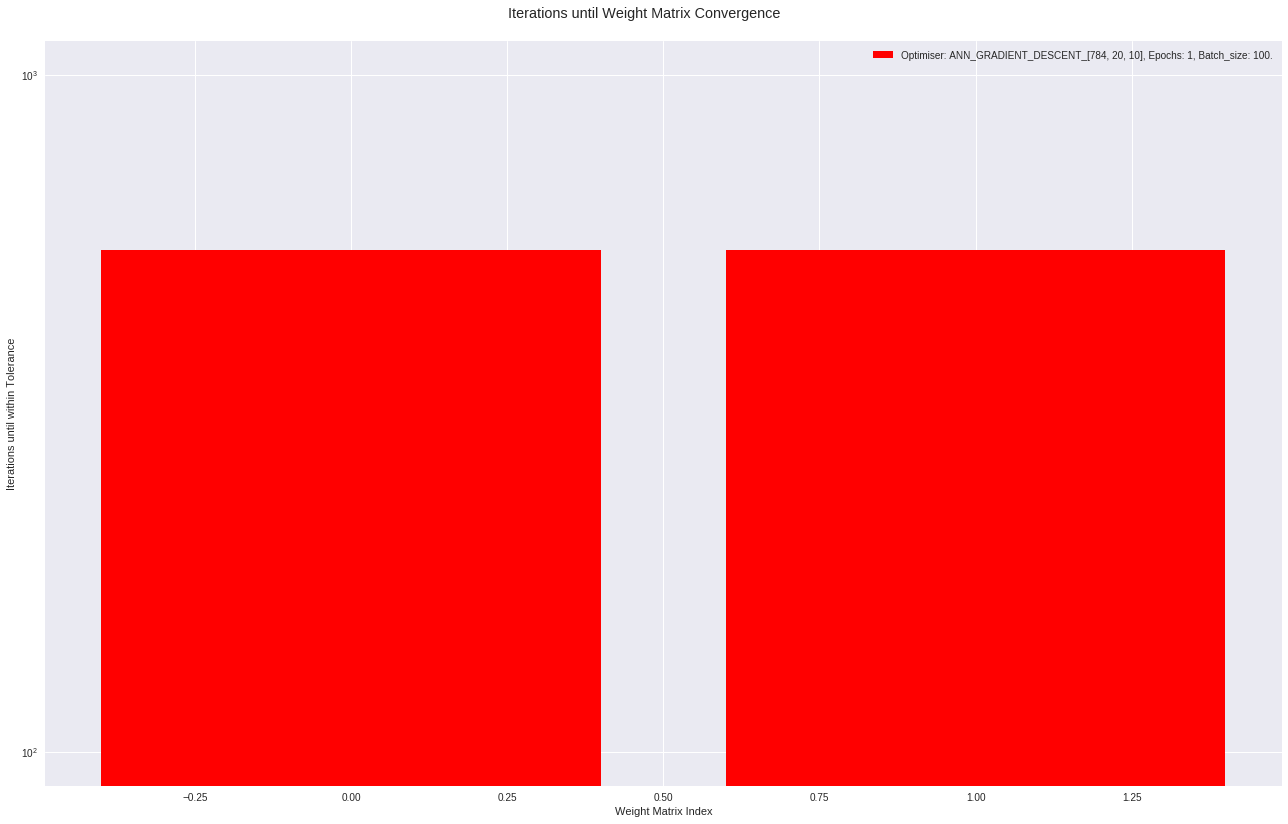

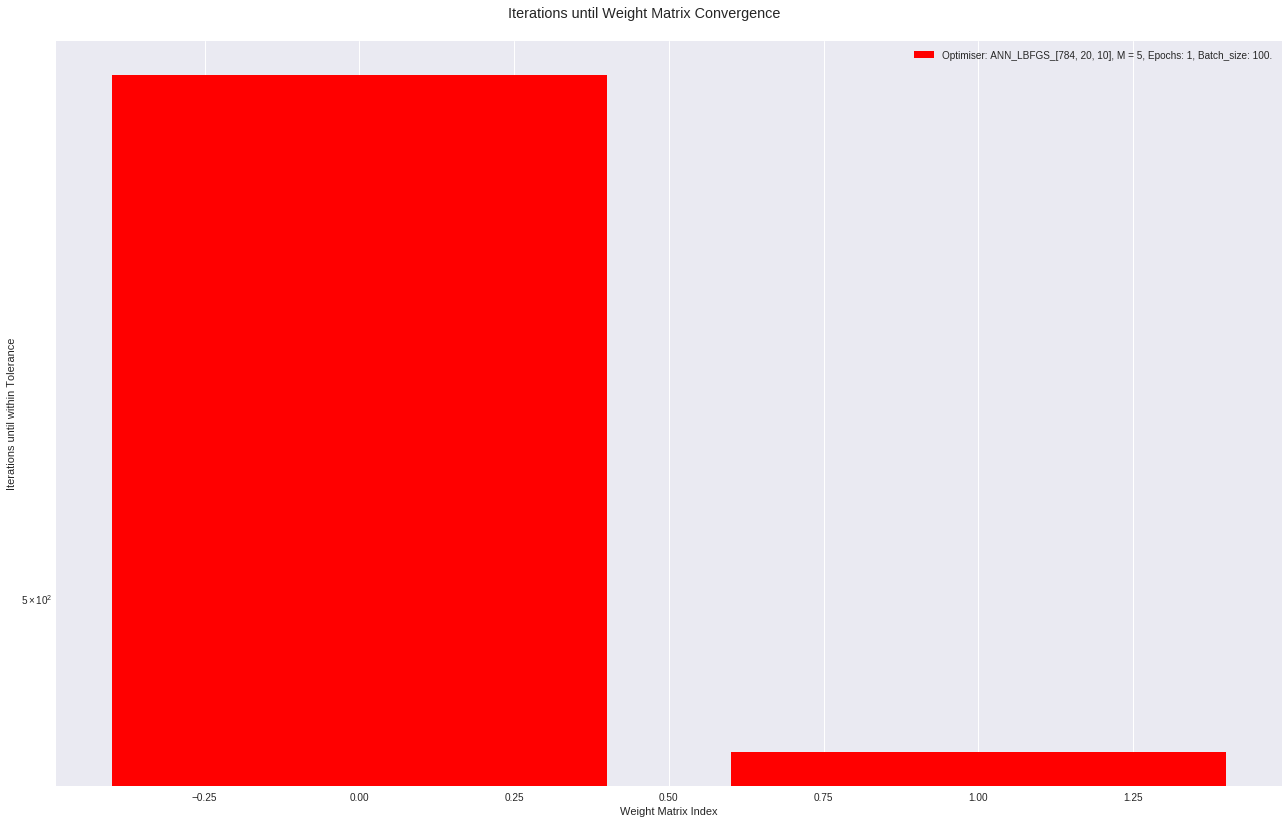

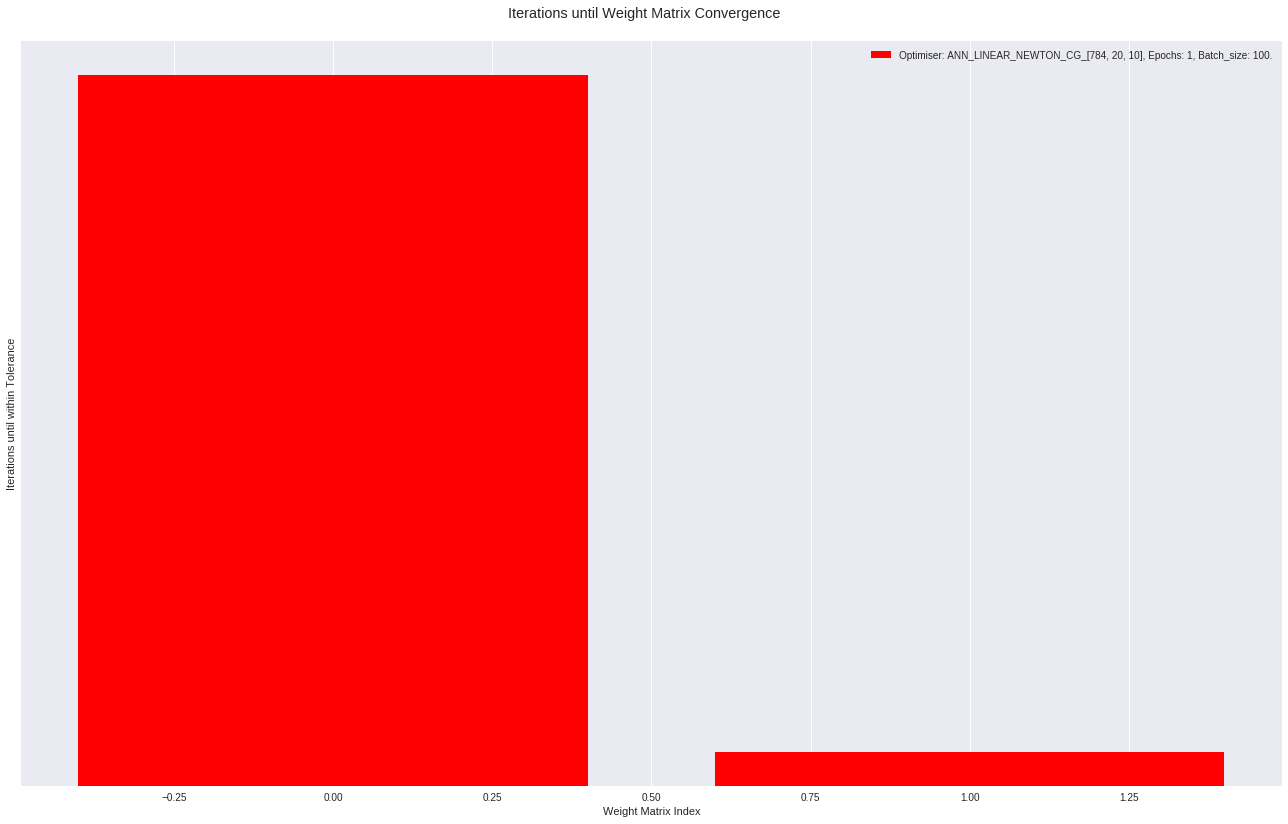

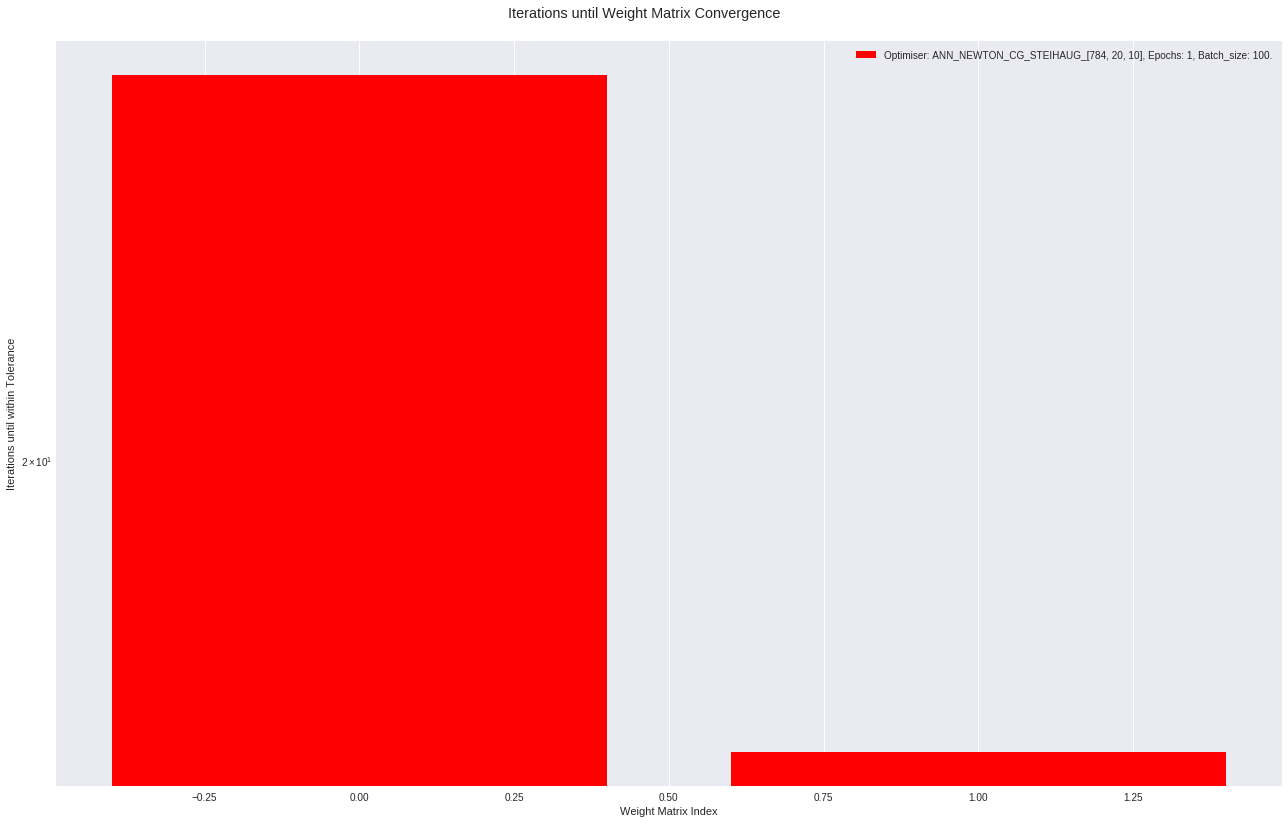

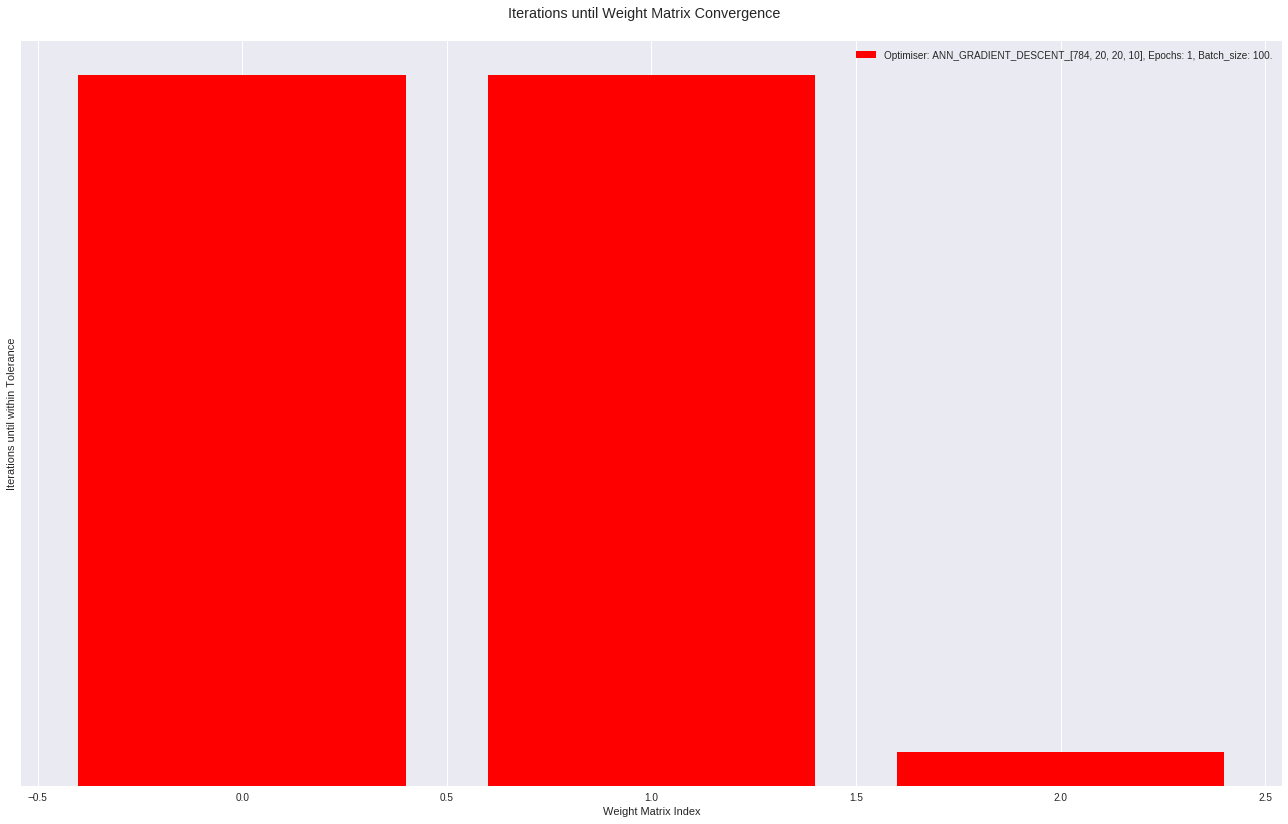

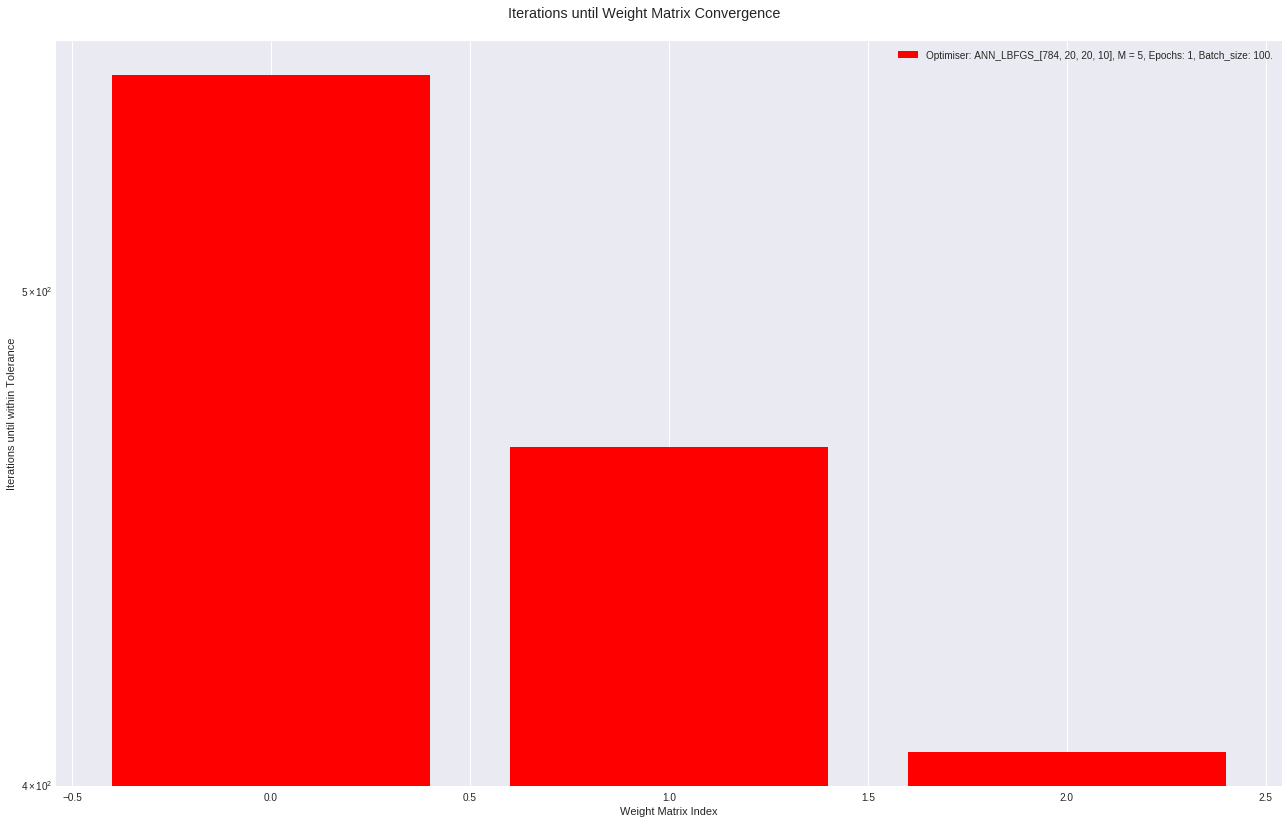

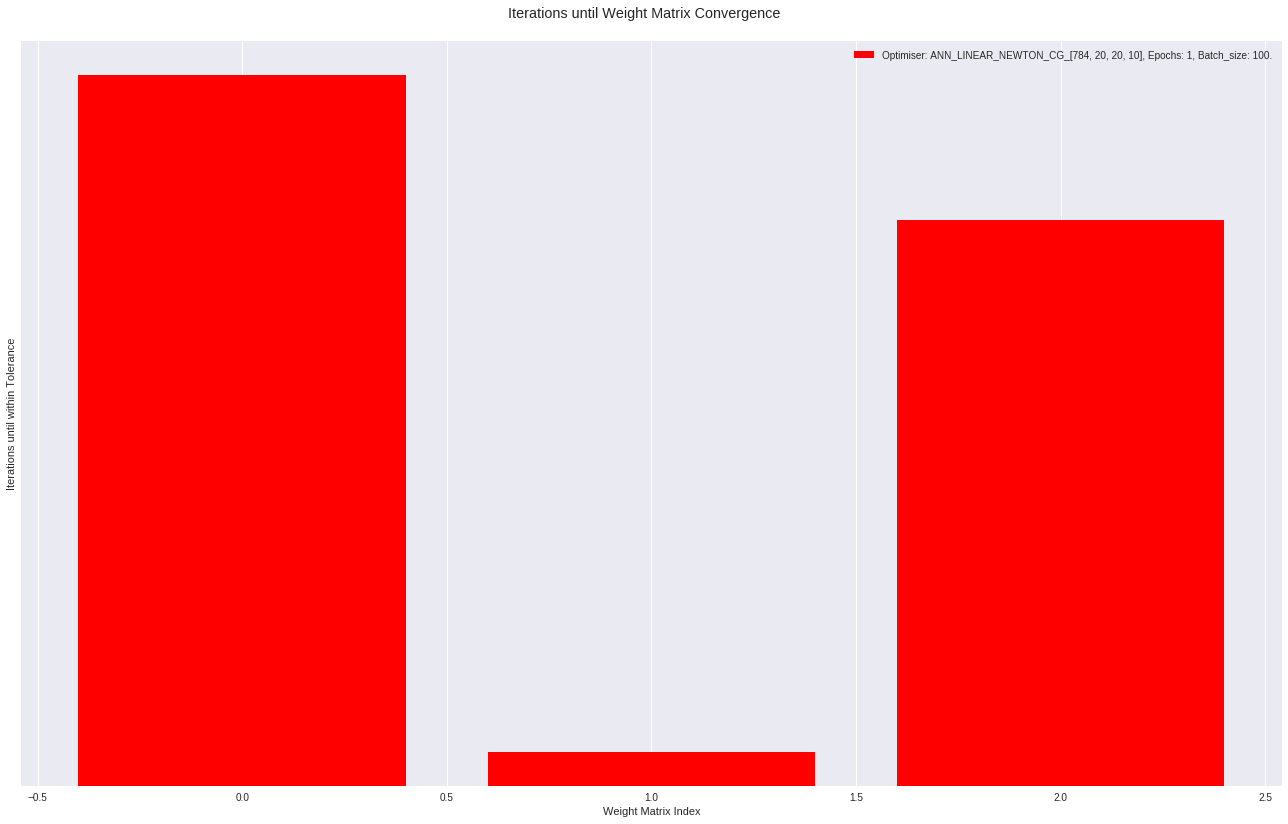

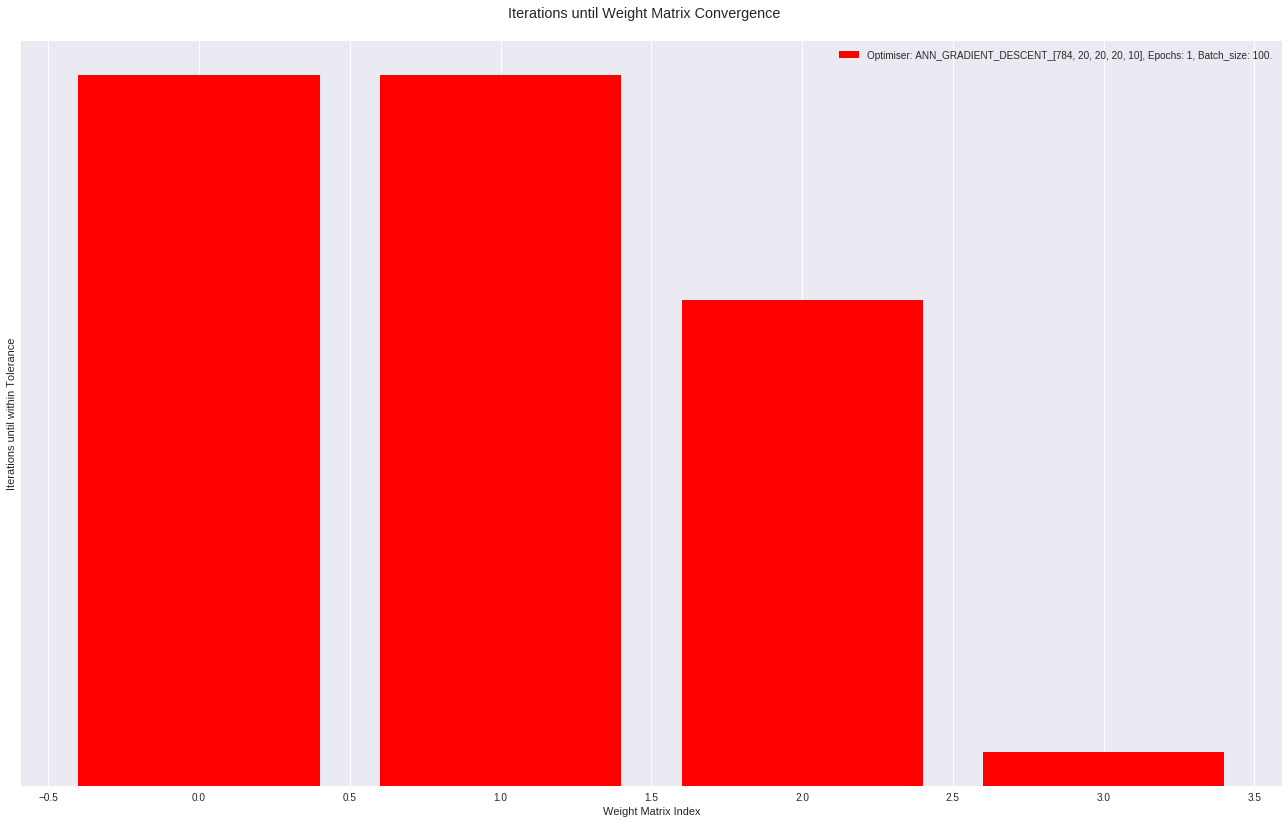

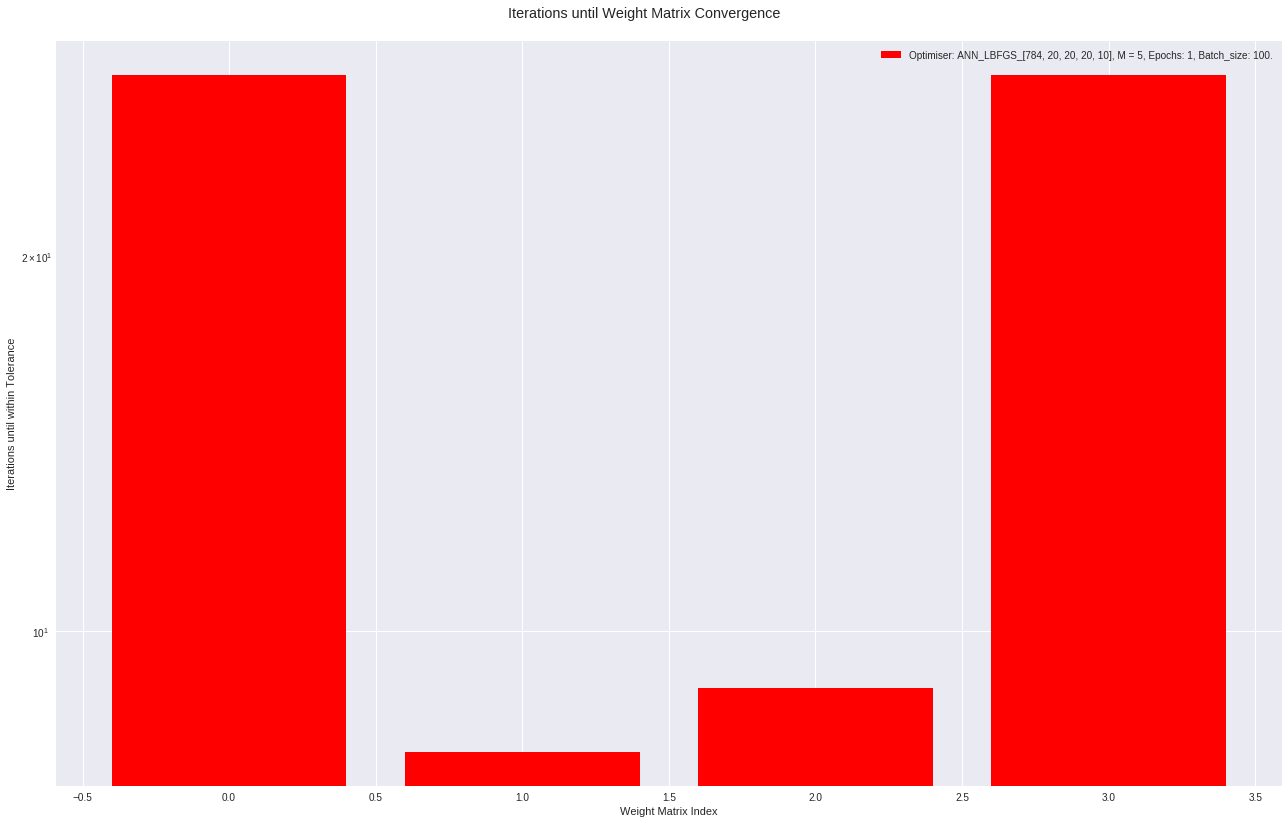

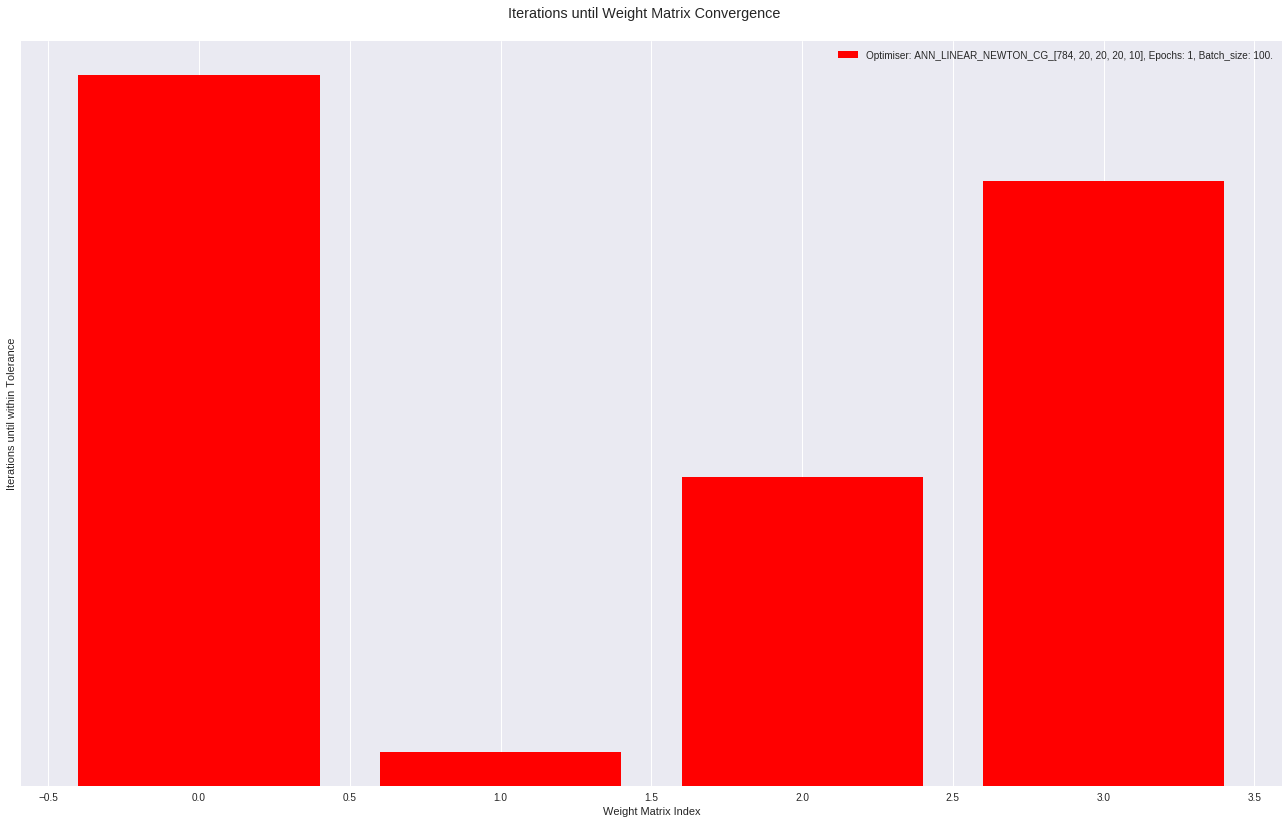

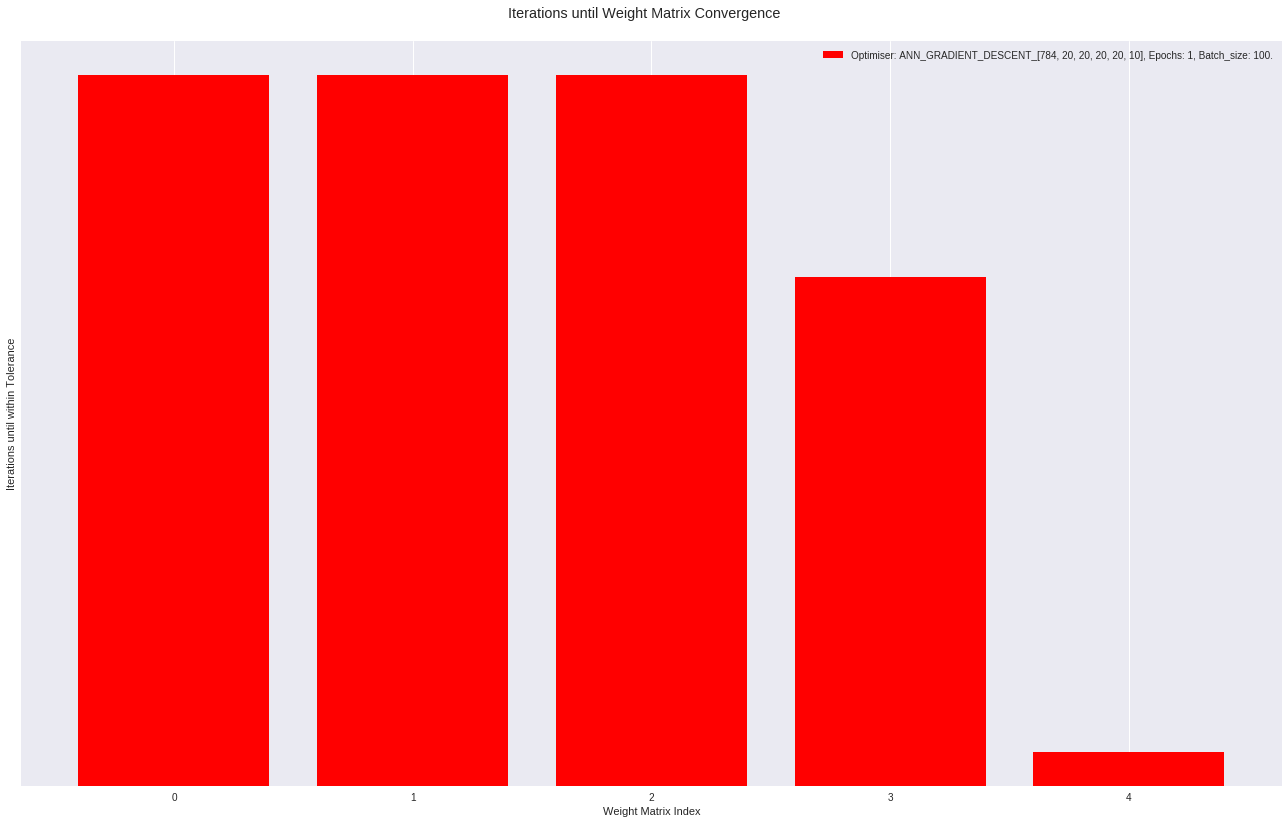

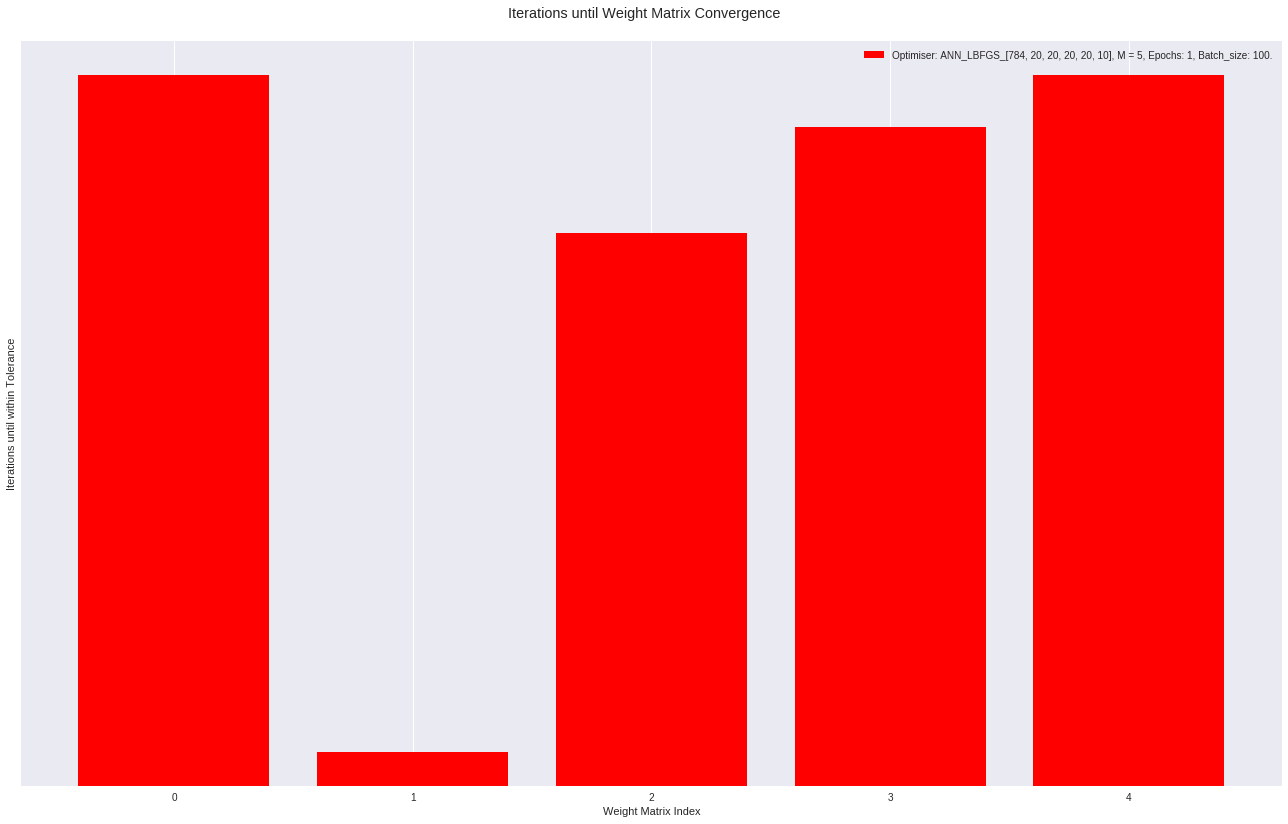

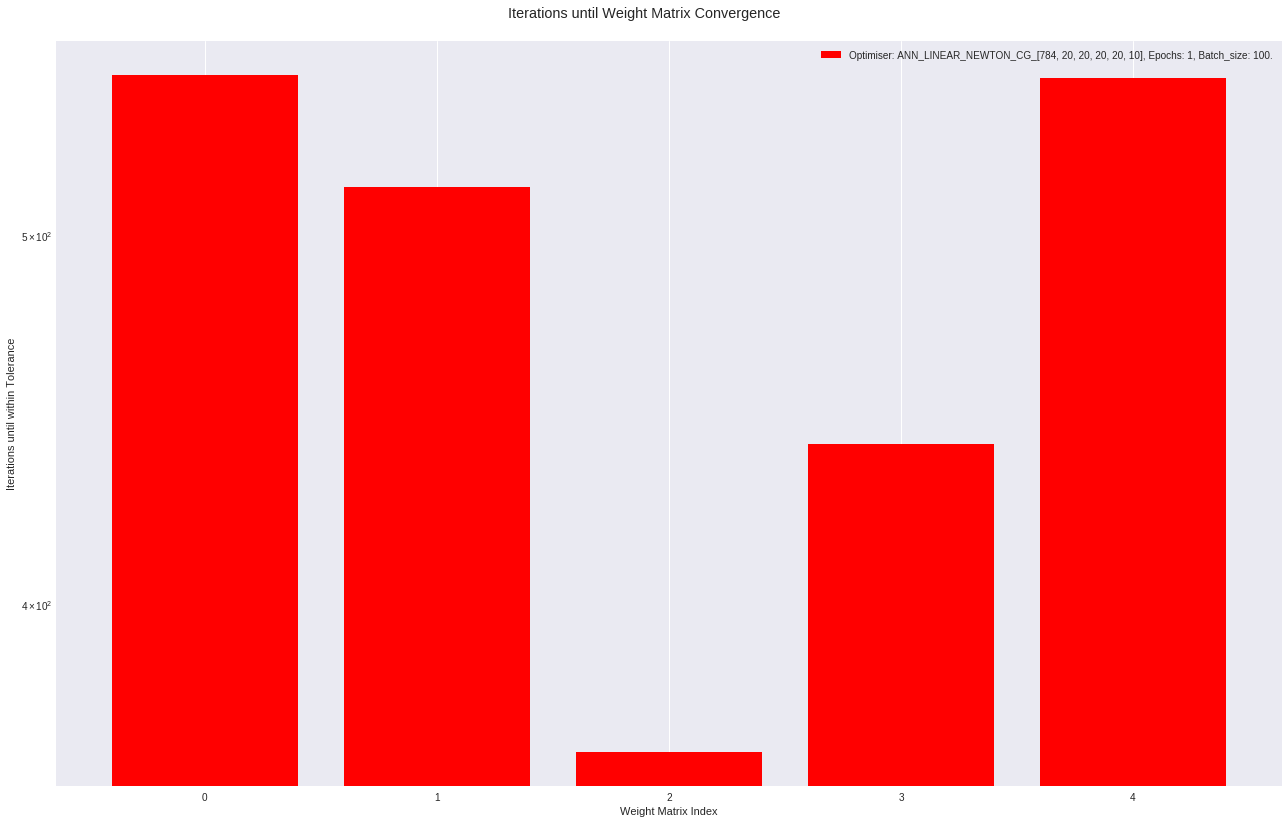

In [41]:
plot_learning_curves(experiment_results)
plot_loss(experiment_results)
plot_step(experiment_results)
plot_toleranceConverge(experiment_results)

# Variation of Mini-batch size

In [0]:
# CAREFUL: Running this CL resets the experiments_task1 dictionary where results should be stored.
# Store results of runs with different configurations in a dictionary.
# Use a tuple (num_epochs, learning_rate) as keys, and a tuple (training_accuracy, testing_accuracy)

num_epochs = 1


batch_one_Models = [ANN_GRADIENT_DESCENT(batchSize=1,
                     layers=[784,20,10]),
                   ANN_LBFGS(5,
                    batchSize=1,
                    layers=[784,20,10]),
                   ANN_LINEAR_NEWTON_CG(1000000,
                               batchSize=1,
                               layers=[784,20,10])]


batch_oneH_Models = [ANN_GRADIENT_DESCENT(batchSize=100,
                    layers=[784,20,10]),
                  ANN_LBFGS(5,
                    batchSize=100,
                    layers=[784,20,10]),
                  ANN_LINEAR_NEWTON_CG(1000000,
                               batchSize=100,
                               layers=[784,20,10])]


batch_oneT_Models = [ANN_GRADIENT_DESCENT(batchSize=1000,
                      layers=[784,20,10]),
                    ANN_LBFGS(5,
                      batchSize=1000,
                      layers=[784,20,10]),
                    ANN_LINEAR_NEWTON_CG(1000000,
                                 batchSize=1000,
                                 layers=[784,20,10]),
                    ANN_NEWTON_CG_STEIHAUG(1000000,1.e-5,0.0005,1.,
                               batchSize=1000,
                               layers=[784,20,10],step=trustRegion)]

batch_oneTT_Models = [ANN_GRADIENT_DESCENT(batchSize=10000,
                      layers=[784,20,10]),
                    ANN_LBFGS(5,
                      batchSize=10000,
                      layers=[784,20,10]),
                    ANN_LINEAR_NEWTON_CG(1000000,
                                 batchSize=10000,
                                 layers=[784,20,10]),
                     ANN_NEWTON_CG_STEIHAUG(1000000,1.e-5,0.0005,1.,
                               batchSize=10000,
                               layers=[784,20,10],step=trustRegion)]

experiments = [batch_one_Models, batch_oneH_Models, batch_oneT_Models, batch_oneTT_Models]
experiment_results = [[], [], [], []]

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 10000
Iteration: 20000
Iteration: 30000
Iteration: 40000
Iteration: 50000
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 10000
Iteration: 20000
Iteration: 30000
Iteration: 40000
Iteration: 500

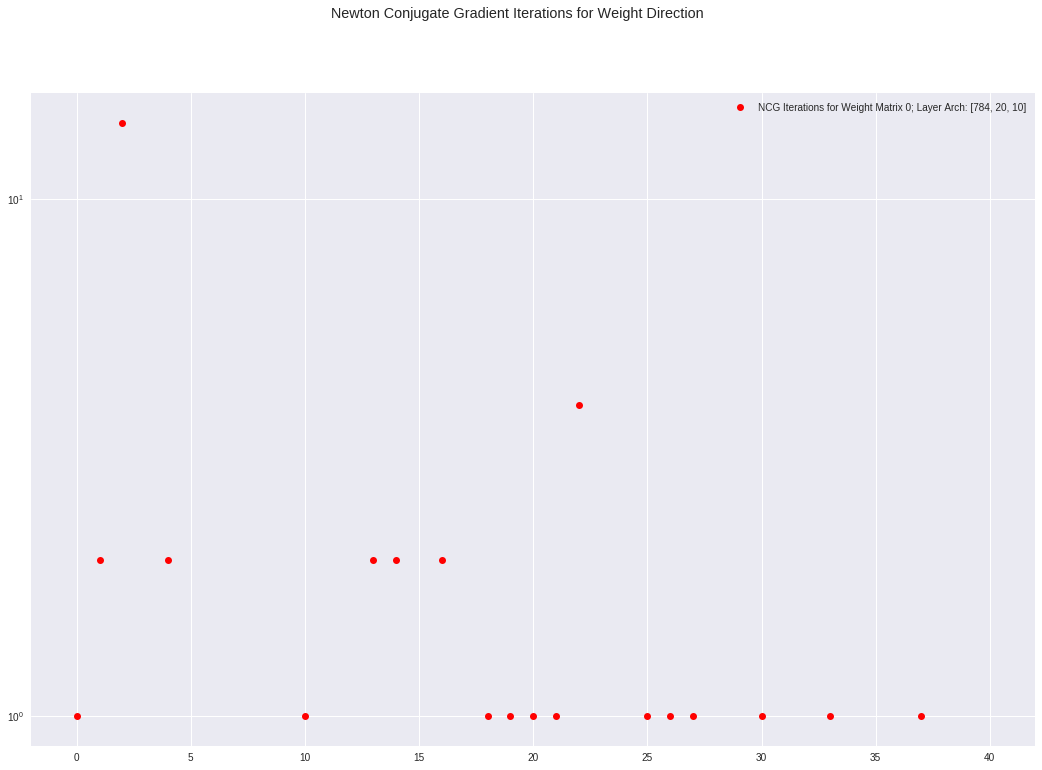

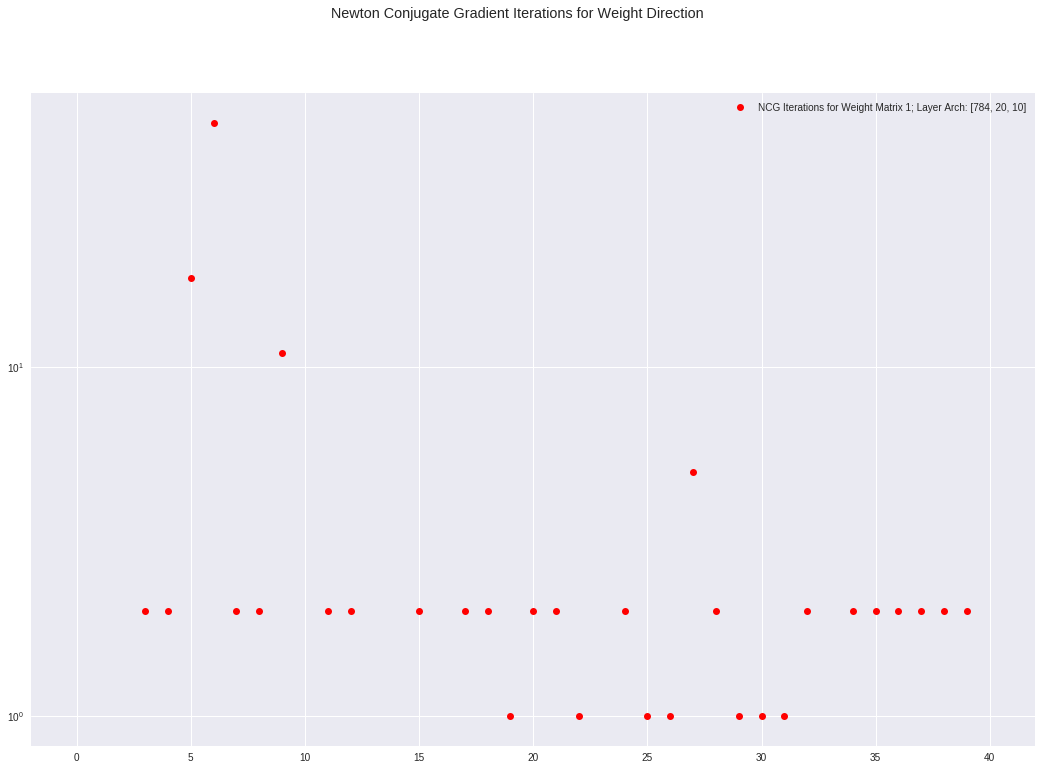

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LINEAR_NEWTON

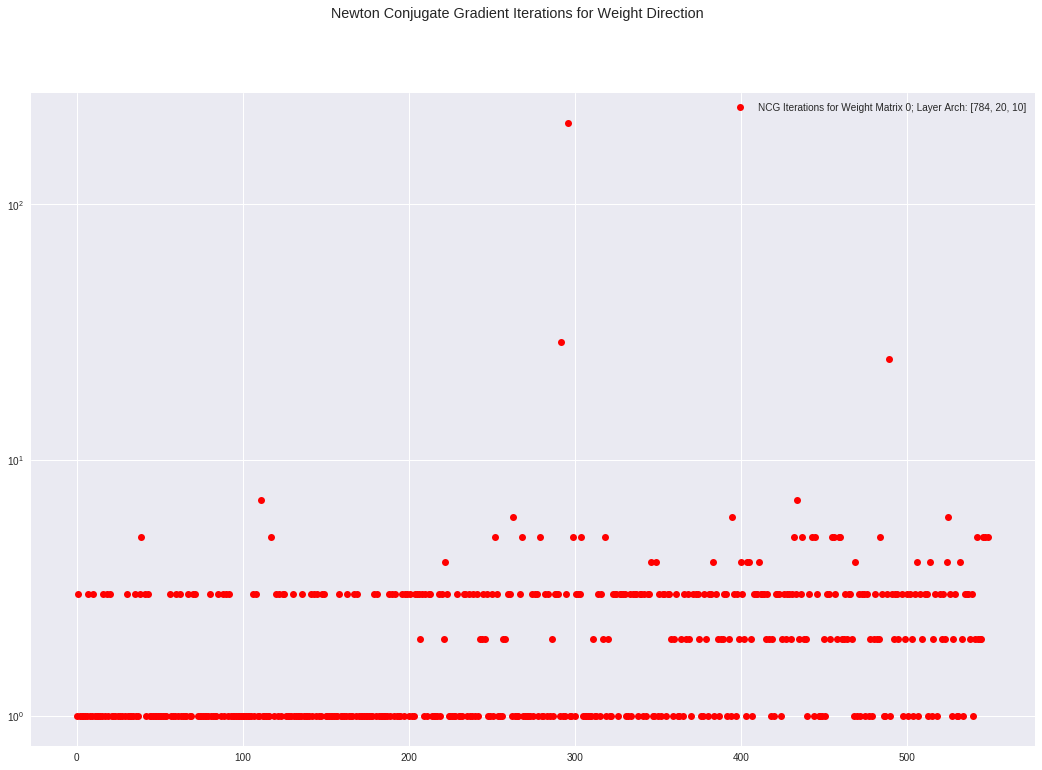

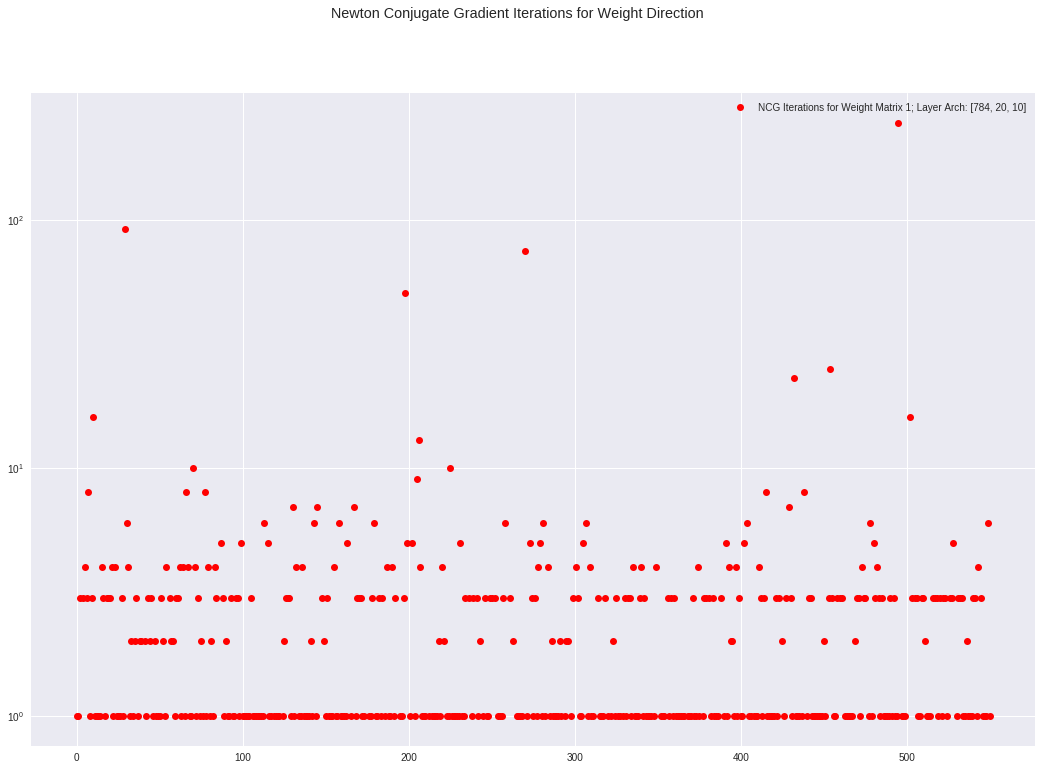

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
ANN_LINEAR_NEWTON_CG
Extrac

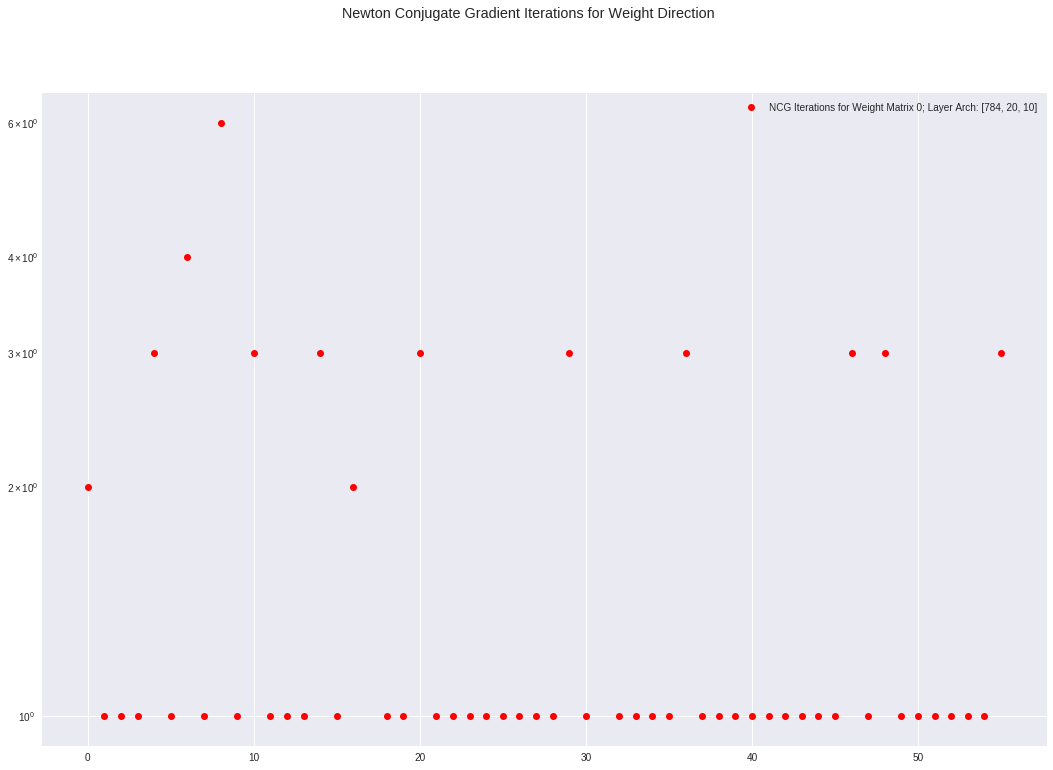

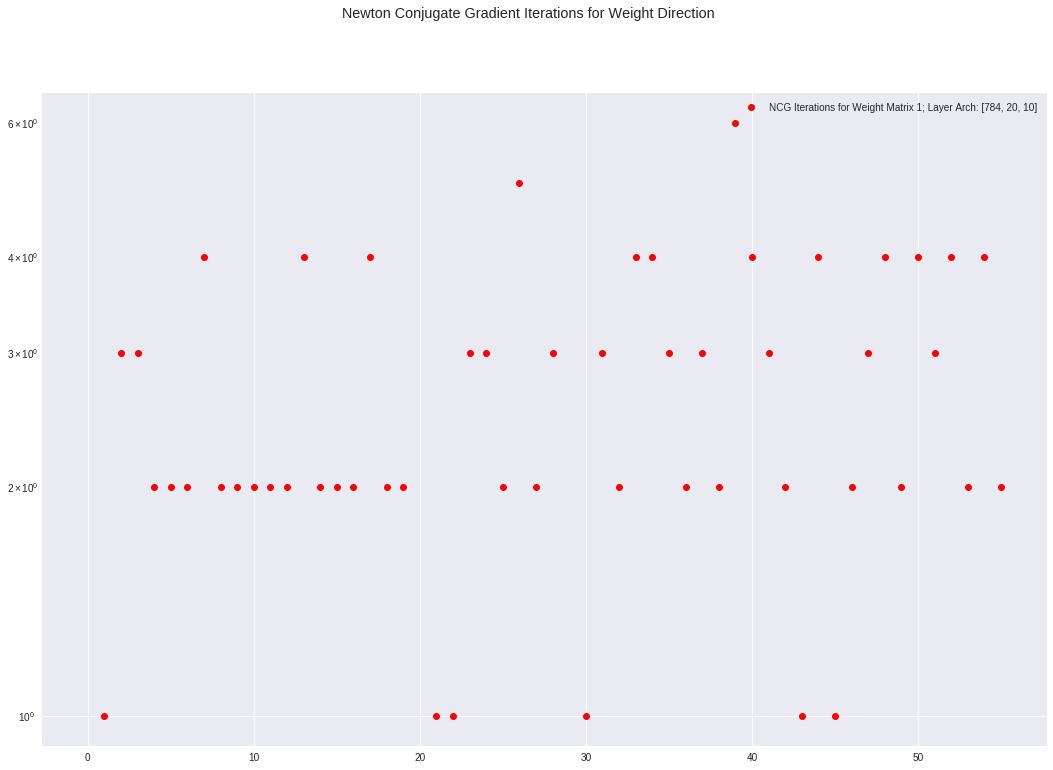

ANN_NEWTON_CG_STEIHAUG
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 10
Iteration: 20


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in divide


Iteration: 30
Iteration: 40
Iteration: 50


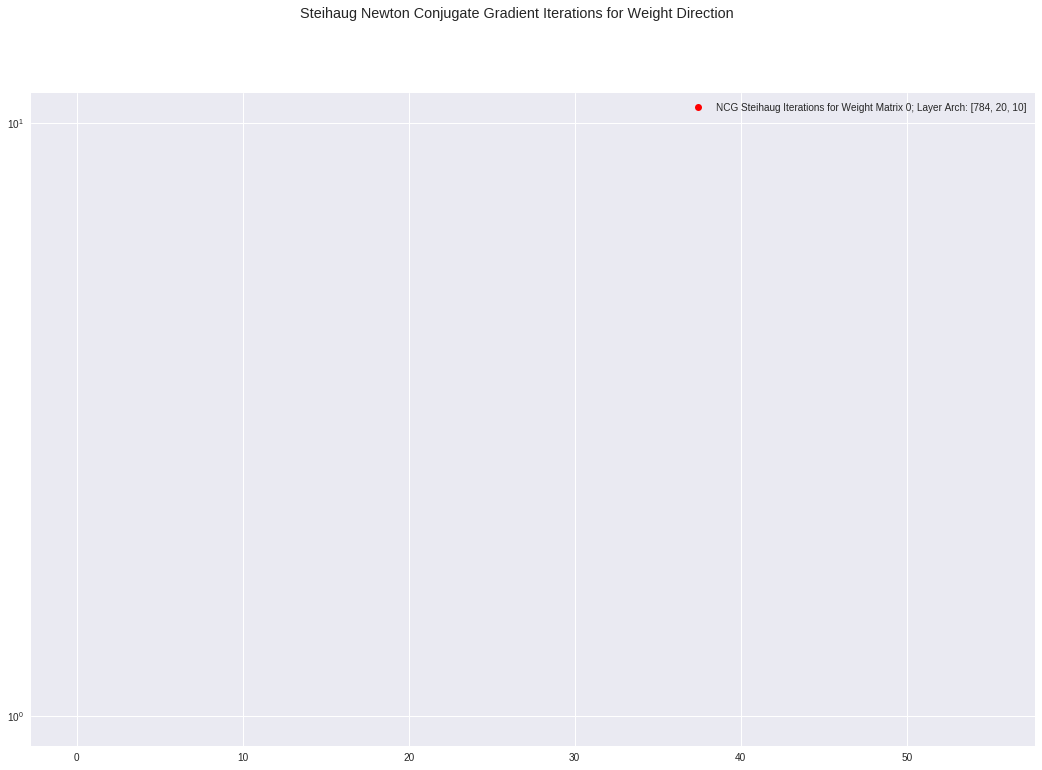

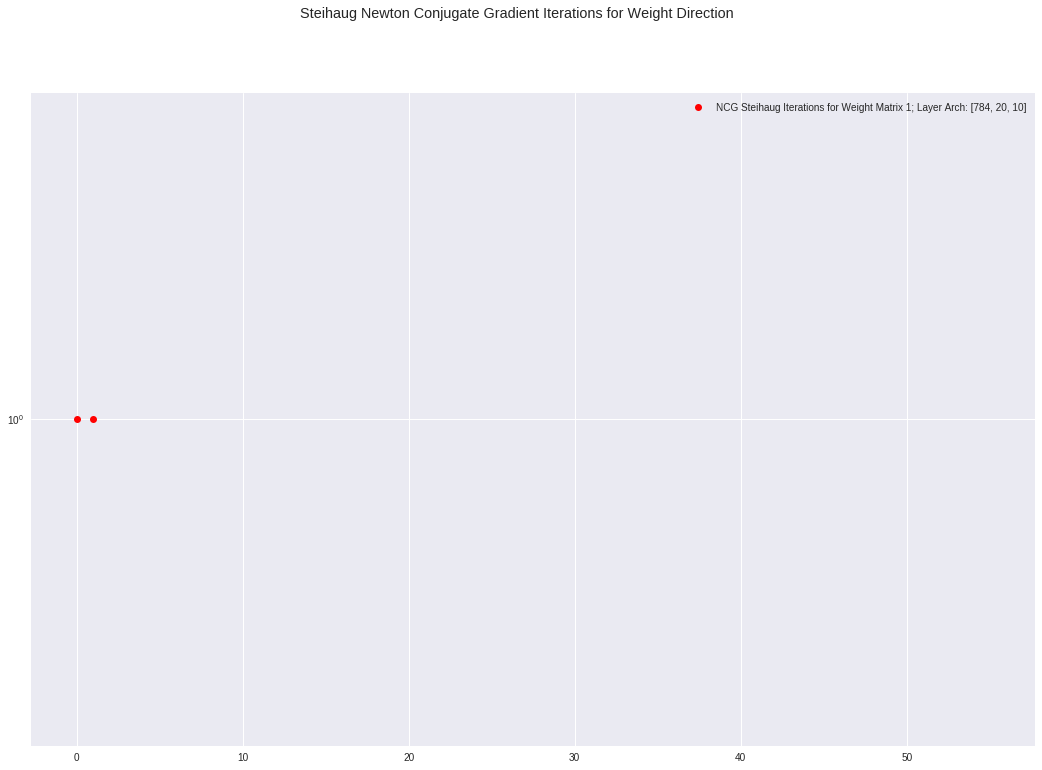

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
ANN_LINEAR_NEWTON_CG
Extracting MNIST

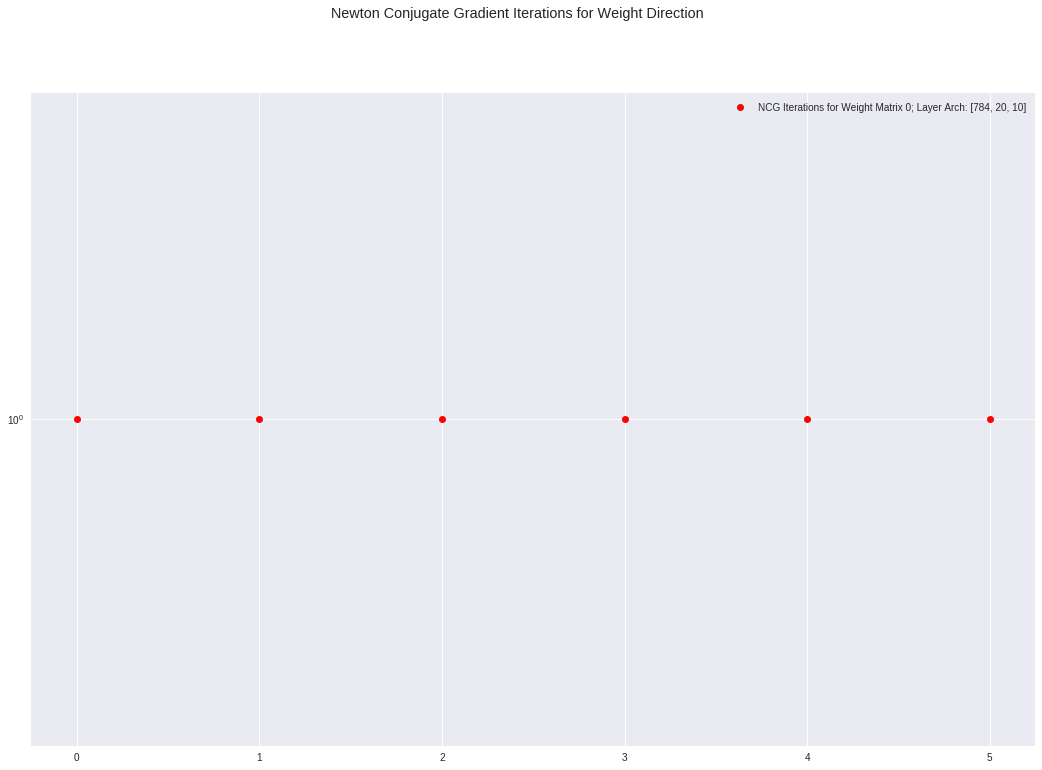

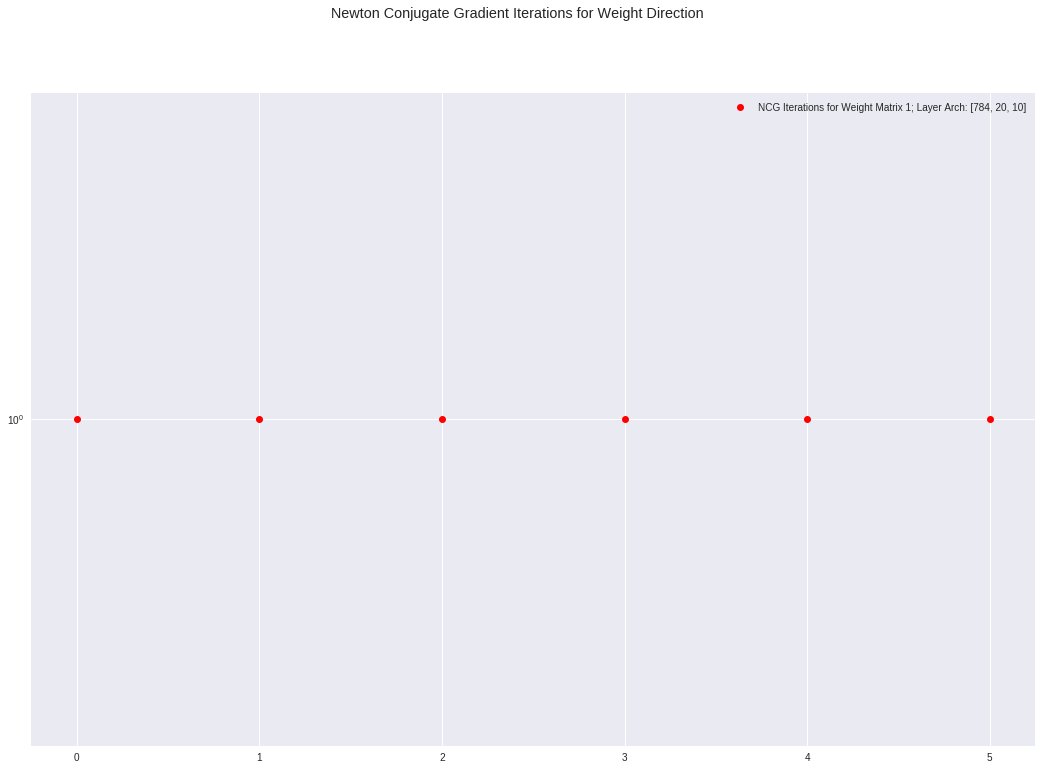

ANN_NEWTON_CG_STEIHAUG
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


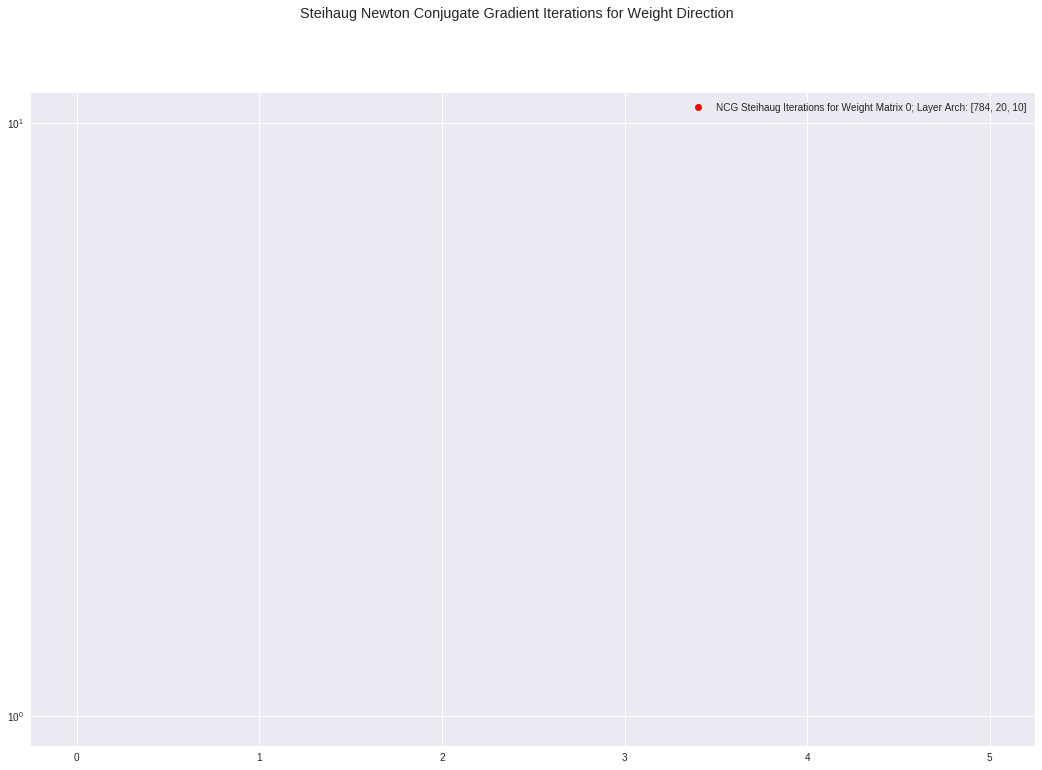

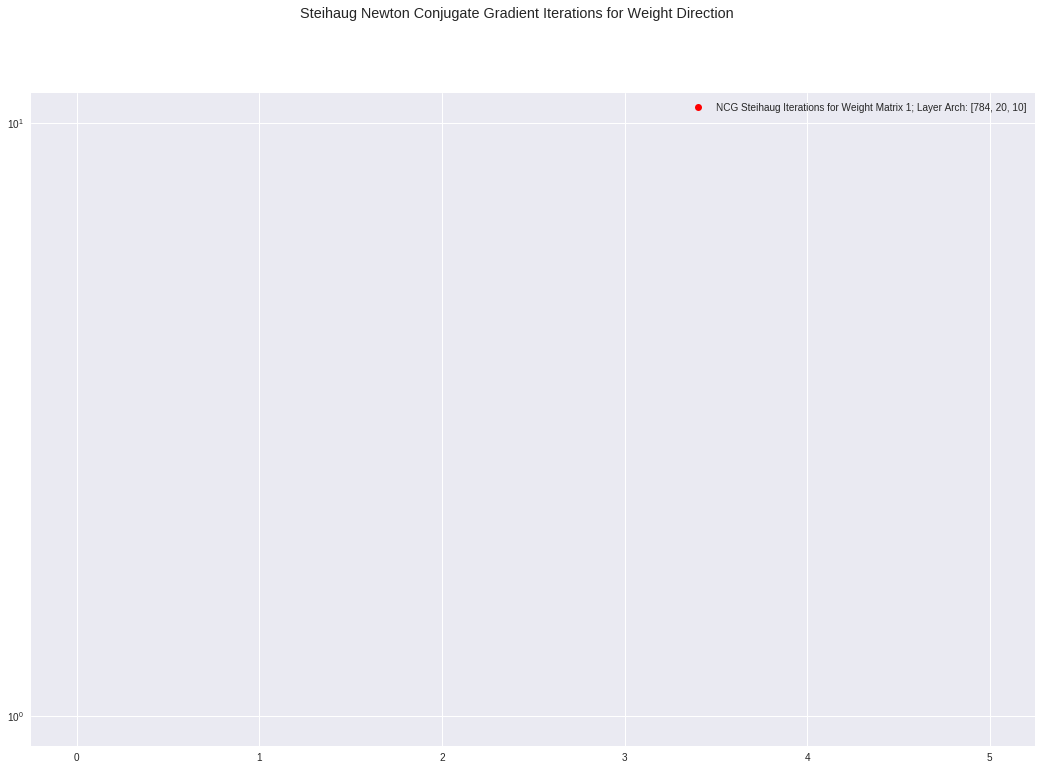

In [54]:
for idm,models in enumerate(experiments):
  while len(models) != 0:
    name = models[0].__class__.__name__ 
    print name

    # Reset graph, recreate placeholders and dataset.
    mnist = get_data()
    eval_mnist = get_data()

    #####################################################
    # Define model, loss, update and evaluation metric. #
    #####################################################

    ann = models[0]    
    batch_size = ann.batchSize

    del models[0]

    # Train.
    i, train_accuracy, test_accuracy, losses, step_sizes = -1, [], [], [], []
    log_period_updates = int(log_period_samples / batch_size)
    while mnist.train.epochs_completed < num_epochs:

      # Update.
      i += 1
      batch_xs, batch_ys = mnist.train.next_batch(batch_size)

      if i==0:
        losses.append(ann.xEnt(0,batch_ys,0,0,batch_xs/255.))

      #################
      # Training step #
      #################
      
      res = ann.backprop(batch_ys, ann.forward(batch_xs/255.), batch_xs/255.)
      losses.append(ann.xEnt(0,batch_ys,0,0,batch_xs/255.))

      # Periodically evaluate.
      if i % log_period_updates == 0:
        print 'Iteration: ' + str(i)
        #####################################
        # Compute and store train accuracy. #
        #####################################

        out = ann.forward(batch_xs/255.)

        prediction = np.argmax(out, axis=1)
        truth = np.argmax(batch_ys, axis=1)

        correct = 0.
        for a,b in zip(prediction,truth):
          if a == b:
            correct += 1.

        train_accuracy.append(correct/(batch_ys.shape[0]))
        #####################################
        # Compute and store test accuracy. #
        #####################################
        test_xs, test_ys = mnist.test.images, mnist.test.labels

        out = ann.forward(test_xs/255.)

        prediction = np.argmax(out, axis=1)
        truth = np.argmax(test_ys, axis=1)

        correct = 0.
        for a,b in zip(prediction,truth):
          if a == b:
            correct += 1.

        test_accuracy.append(correct/test_ys.shape[0])
        
      #if res == 'converged':
      #  break
      #else:
      step_sizes.append(res)

    name += '_' + str(ann.layers)
    if 'BFGS' in name:
      name += ', M = ' + str(ann.M)
      
    if 'CG_STEIHAUG' in name:
      for idx,iterList in enumerate(ann.NCG_Iterations[:-1]):
        fig = plt.figure(figsize=(18,12))
        st = fig.suptitle(
            "Steihaug Newton Conjugate Gradient Iterations for Weight Direction",
            fontsize="x-large")
        plt.yscale('log')
        #print iterList
        plt.plot(iterList, linestyle='None', marker='o', label='NCG Steihaug Iterations for Weight Matrix ' + str(idx) + '; Layer Arch: ' + str(ann.layers))
        plt.legend()
        plt.show()
    elif 'CG' in name:
      for idx,iterList in enumerate(ann.NCG_Iterations[:-1]):
        fig = plt.figure(figsize=(18,12))
        st = fig.suptitle(
            "Newton Conjugate Gradient Iterations for Weight Direction",
            fontsize="x-large")
        #print iterList
        plt.yscale('log')
        plt.plot(iterList, linestyle='None', marker='o', label='NCG Iterations for Weight Matrix ' + str(idx) + '; Layer Arch: ' + str(ann.layers))
        plt.legend()
        plt.show()
      
    experiment_results[idm].append(
        ((name, num_epochs, ann.batchSize), train_accuracy, test_accuracy, losses, step_sizes, ann.layerIterCount[:-1]))
  

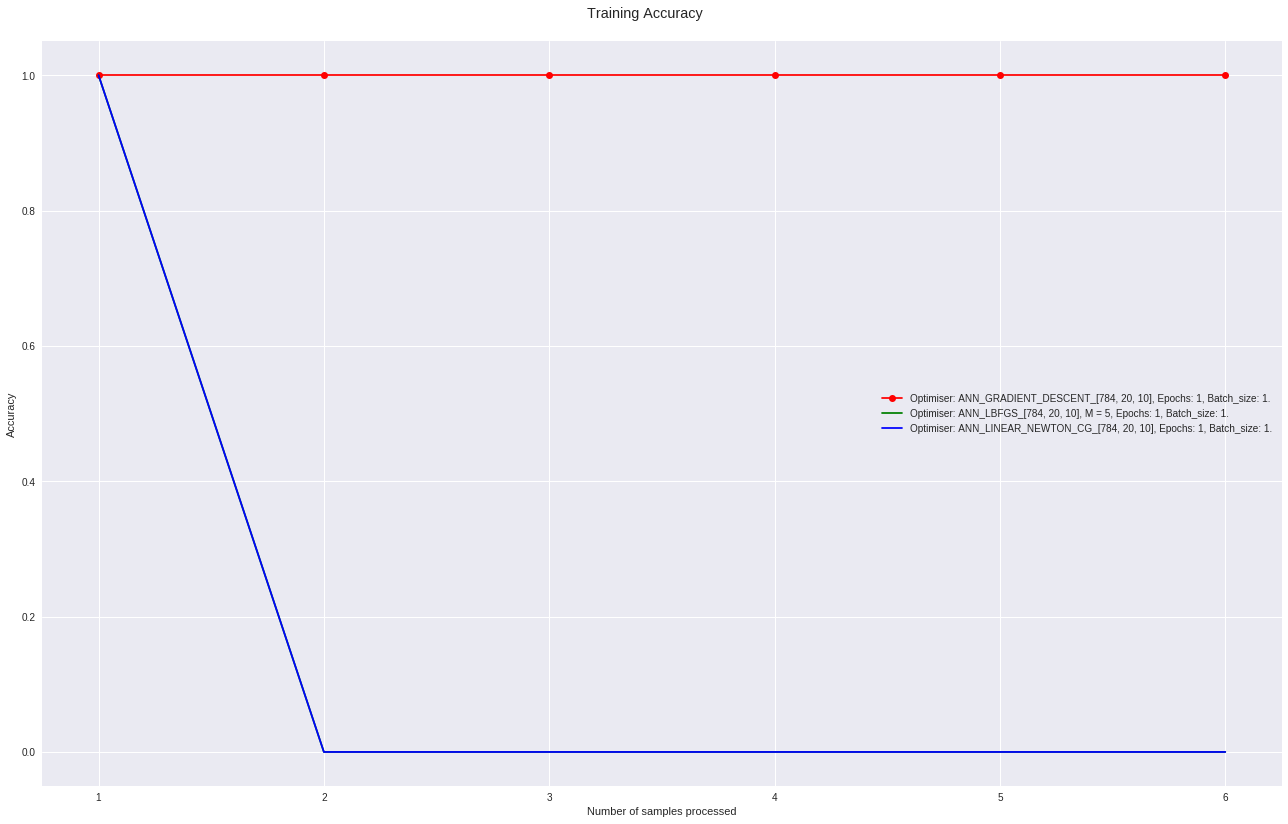

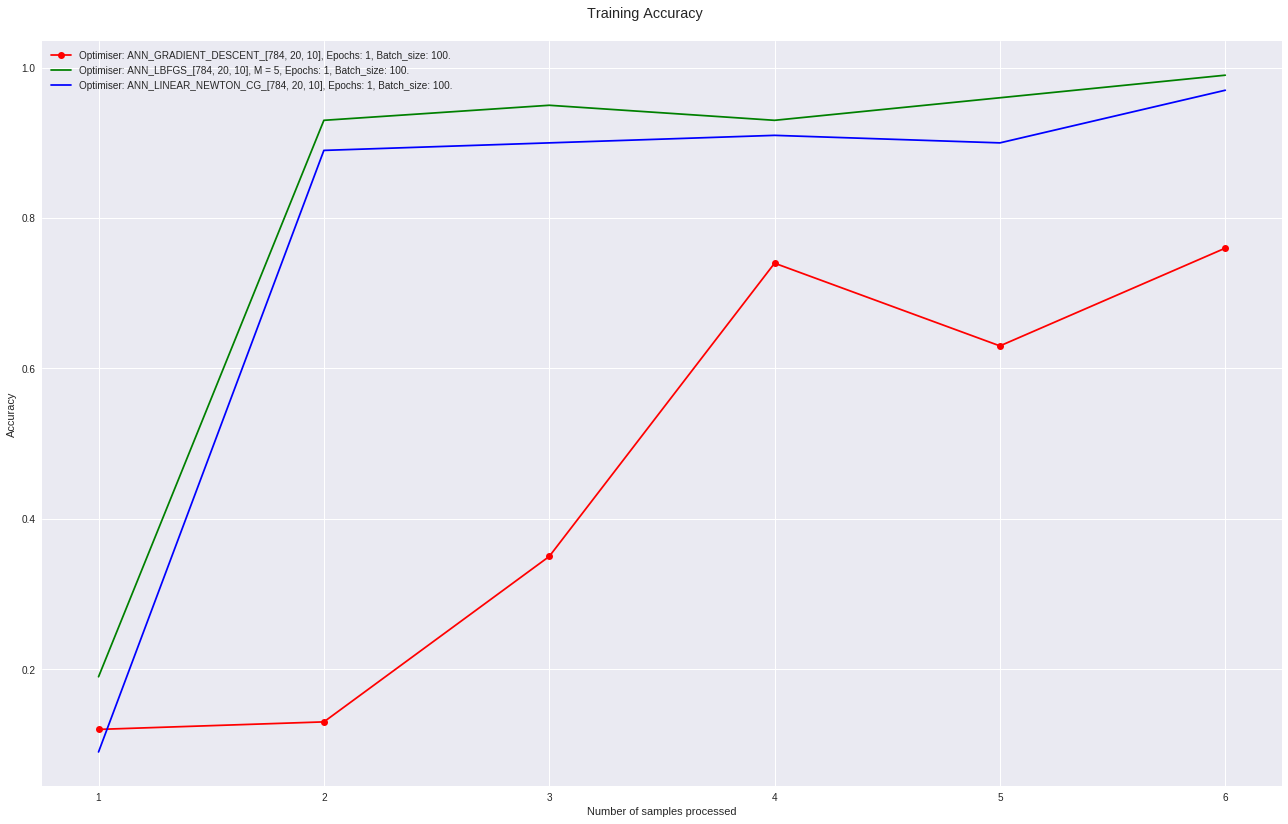

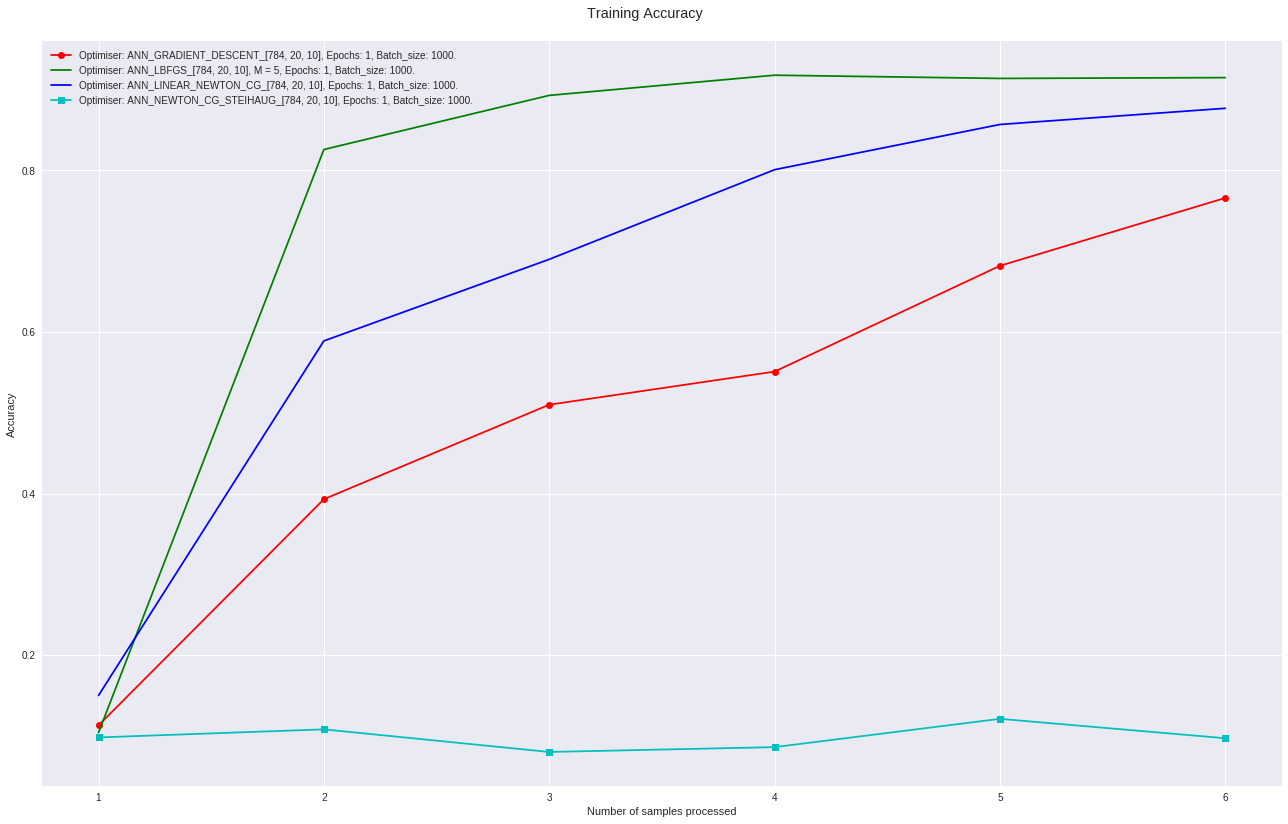

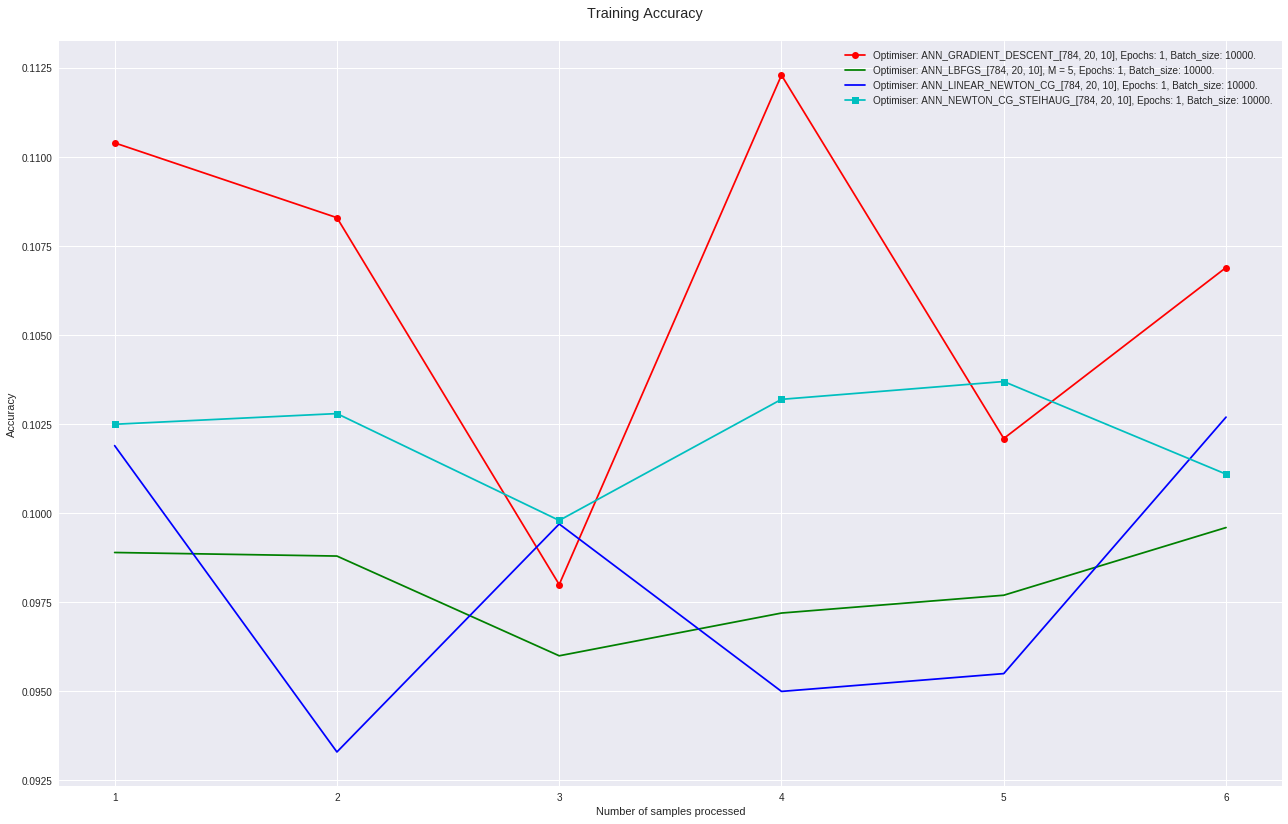

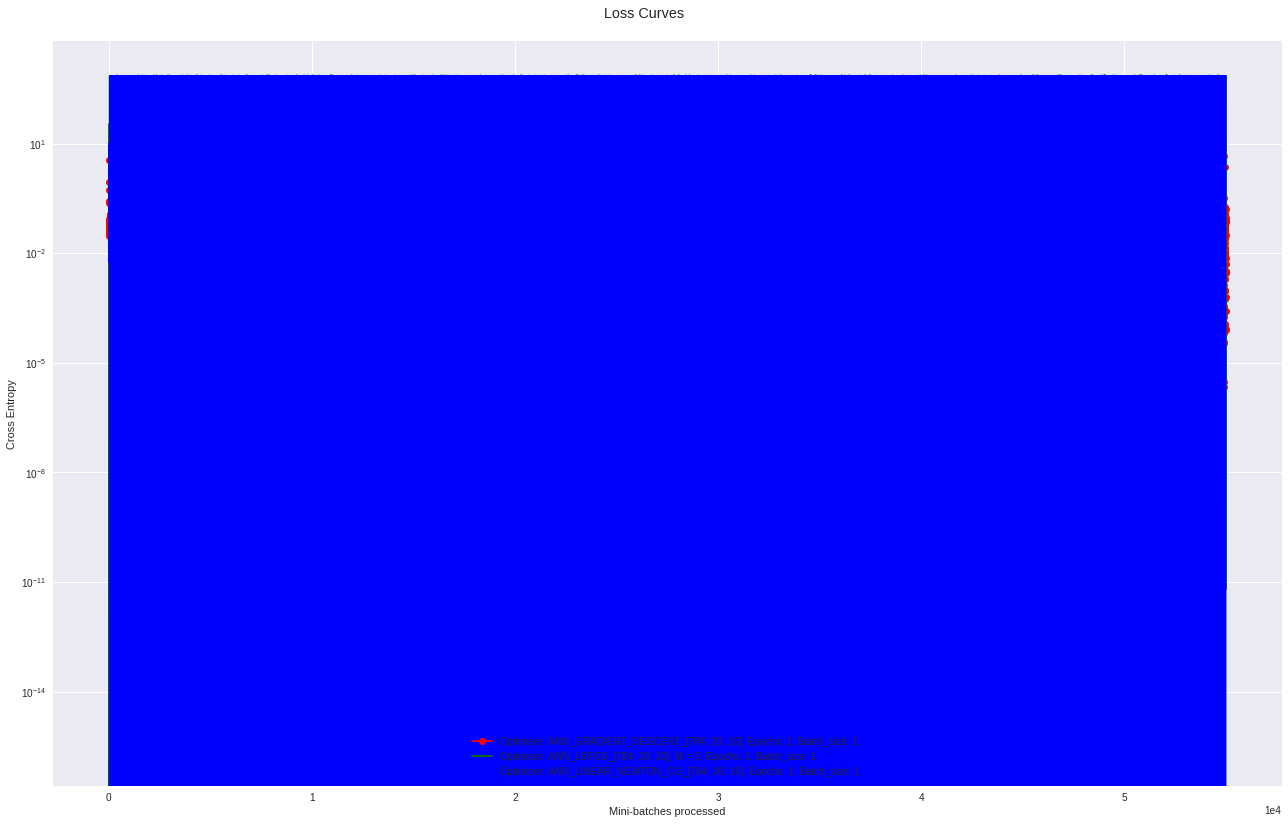

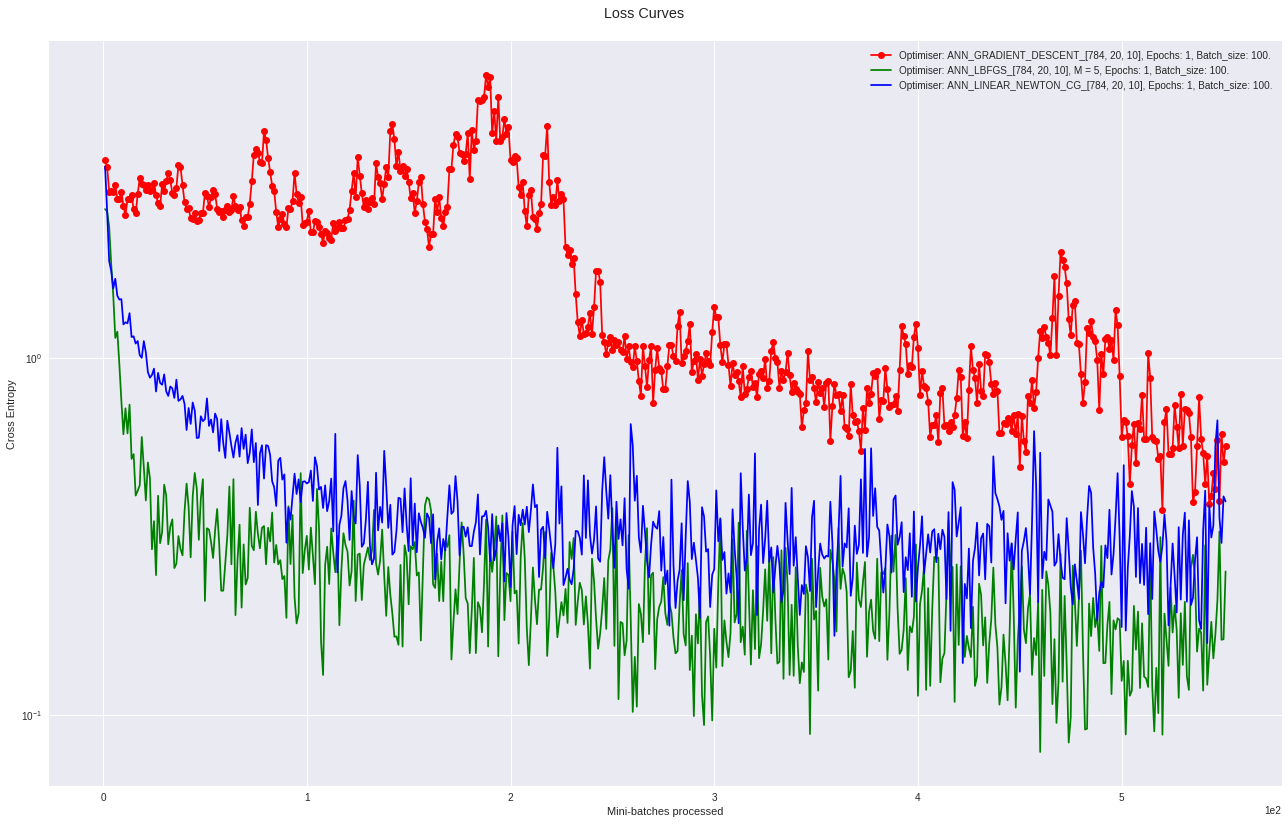

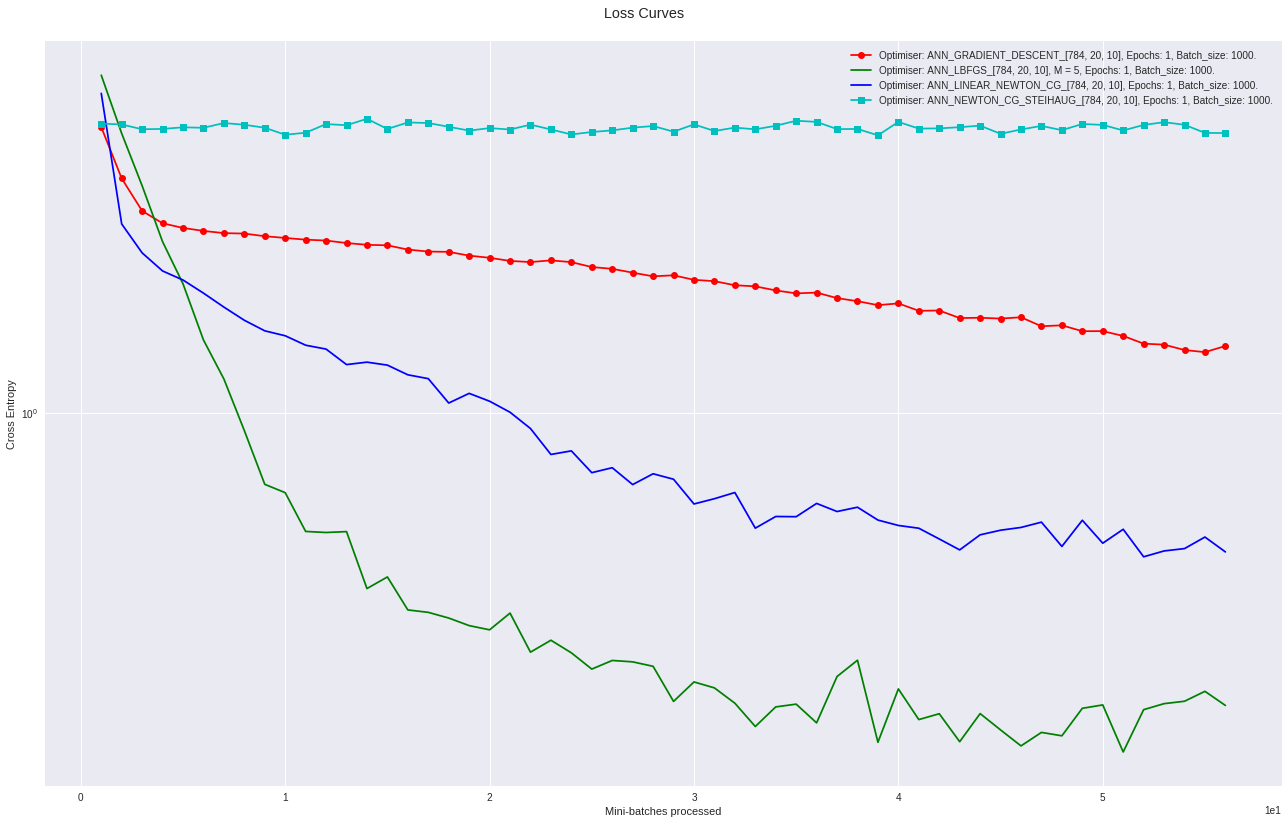

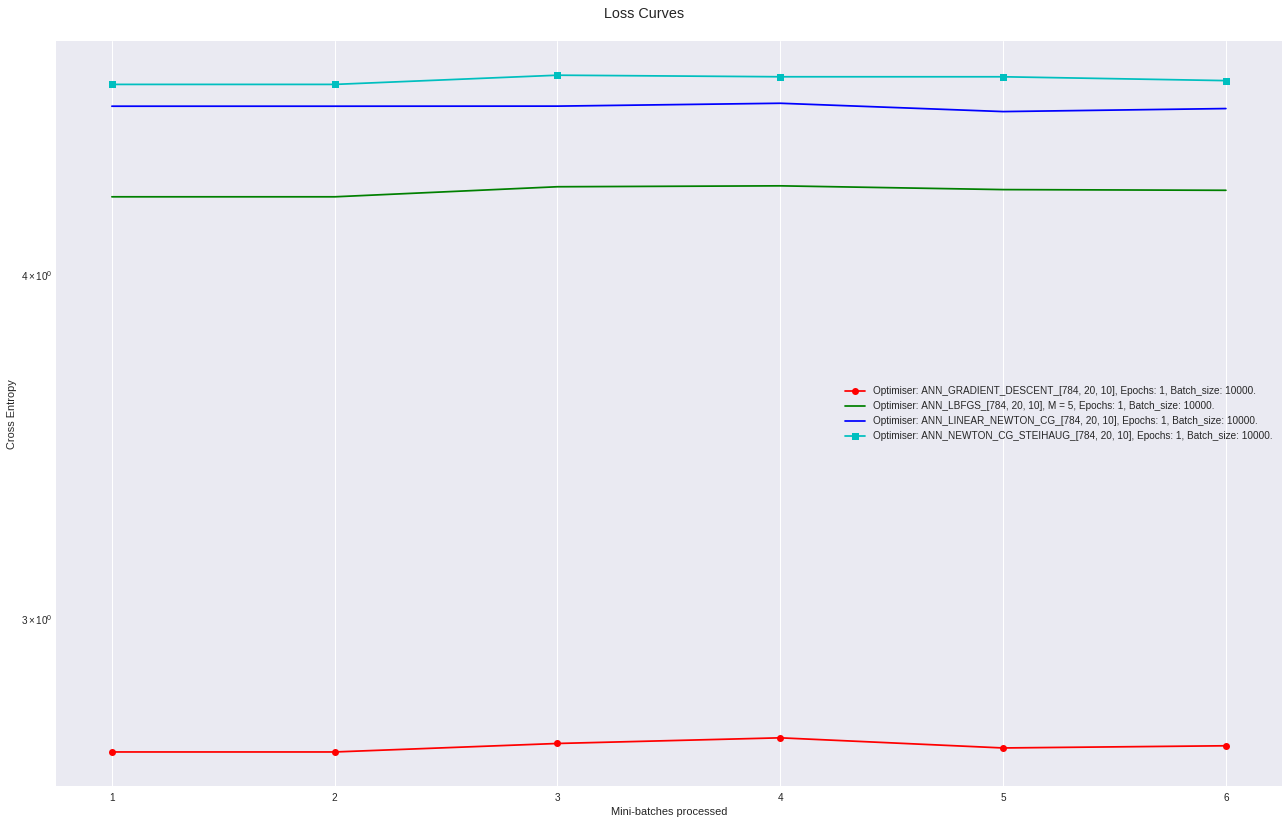

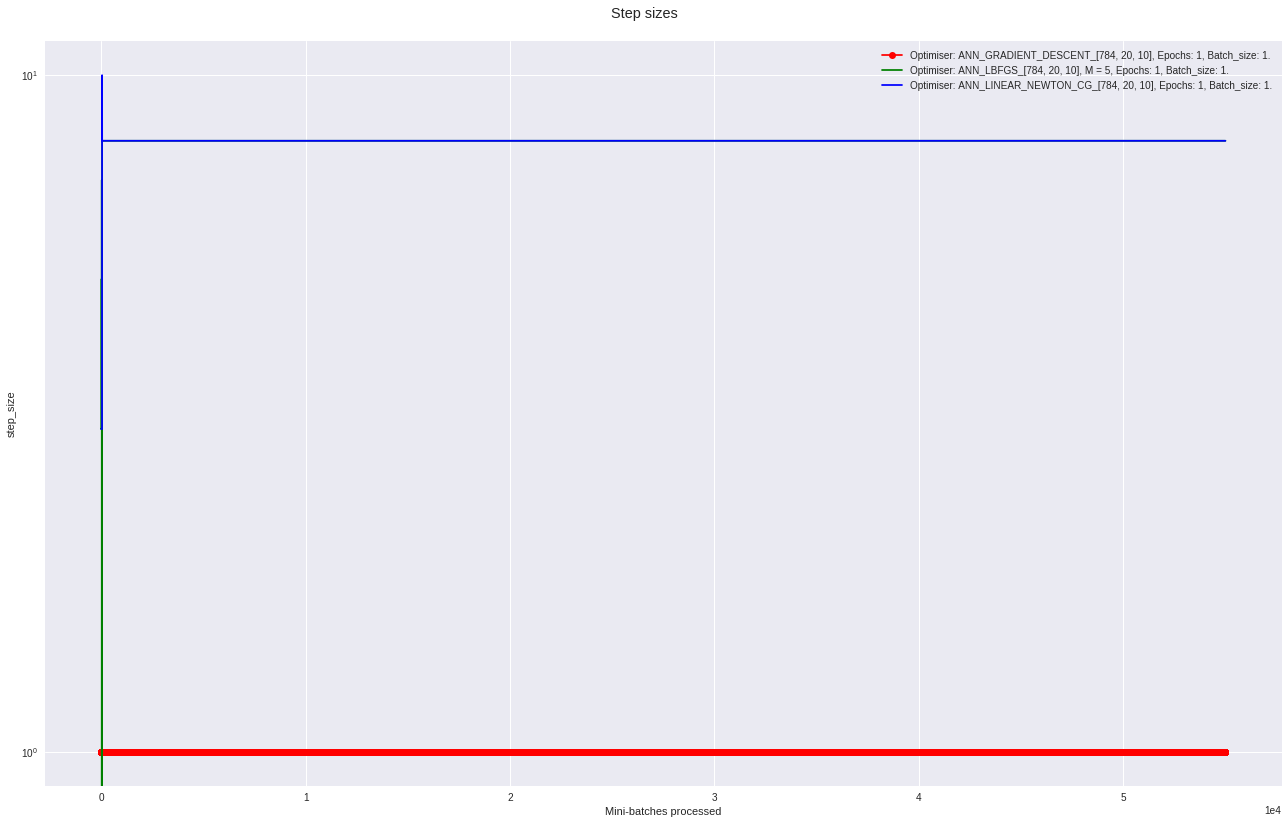

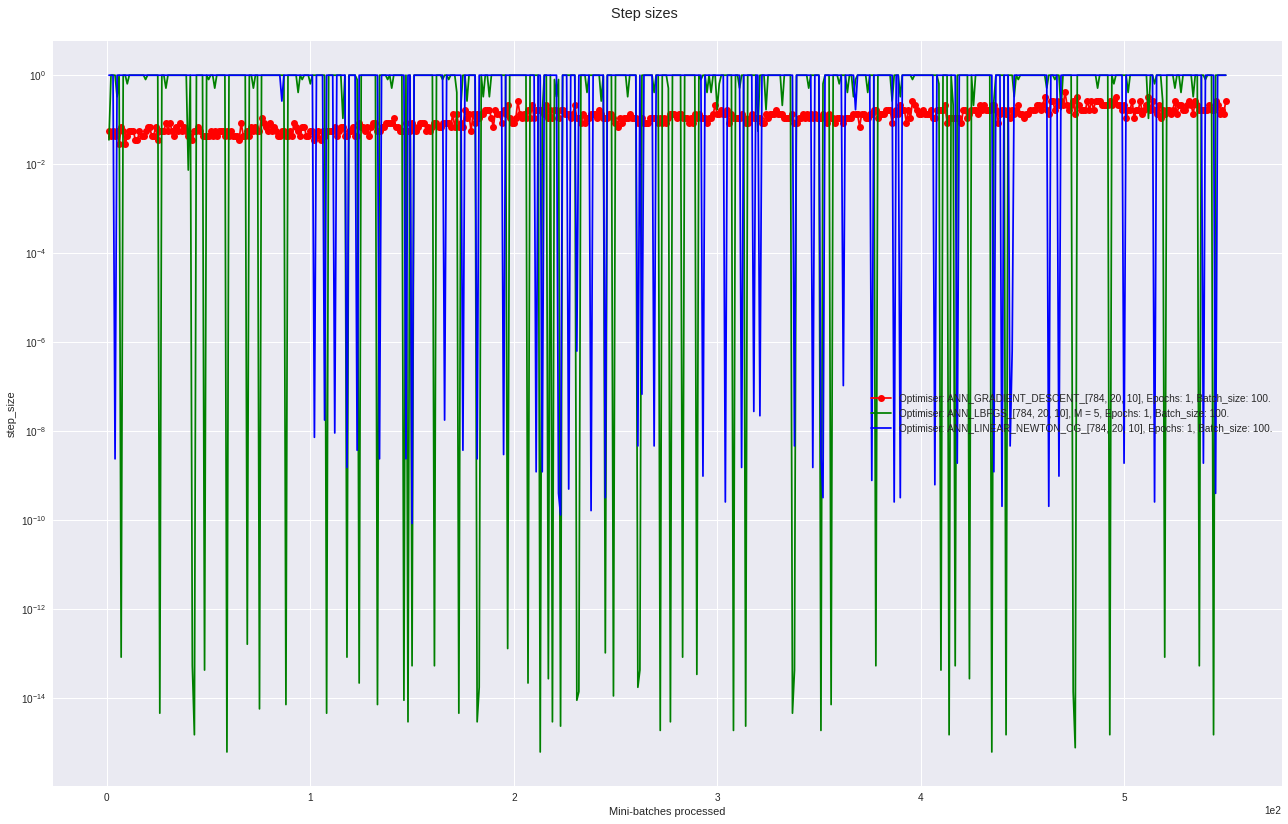

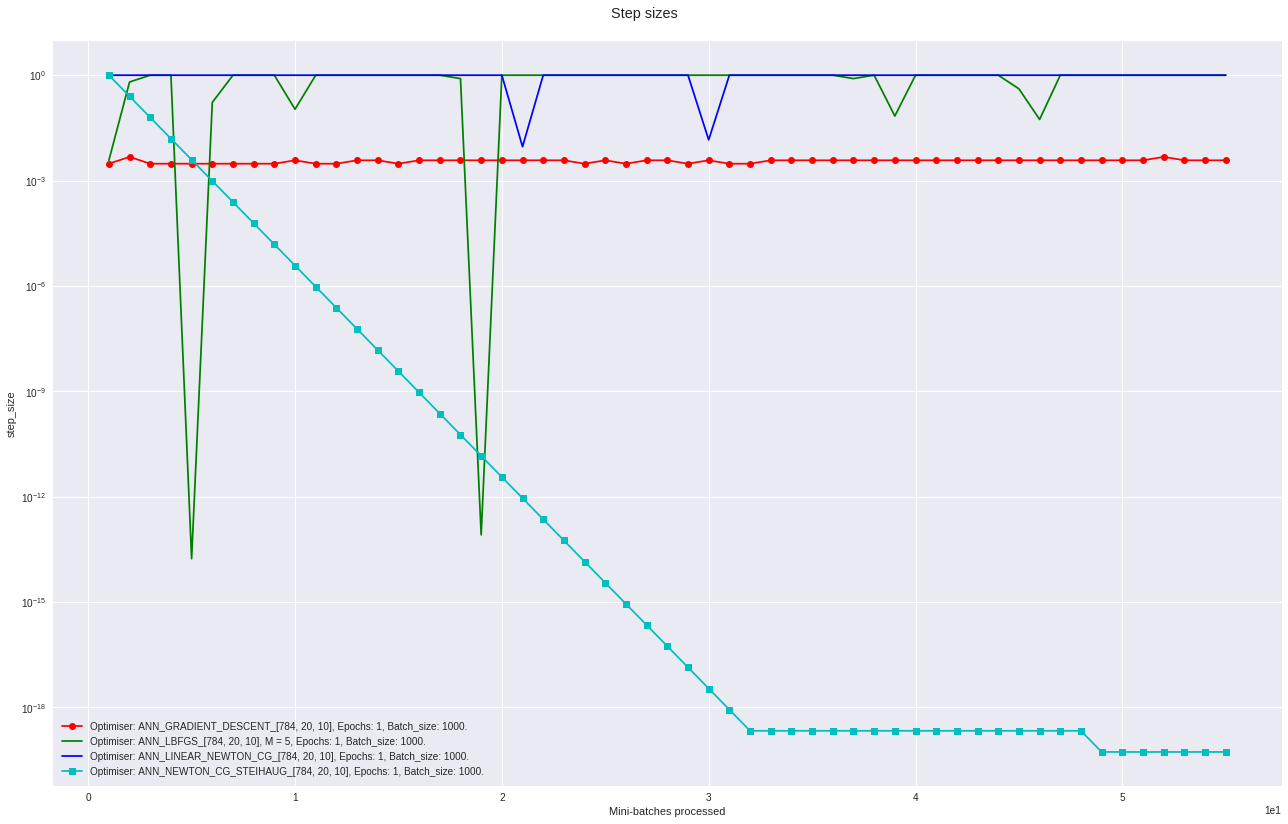

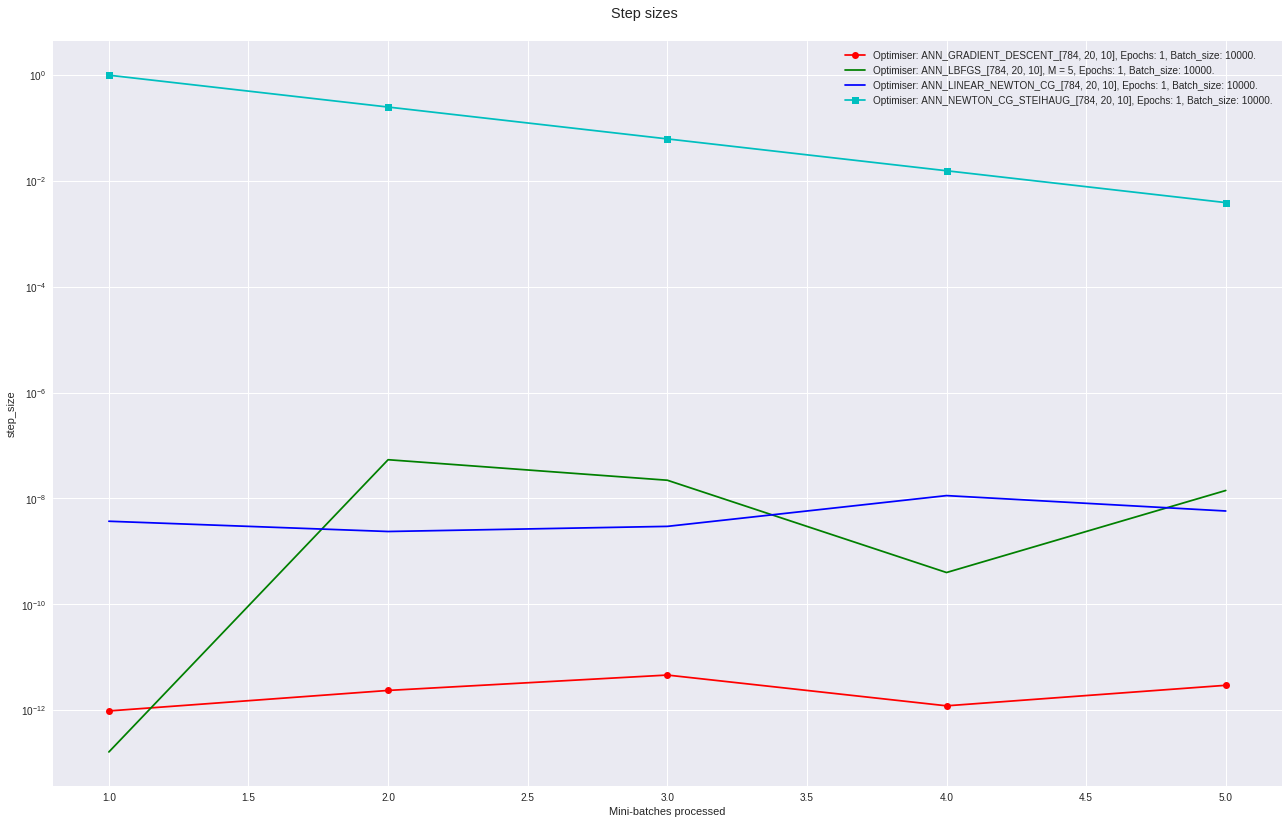

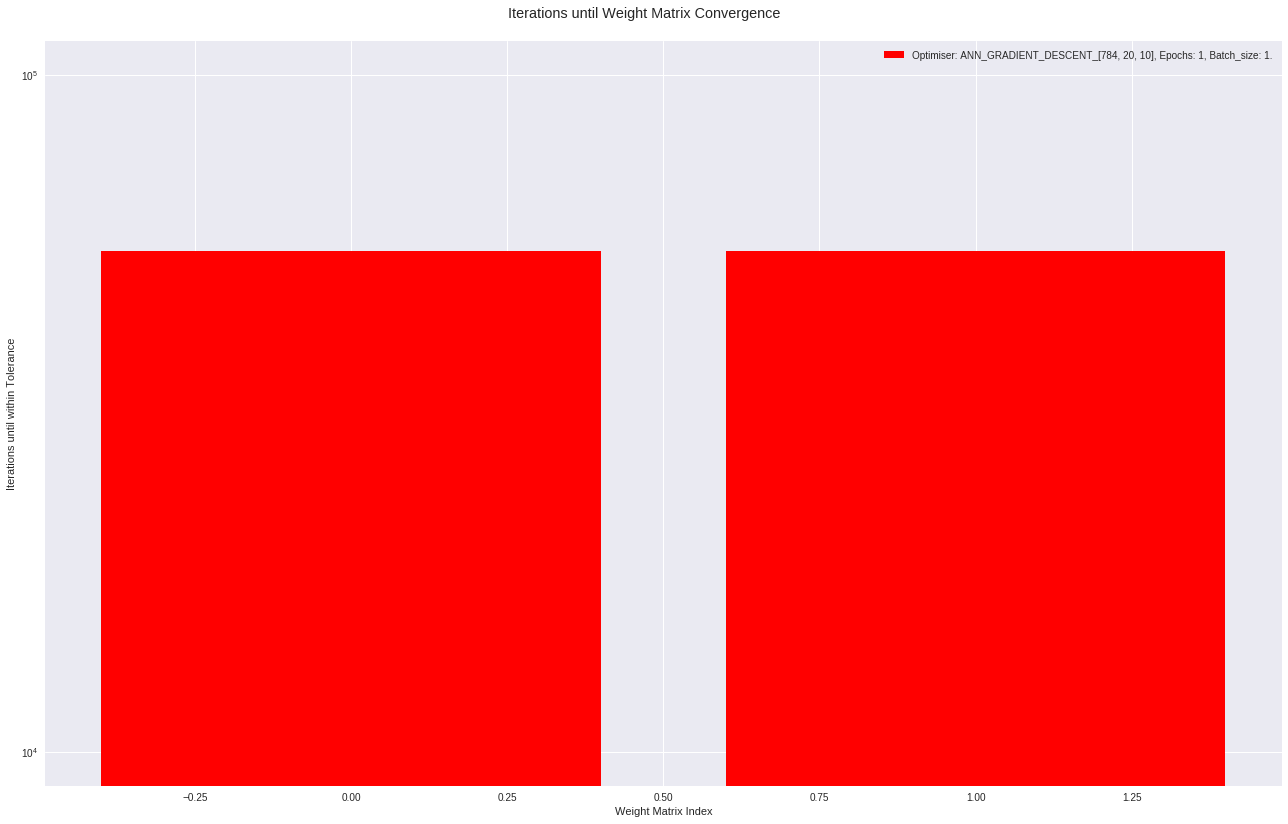

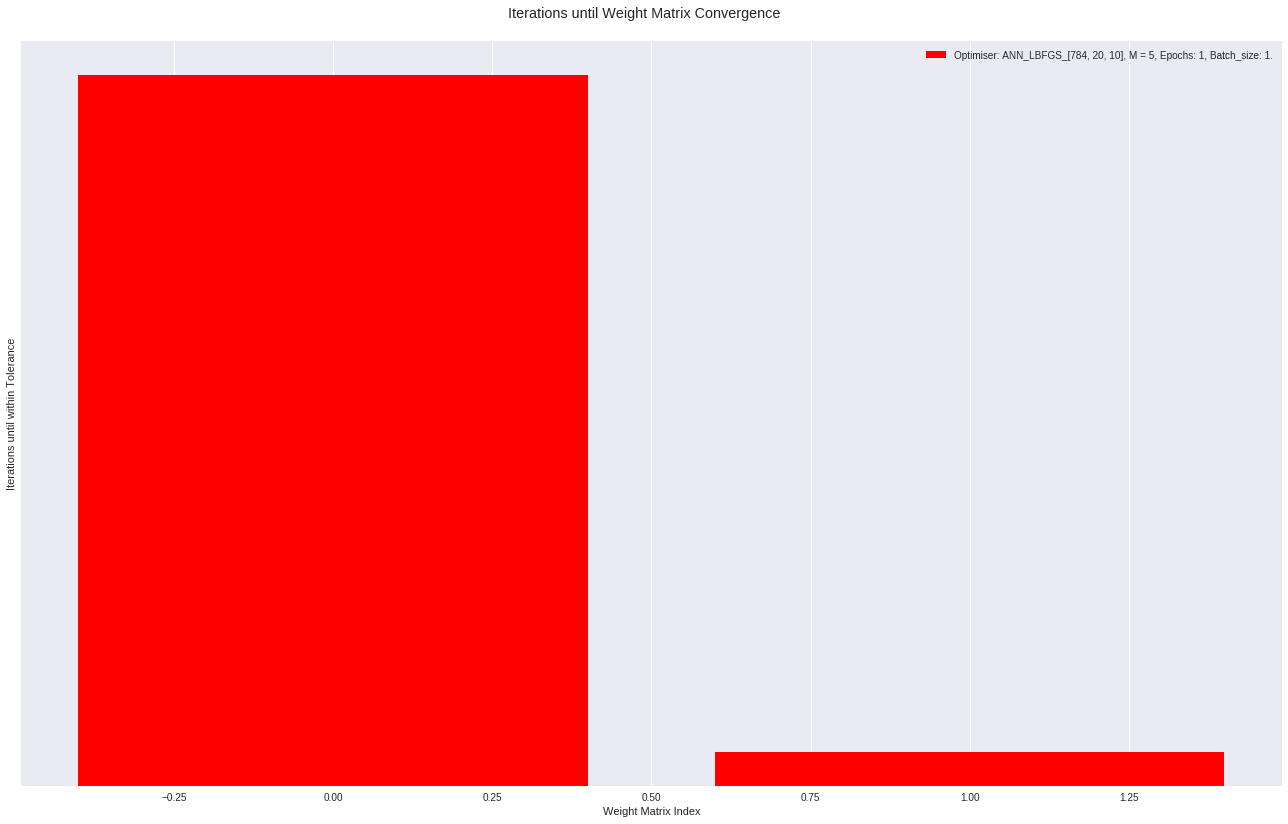

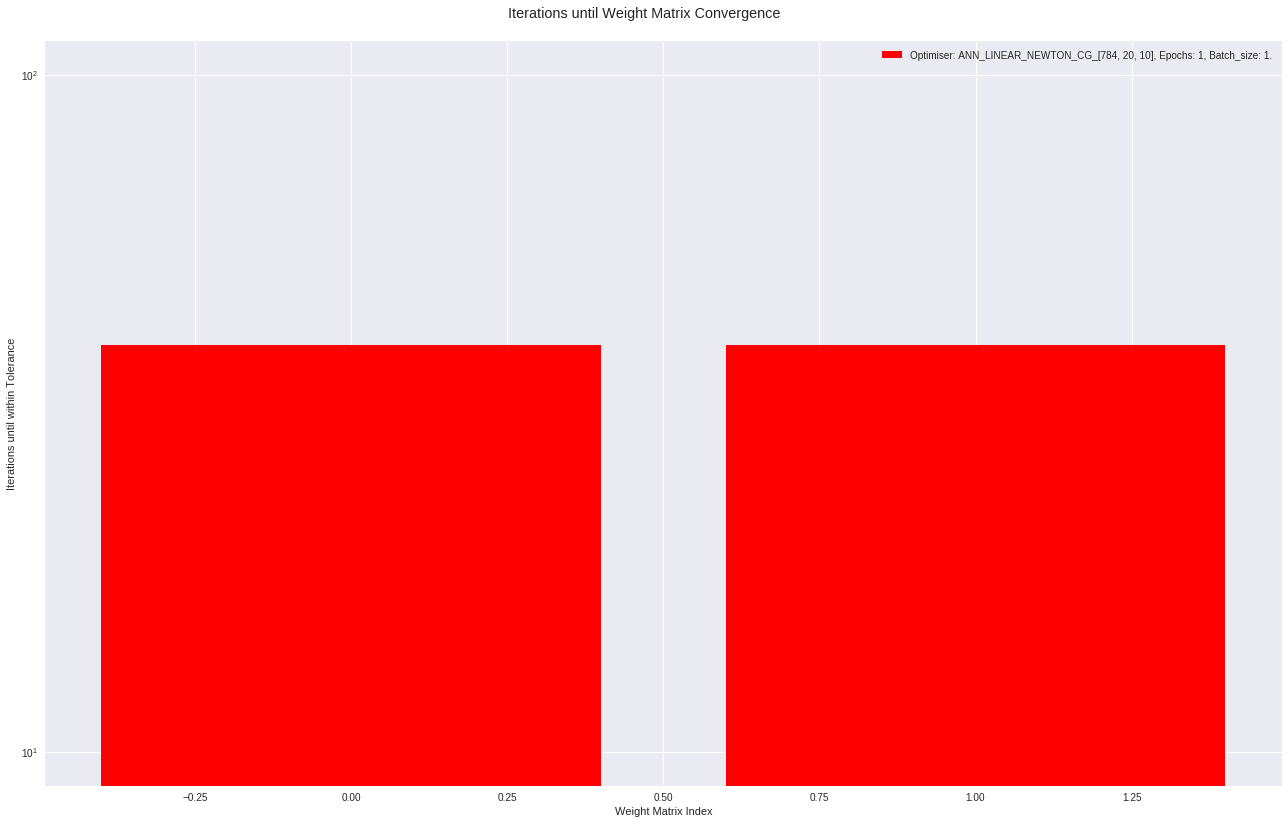

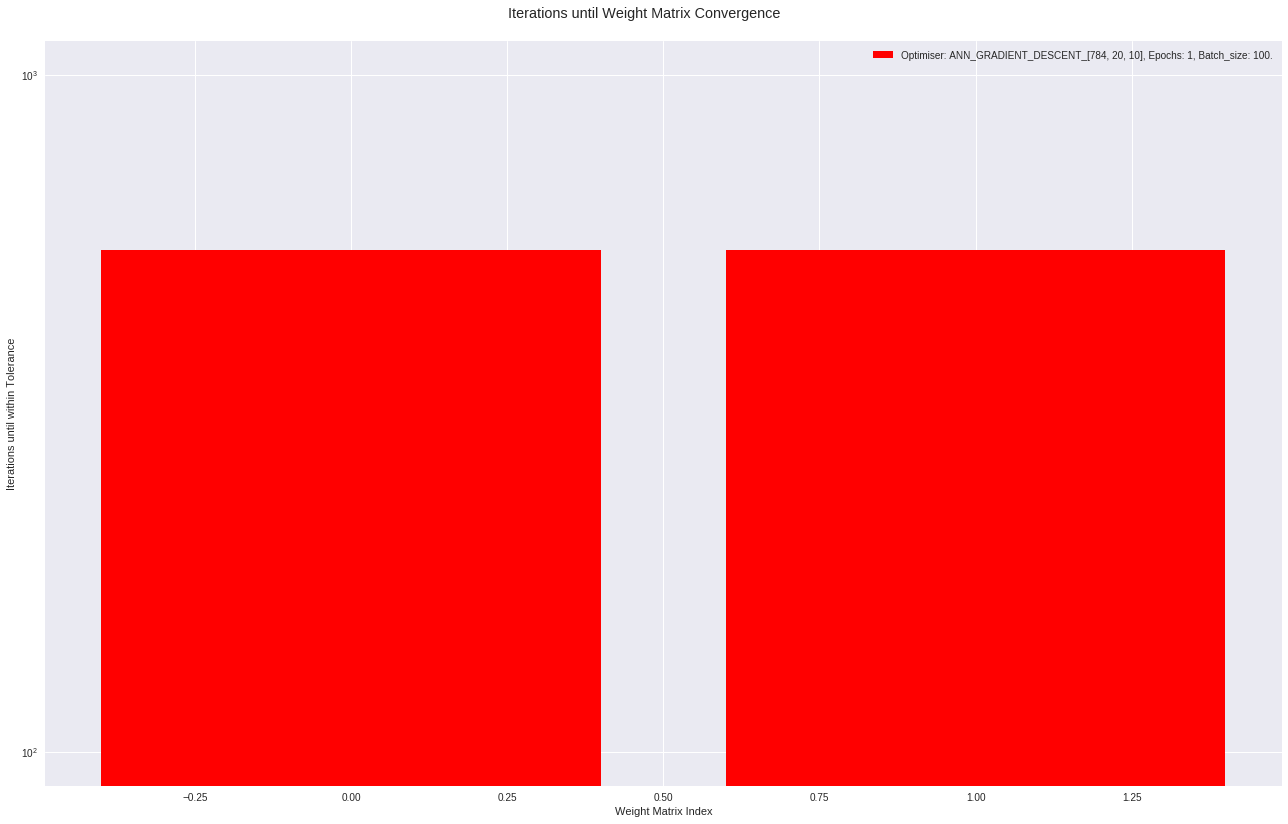

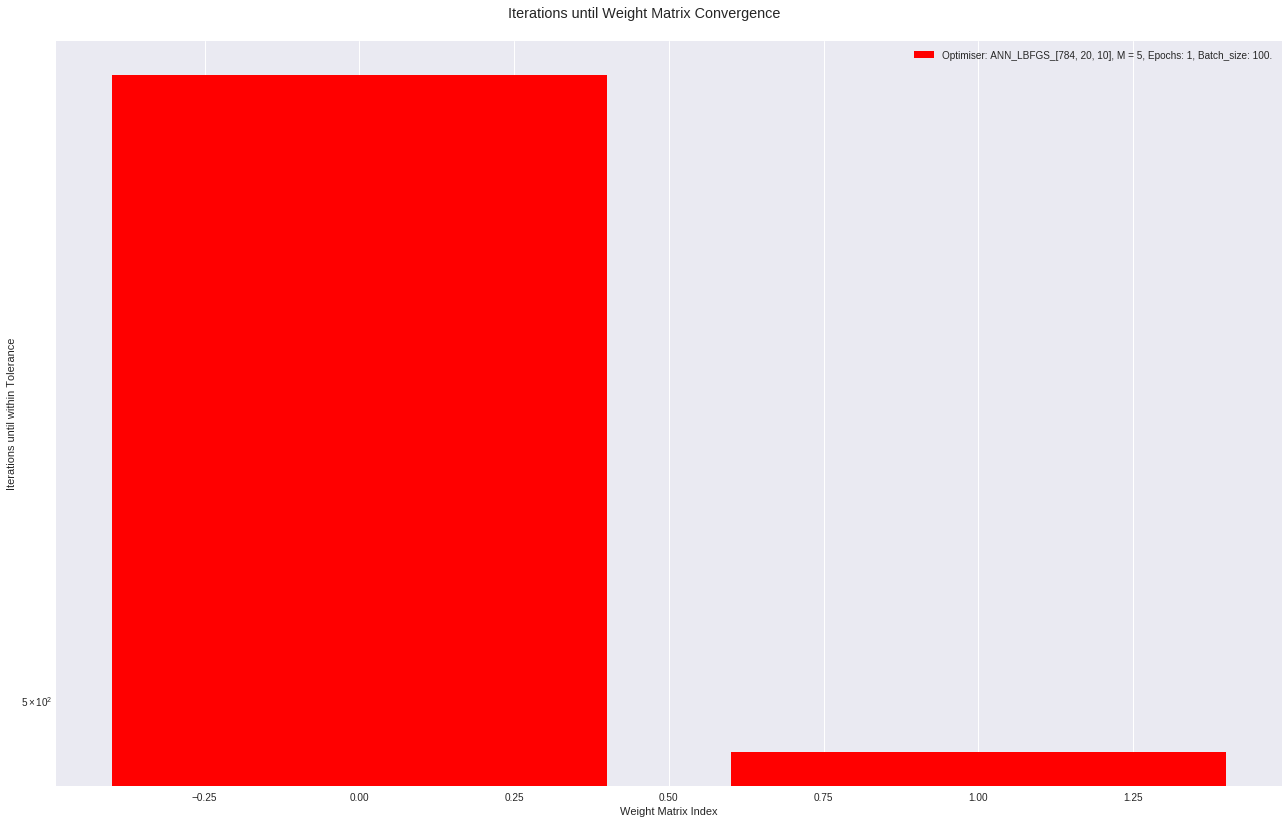

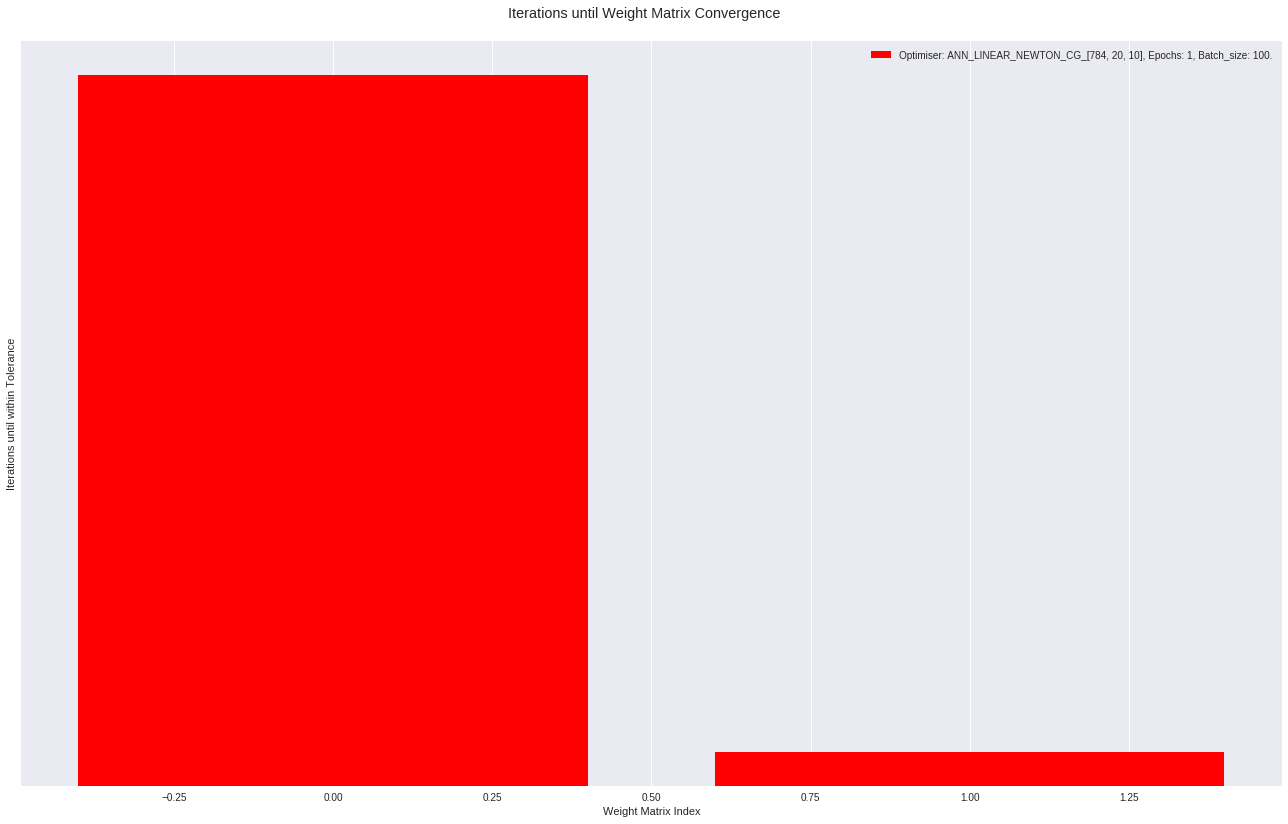

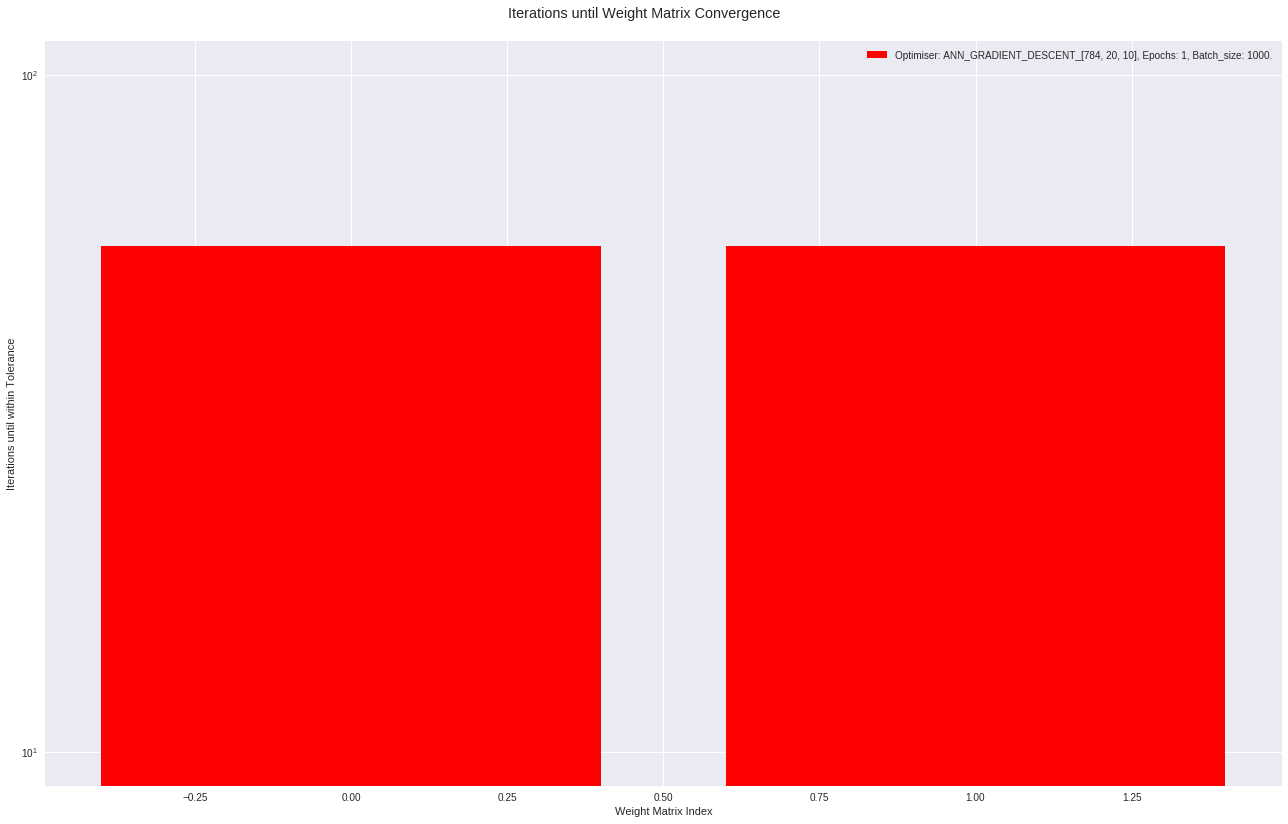

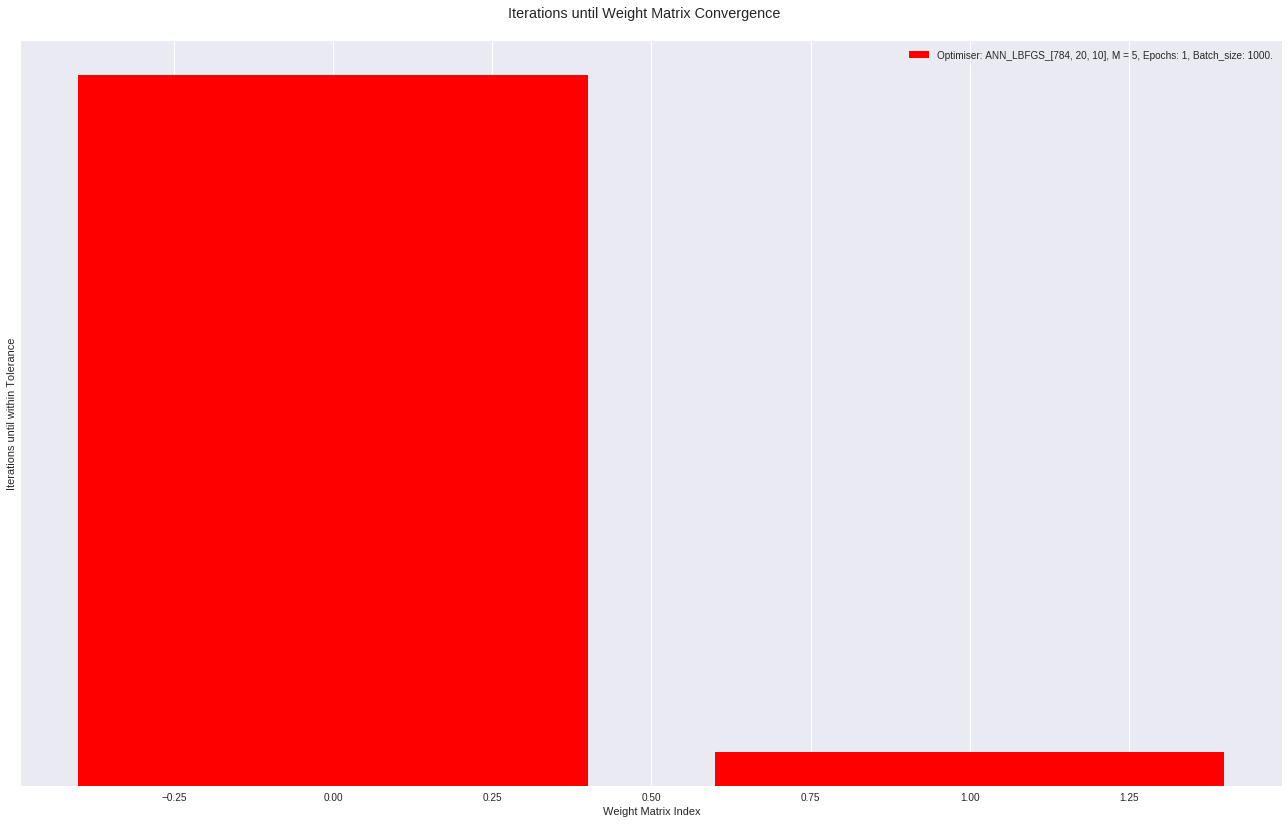

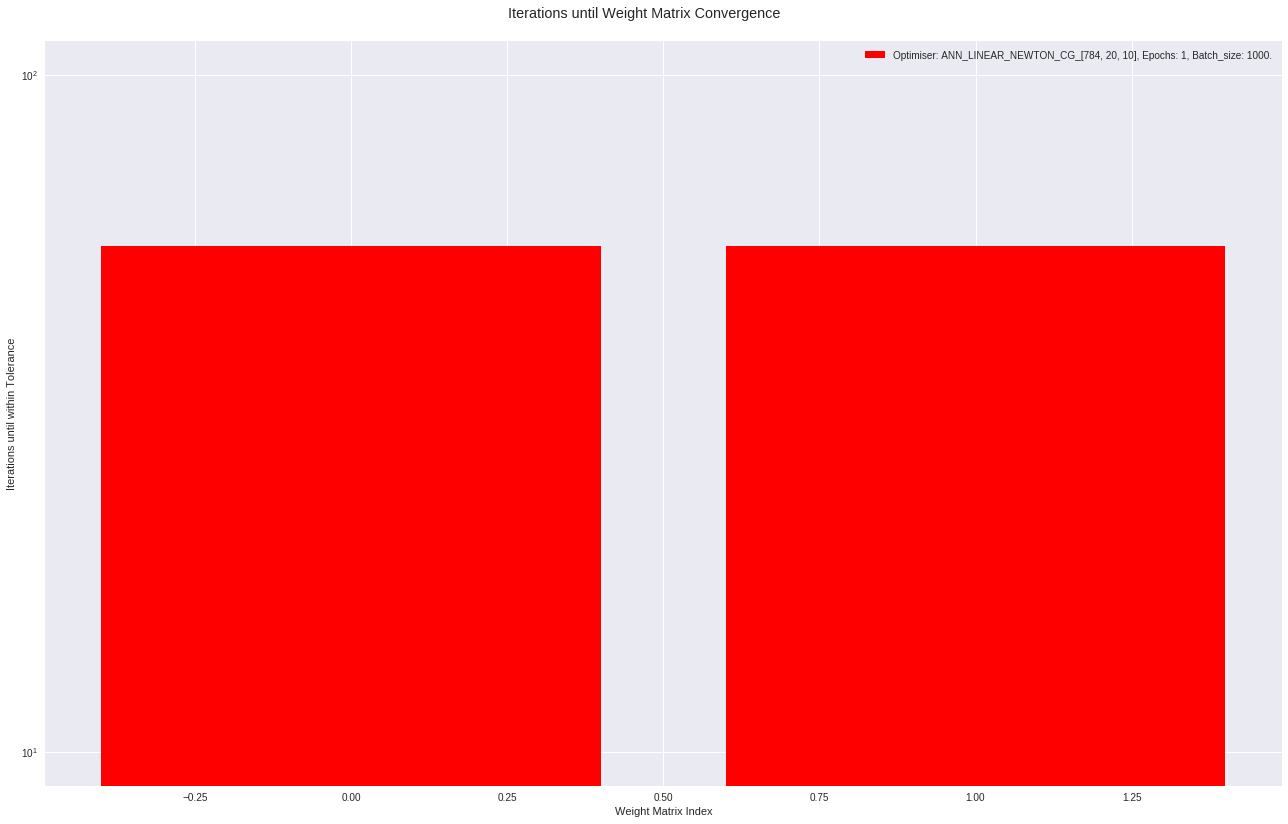

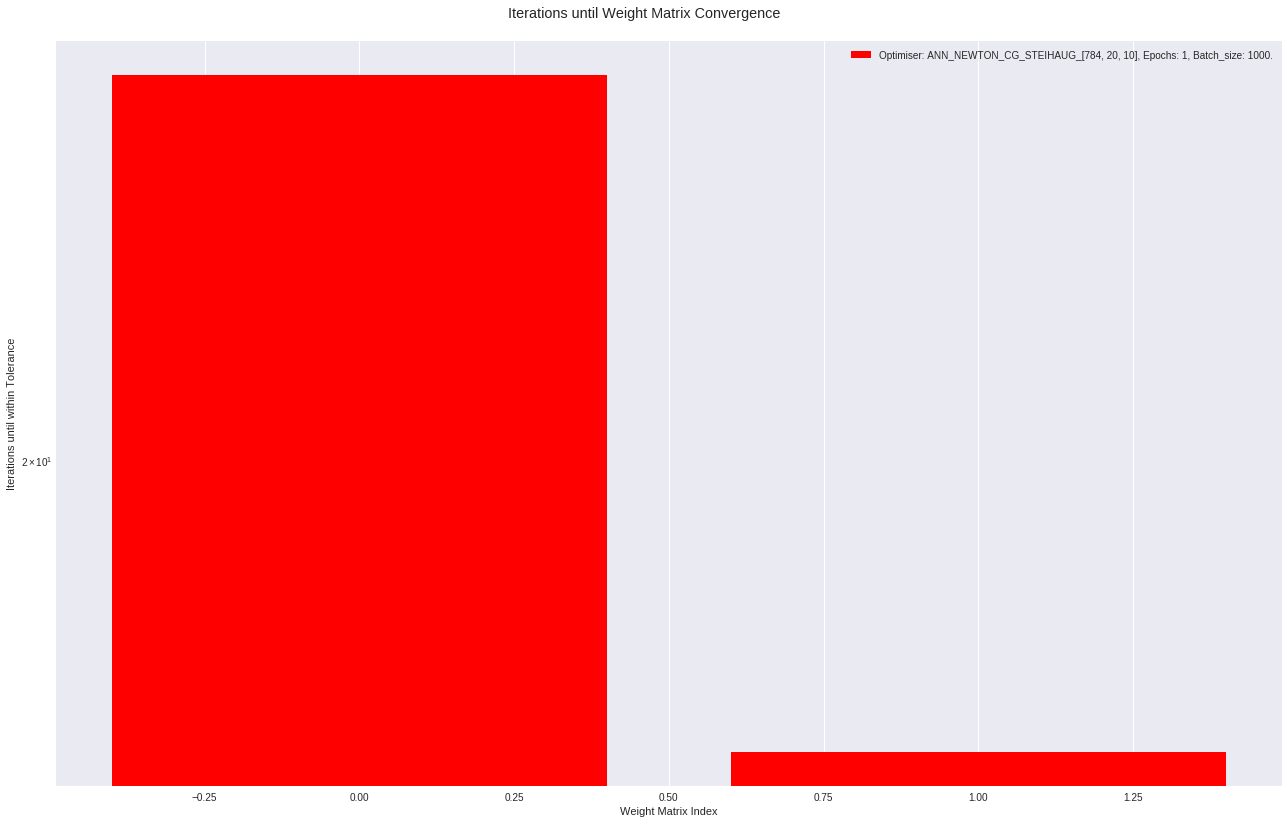

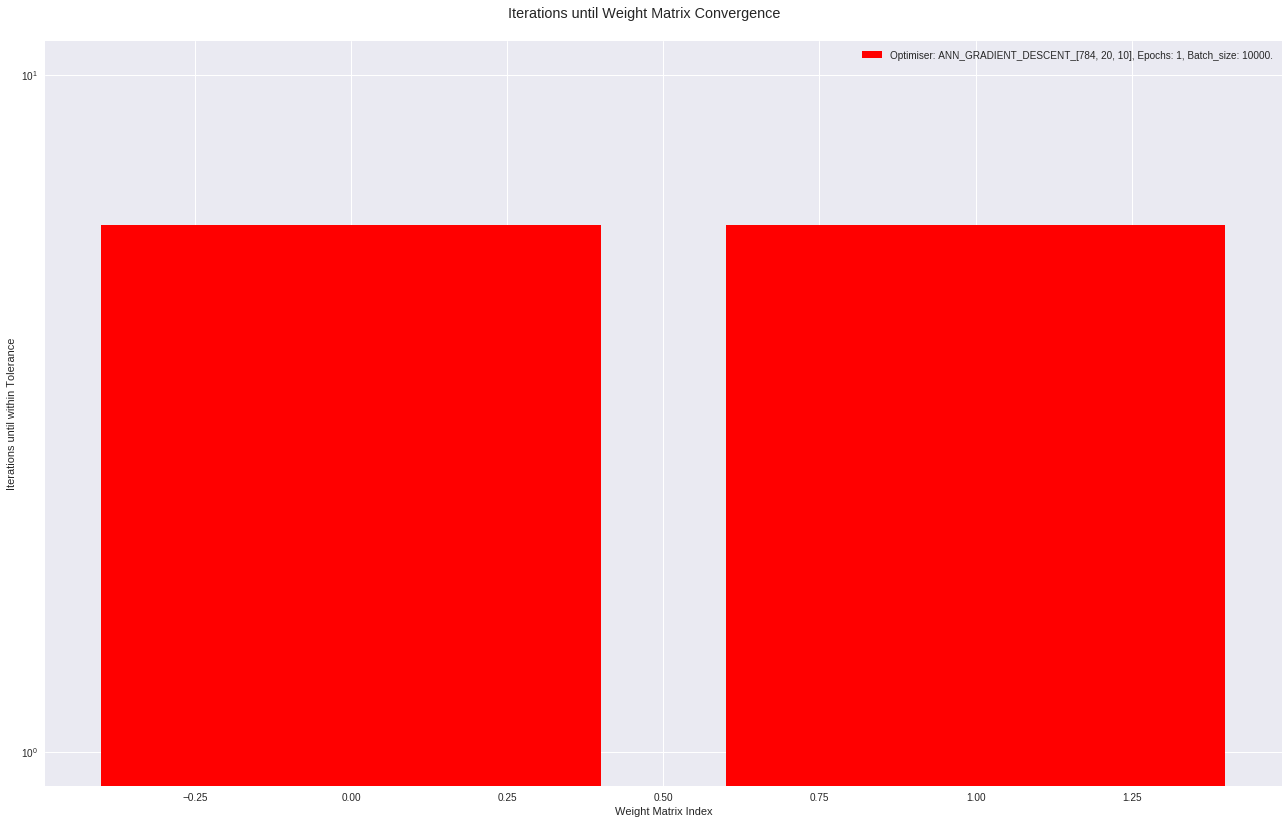

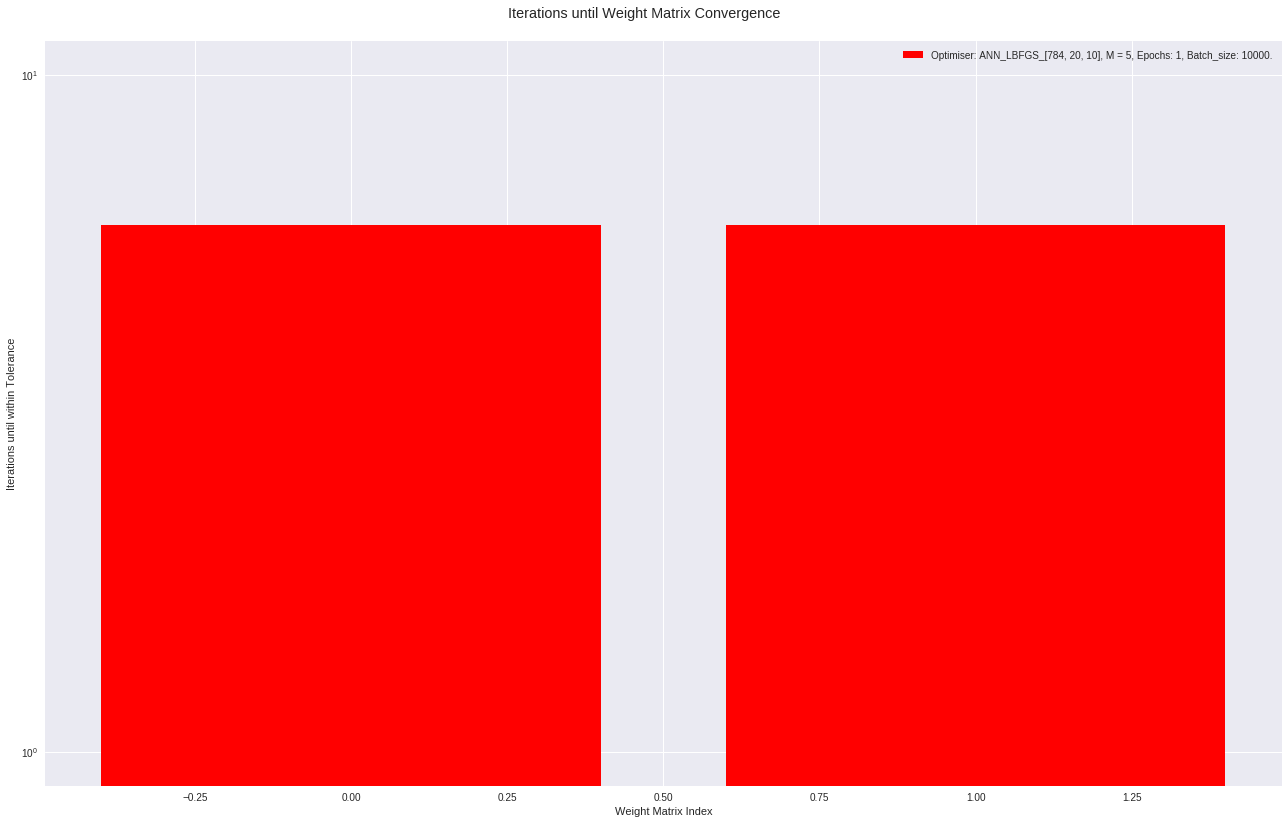

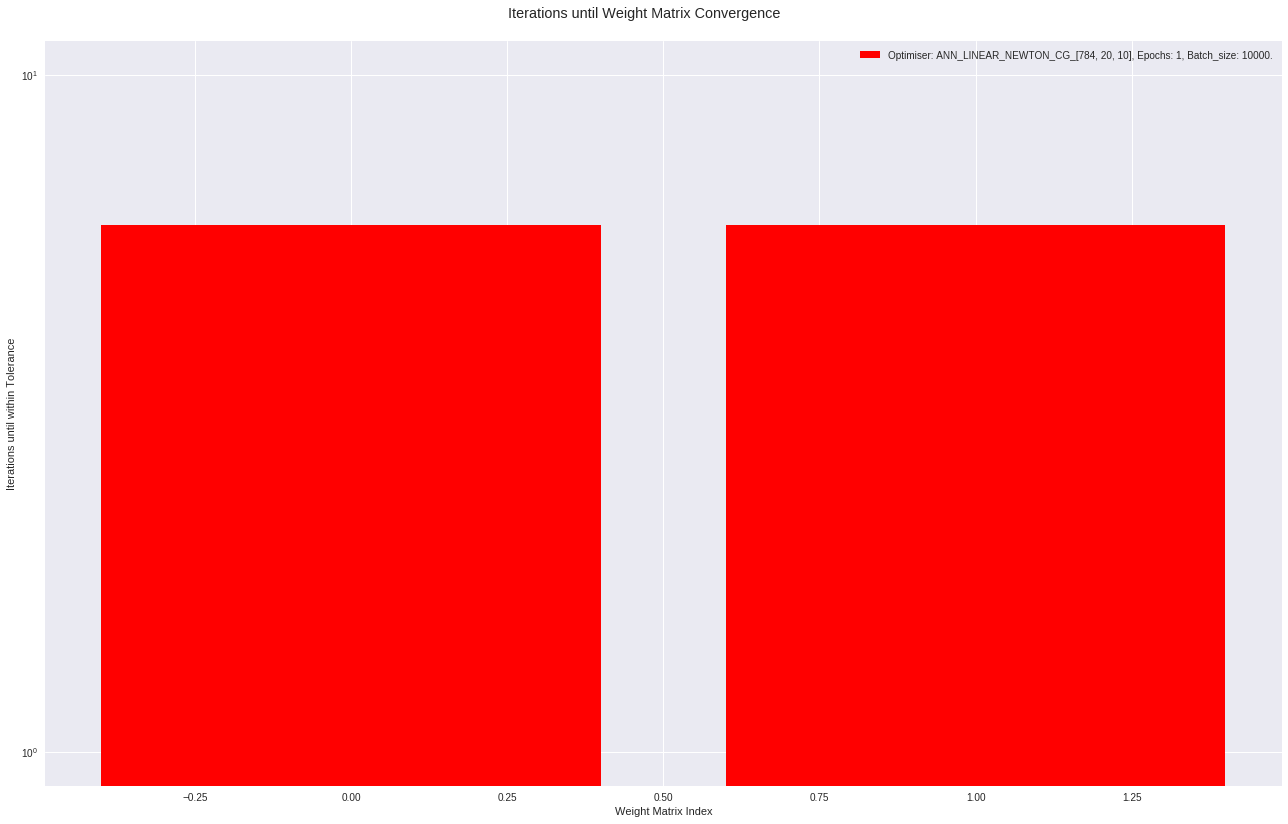

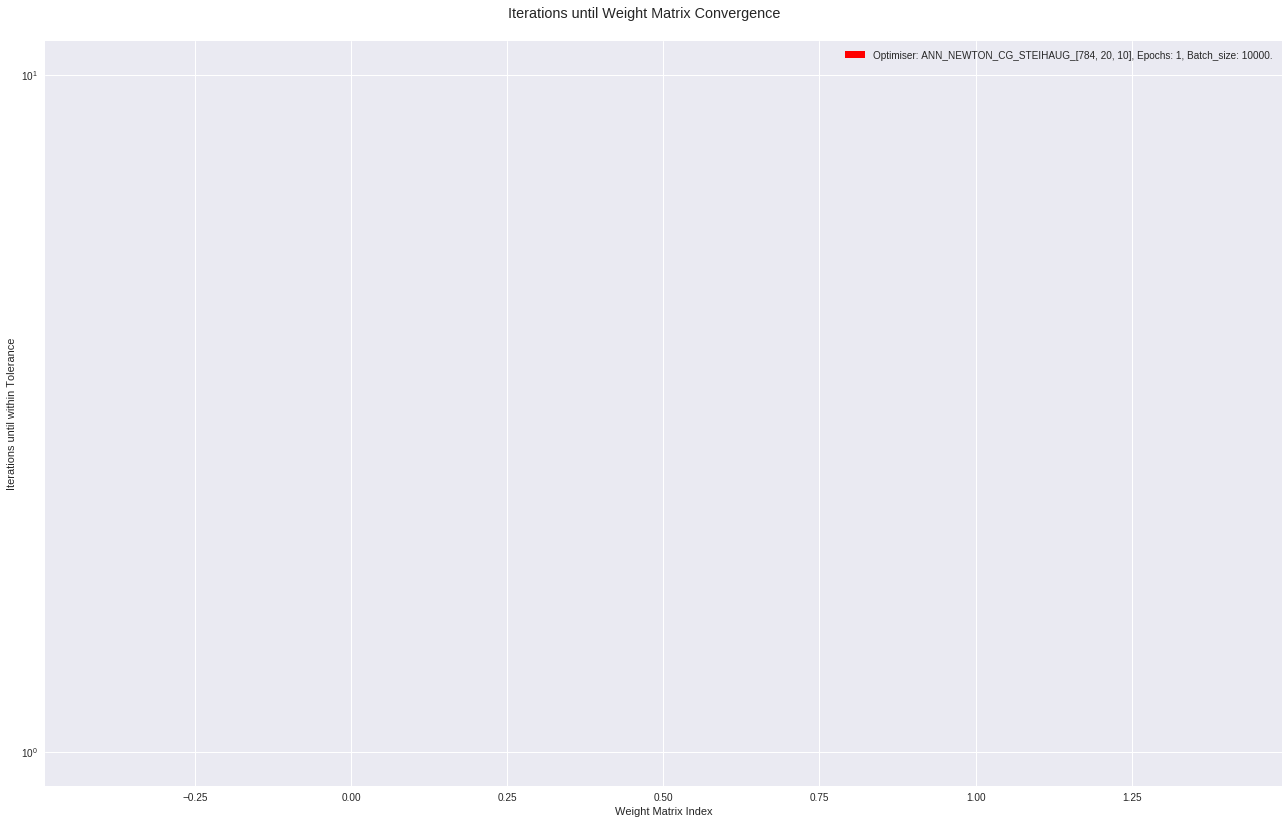

In [55]:
plot_learning_curves(experiment_results)
plot_loss(experiment_results)
plot_step(experiment_results)
plot_toleranceConverge(experiment_results)

# Varying Hidden Layer Unit Size

In [0]:
# CAREFUL: Running this CL resets the experiments_task1 dictionary where results should be stored.
# Store results of runs with different configurations in a dictionary.
# Use a tuple (num_epochs, learning_rate) as keys, and a tuple (training_accuracy, testing_accuracy)

num_epochs = 1


h5_Models = [ANN_GRADIENT_DESCENT(batchSize=100,
                     layers=[784,5,10]),
                   ANN_LBFGS(5,
                    batchSize=100,
                    layers=[784,5,10]),
                   ANN_LINEAR_NEWTON_CG(1000000,
                               batchSize=100,
                               layers=[784,5,10])]


h10_Models = [ANN_GRADIENT_DESCENT(batchSize=100,
                    layers=[784,10,10]),
                  ANN_LBFGS(5,
                    batchSize=100,
                    layers=[784,10,10]),
                  ANN_LINEAR_NEWTON_CG(1000000,
                               batchSize=100,
                               layers=[784,10,10])]


h20_Models = [ANN_GRADIENT_DESCENT(batchSize=100,
                      layers=[784,20,10]),
                    ANN_LBFGS(5,
                      batchSize=100,
                      layers=[784,20,10]),
                    ANN_LINEAR_NEWTON_CG(1000000,
                                 batchSize=100,
                                 layers=[784,20,10]),
                    ANN_NEWTON_CG_STEIHAUG(1000000,1.e-5,0.0005,1.,
                               batchSize=100,
                               layers=[784,20,10],step=trustRegion)]

h30_Models = [ANN_GRADIENT_DESCENT(batchSize=100,
                      layers=[784,30,10]),
                    ANN_LBFGS(5,
                      batchSize=100,
                      layers=[784,30,10]),
                    ANN_LINEAR_NEWTON_CG(1000000,
                                 batchSize=100,
                                 layers=[784,30,10]),
                     ANN_NEWTON_CG_STEIHAUG(1000000,1.e-5,0.0005,1.,
                               batchSize=100,
                               layers=[784,30,10],step=trustRegion)]

experiments = [h5_Models, h10_Models, h20_Models, h30_Models]
experiment_results = [[], [], [], []]

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LINEAR_NEWTON

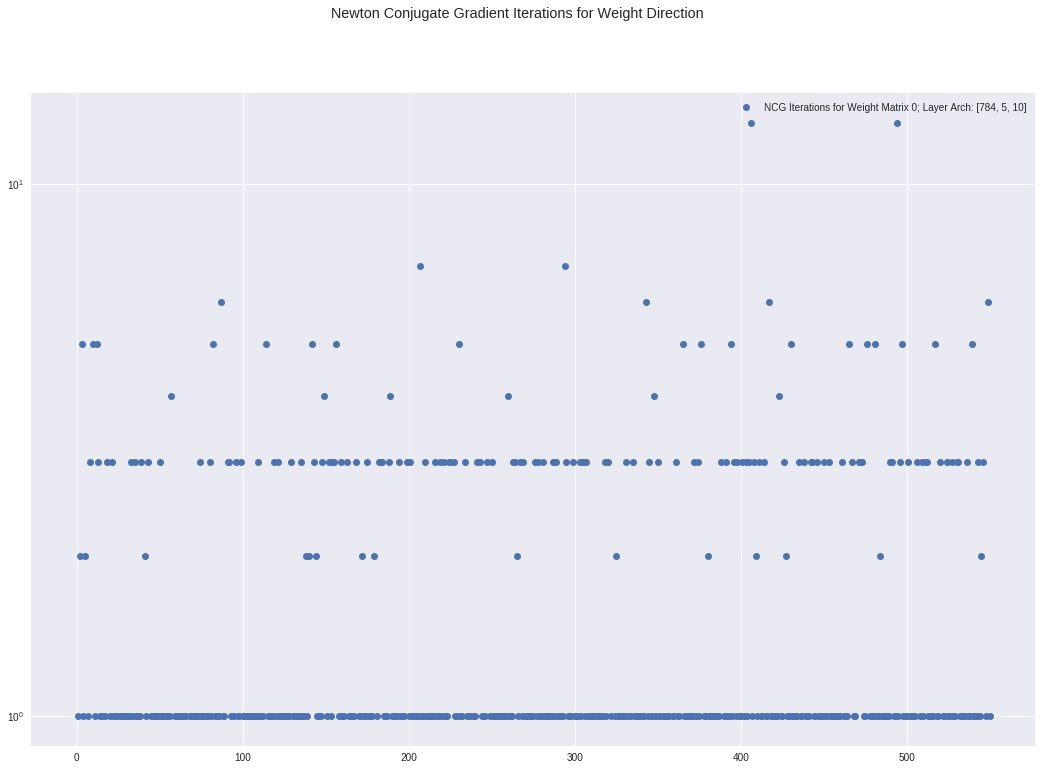

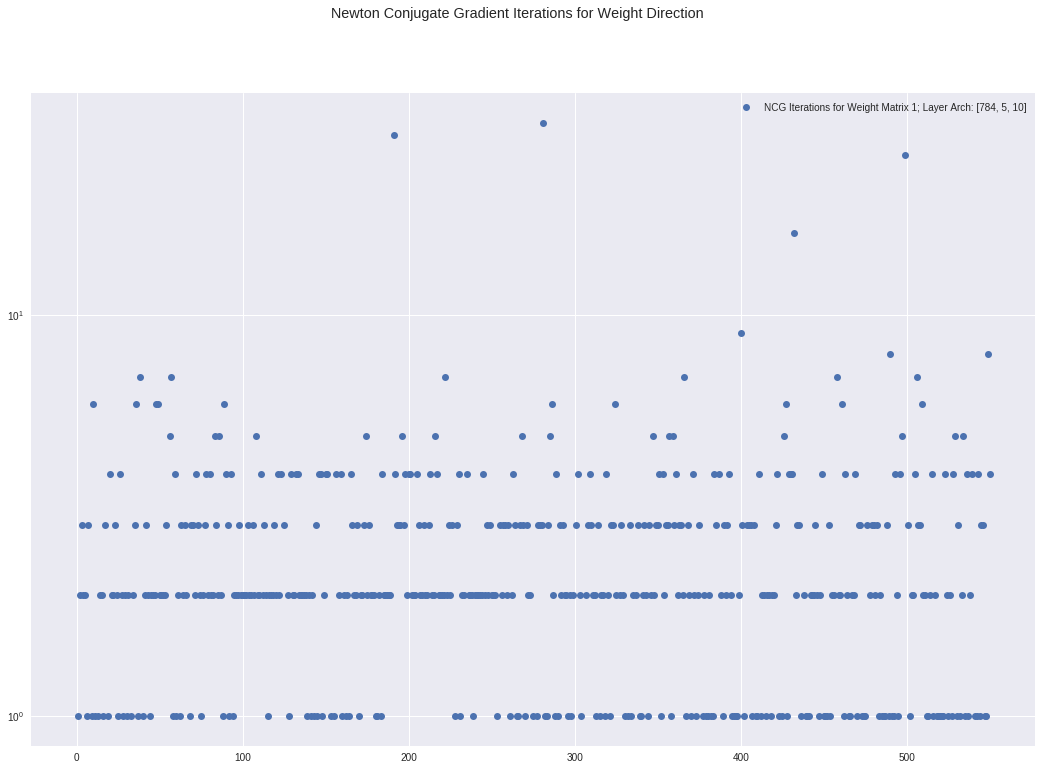

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LINEAR_NEWTON

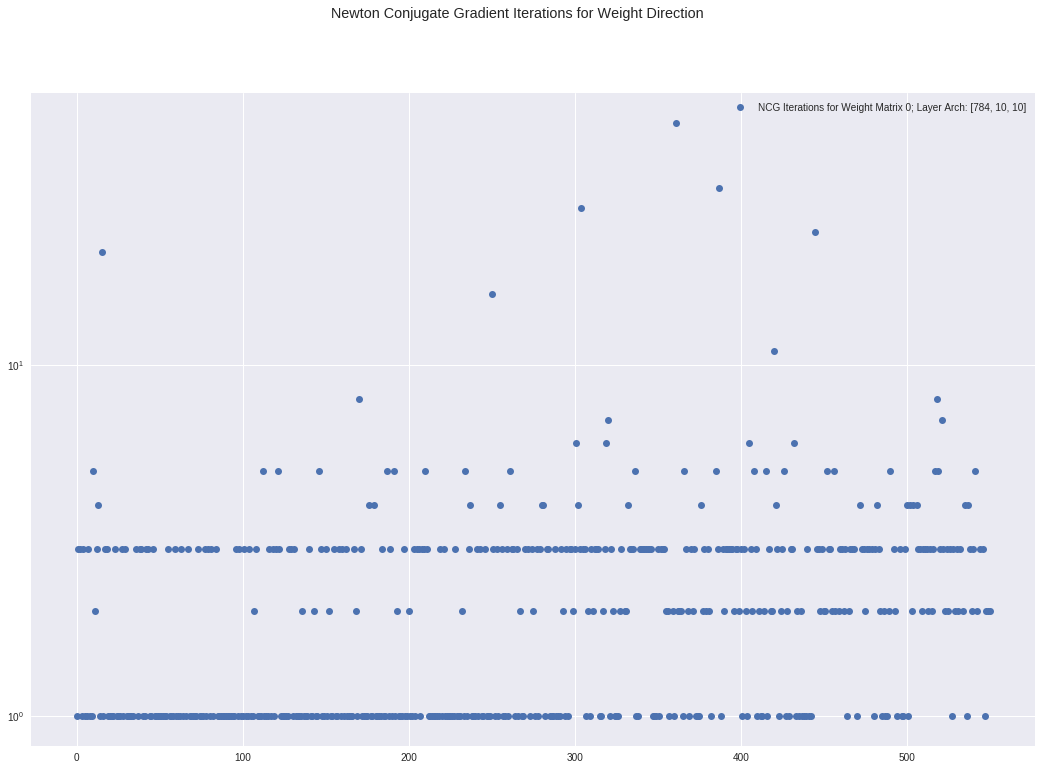

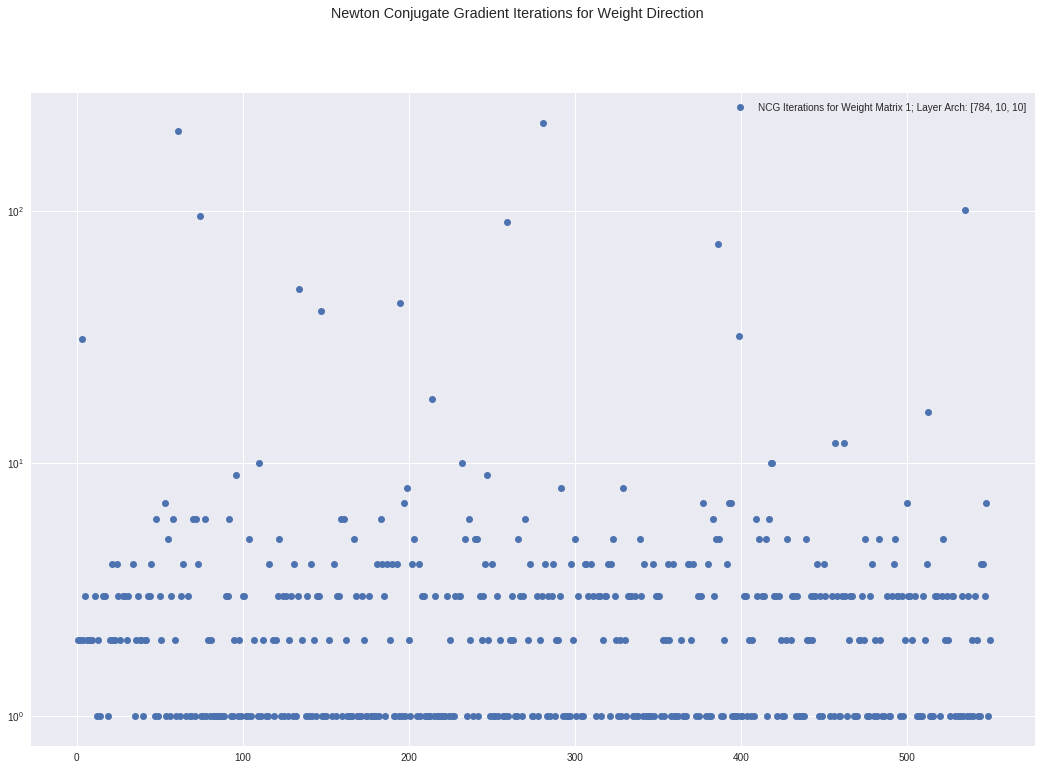

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LINEAR_NEWTON

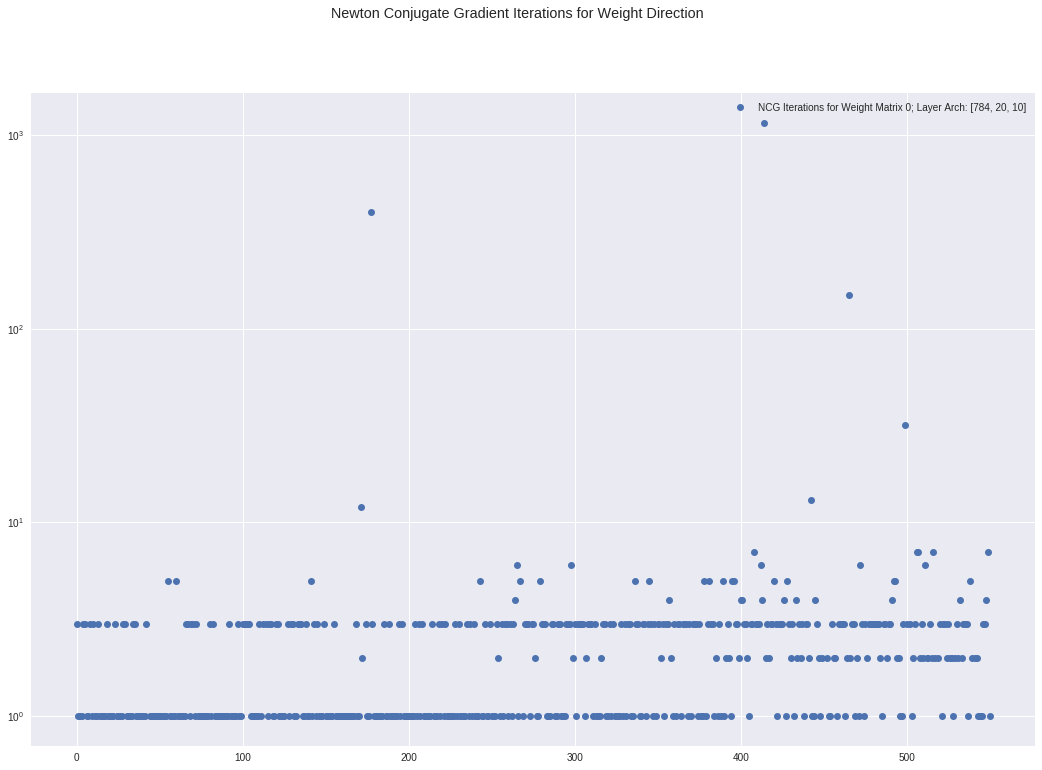

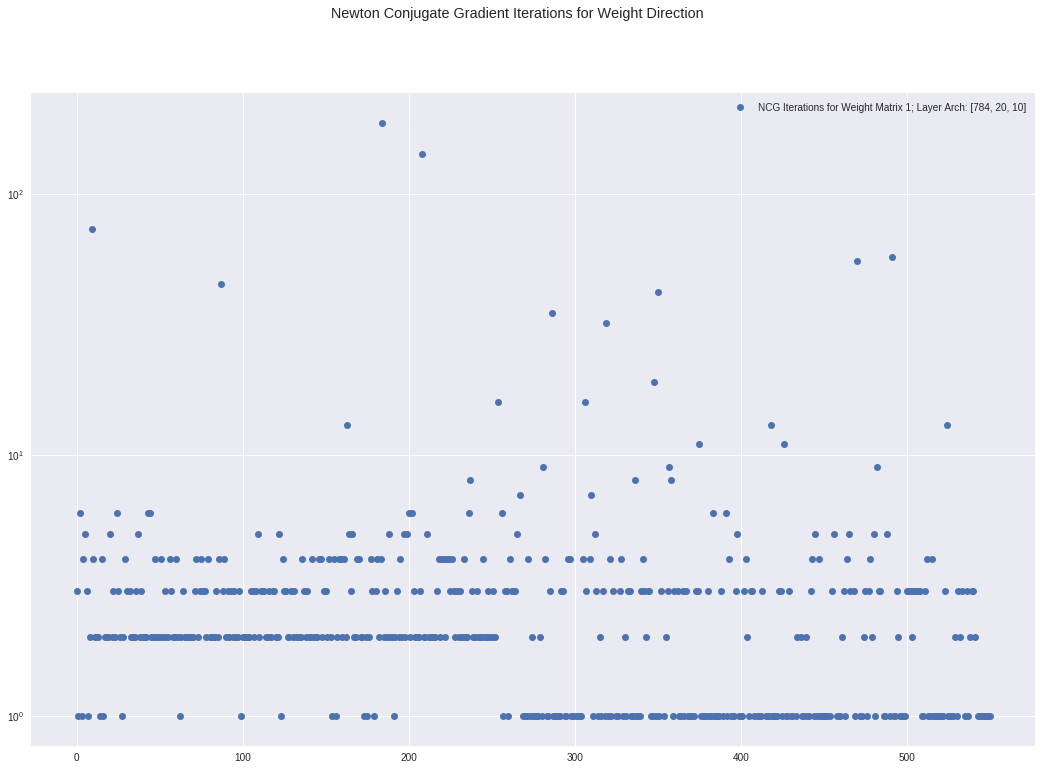

ANN_NEWTON_CG_STEIHAUG
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in divide


Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


/usr/local/lib/python2.7/dist-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


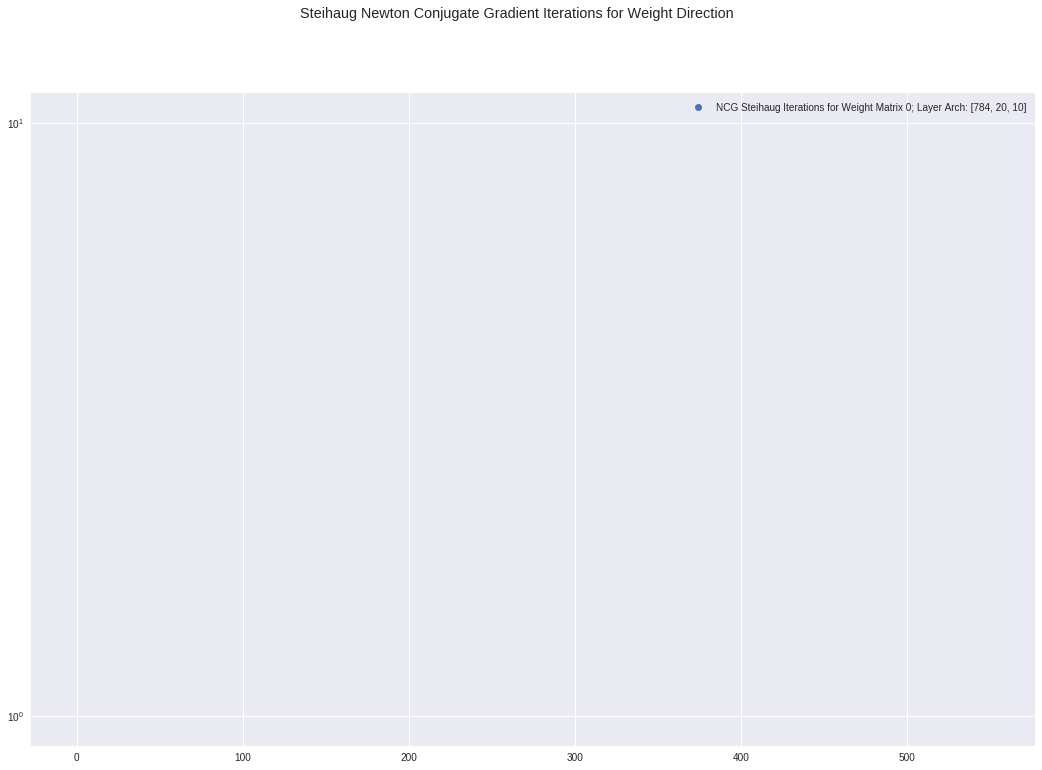

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


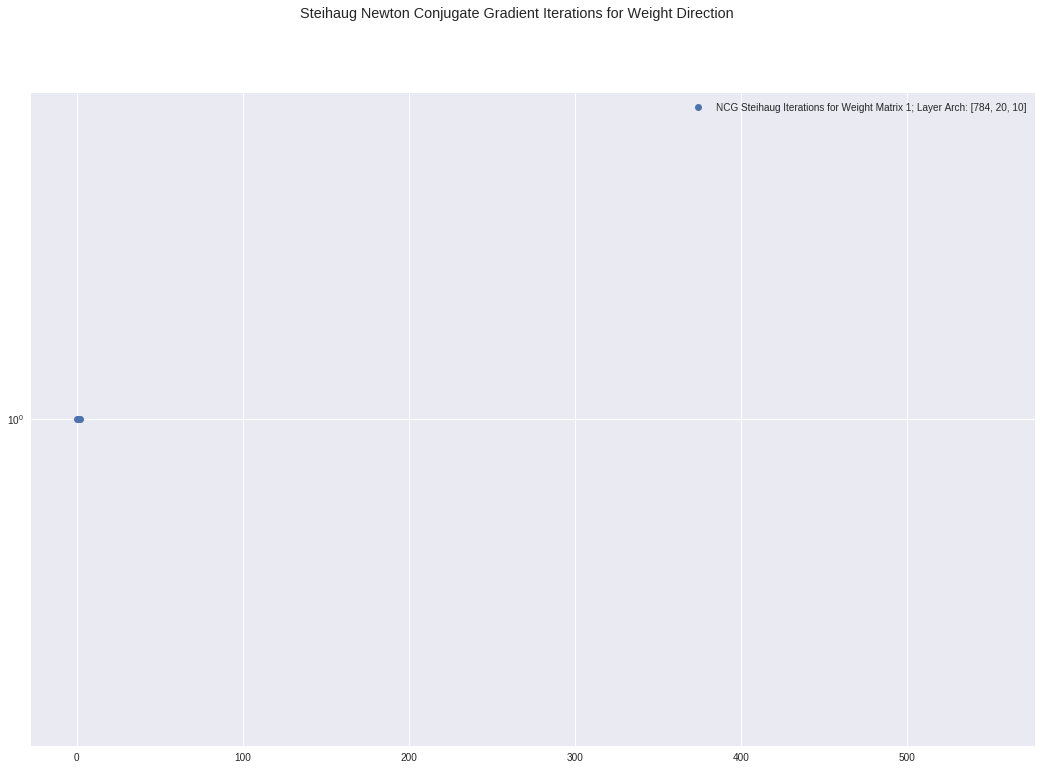

ANN_GRADIENT_DESCENT
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LBFGS
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
ANN_LINEAR_NEWTON

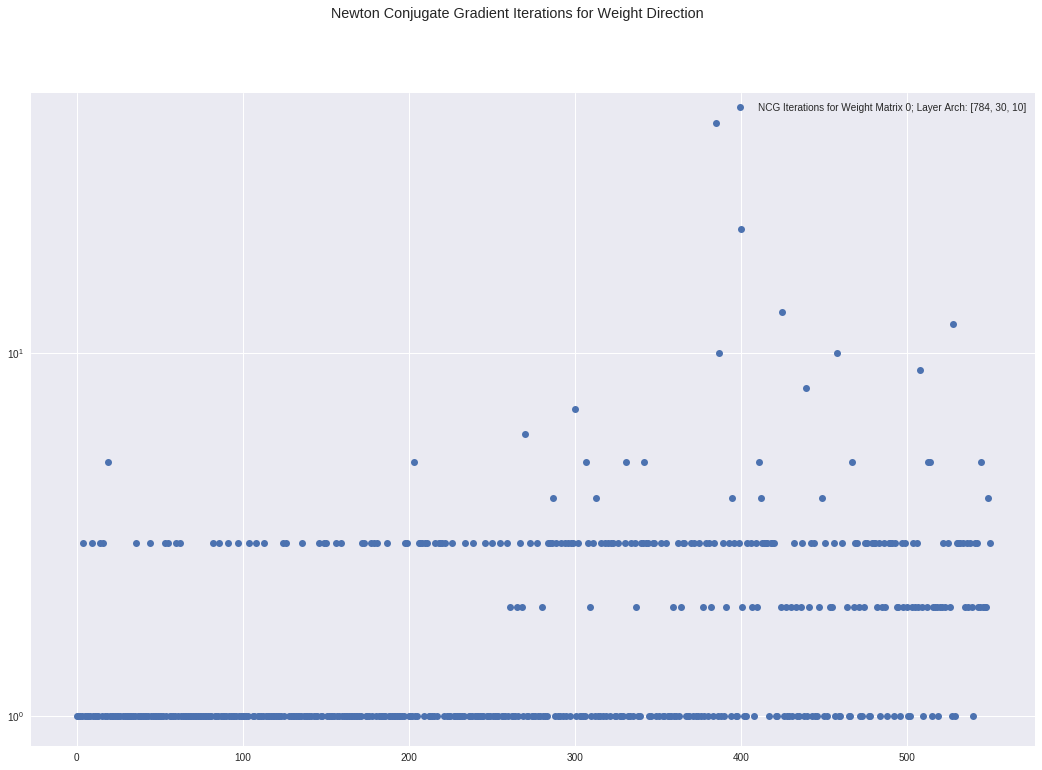

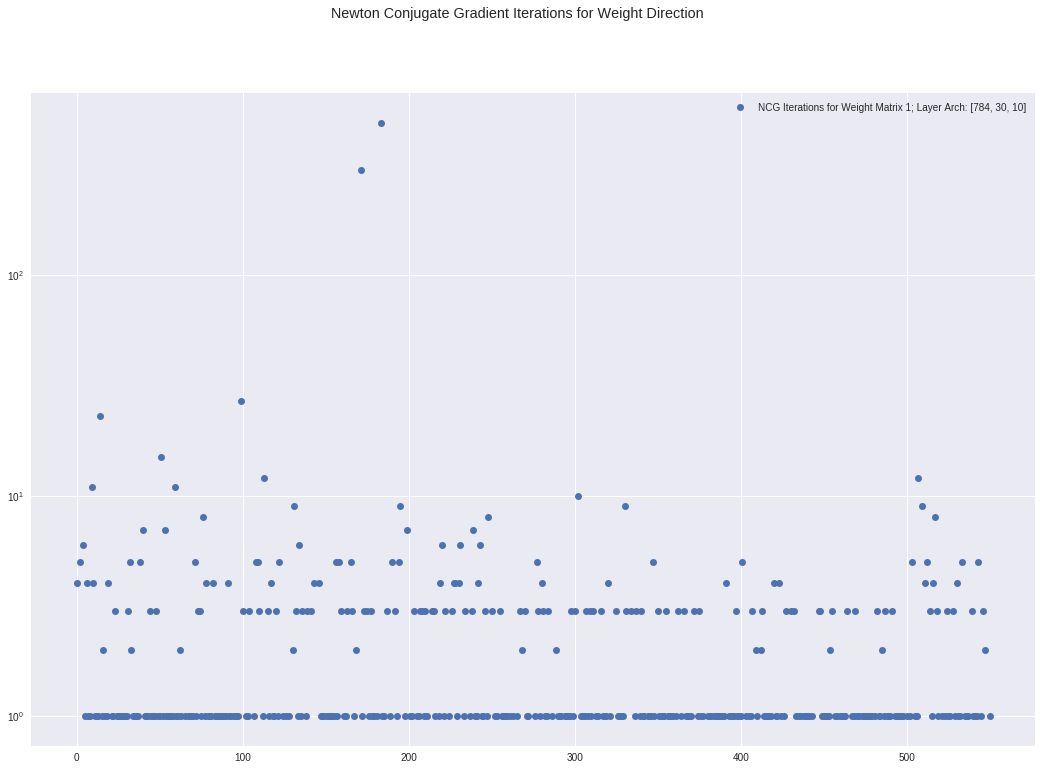

ANN_NEWTON_CG_STEIHAUG
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500


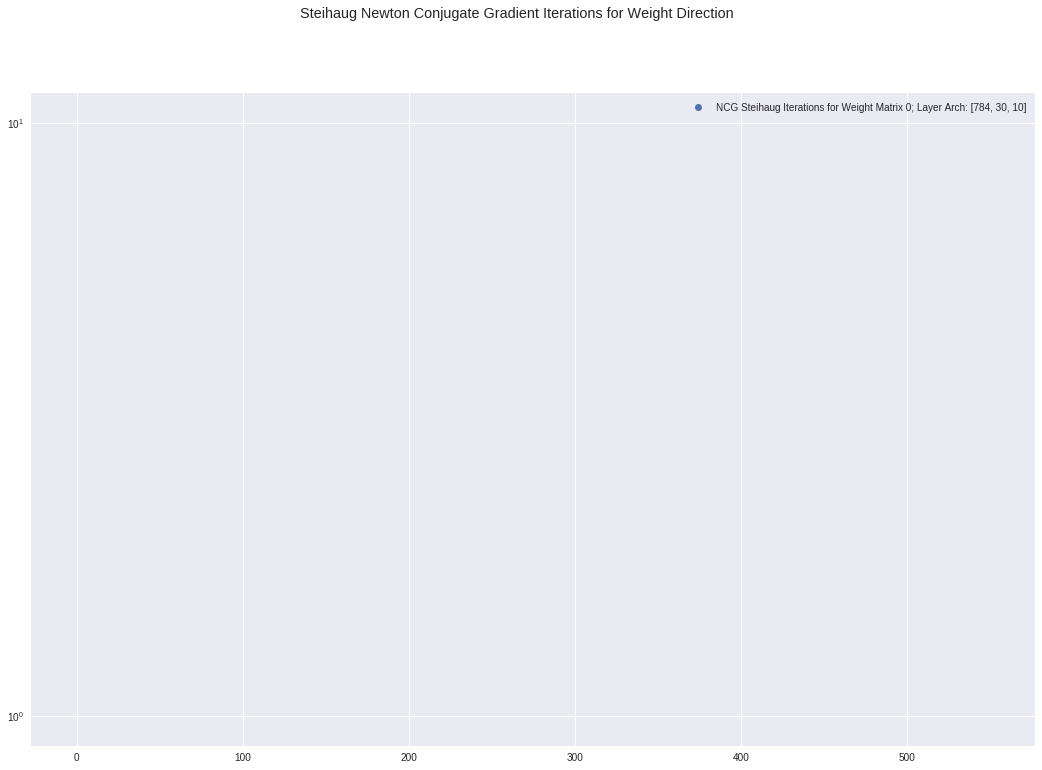

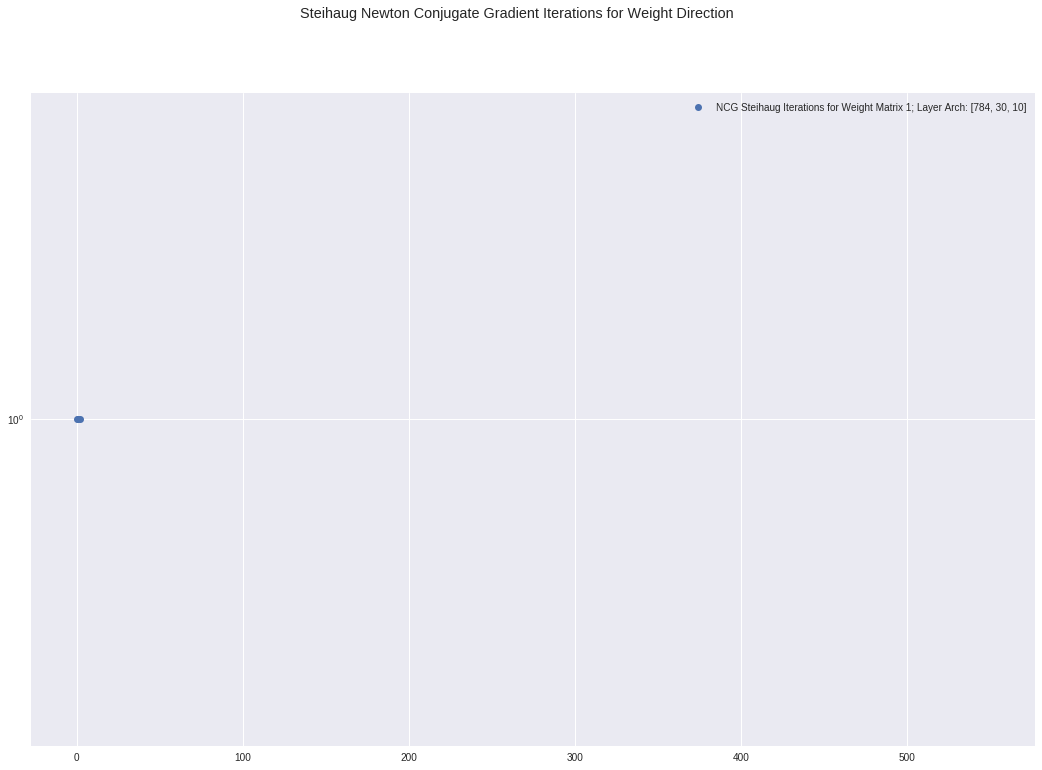

In [10]:
for idm,models in enumerate(experiments):
  while len(models) != 0:
    name = models[0].__class__.__name__ 
    print name

    # Reset graph, recreate placeholders and dataset.
    mnist = get_data()
    eval_mnist = get_data()

    #####################################################
    # Define model, loss, update and evaluation metric. #
    #####################################################

    ann = models[0]    
    batch_size = ann.batchSize

    del models[0]

    # Train.
    i, train_accuracy, test_accuracy, losses, step_sizes = -1, [], [], [], []
    log_period_updates = int(log_period_samples / batch_size)
    while mnist.train.epochs_completed < num_epochs:

      # Update.
      i += 1
      batch_xs, batch_ys = mnist.train.next_batch(batch_size)

      if i==0:
        losses.append(ann.xEnt(0,batch_ys,0,0,batch_xs/255.))

      #################
      # Training step #
      #################
      
      res = ann.backprop(batch_ys, ann.forward(batch_xs/255.), batch_xs/255.)
      losses.append(ann.xEnt(0,batch_ys,0,0,batch_xs/255.))

      # Periodically evaluate.
      if i % log_period_updates == 0:
        print 'Iteration: ' + str(i)
        #####################################
        # Compute and store train accuracy. #
        #####################################

        out = ann.forward(batch_xs/255.)

        prediction = np.argmax(out, axis=1)
        truth = np.argmax(batch_ys, axis=1)

        correct = 0.
        for a,b in zip(prediction,truth):
          if a == b:
            correct += 1.

        train_accuracy.append(correct/(batch_ys.shape[0]))
        #####################################
        # Compute and store test accuracy. #
        #####################################
        test_xs, test_ys = mnist.test.images, mnist.test.labels

        out = ann.forward(test_xs/255.)

        prediction = np.argmax(out, axis=1)
        truth = np.argmax(test_ys, axis=1)

        correct = 0.
        for a,b in zip(prediction,truth):
          if a == b:
            correct += 1.

        test_accuracy.append(correct/test_ys.shape[0])
        
      #if res == 'converged':
      #  break
      #else:
      step_sizes.append(res)

    name += '_' + str(ann.layers)
    if 'BFGS' in name:
      name += ', M = ' + str(ann.M)
      
    if 'CG_STEIHAUG' in name:
      for idx,iterList in enumerate(ann.NCG_Iterations[:-1]):
        fig = plt.figure(figsize=(18,12))
        st = fig.suptitle(
            "Steihaug Newton Conjugate Gradient Iterations for Weight Direction",
            fontsize="x-large")
        plt.yscale('log')
        #print iterList
        plt.plot(iterList, linestyle='None', marker='o', label='NCG Steihaug Iterations for Weight Matrix ' + str(idx) + '; Layer Arch: ' + str(ann.layers))
        plt.legend()
        plt.show()
    elif 'CG' in name:
      for idx,iterList in enumerate(ann.NCG_Iterations[:-1]):
        fig = plt.figure(figsize=(18,12))
        st = fig.suptitle(
            "Newton Conjugate Gradient Iterations for Weight Direction",
            fontsize="x-large")
        #print iterList
        plt.yscale('log')
        plt.plot(iterList, linestyle='None', marker='o', label='NCG Iterations for Weight Matrix ' + str(idx) + '; Layer Arch: ' + str(ann.layers))
        plt.legend()
        plt.show()
      
    experiment_results[idm].append(
        ((name, num_epochs, ann.batchSize), train_accuracy, test_accuracy, losses, step_sizes, ann.layerIterCount[:-1]))
  

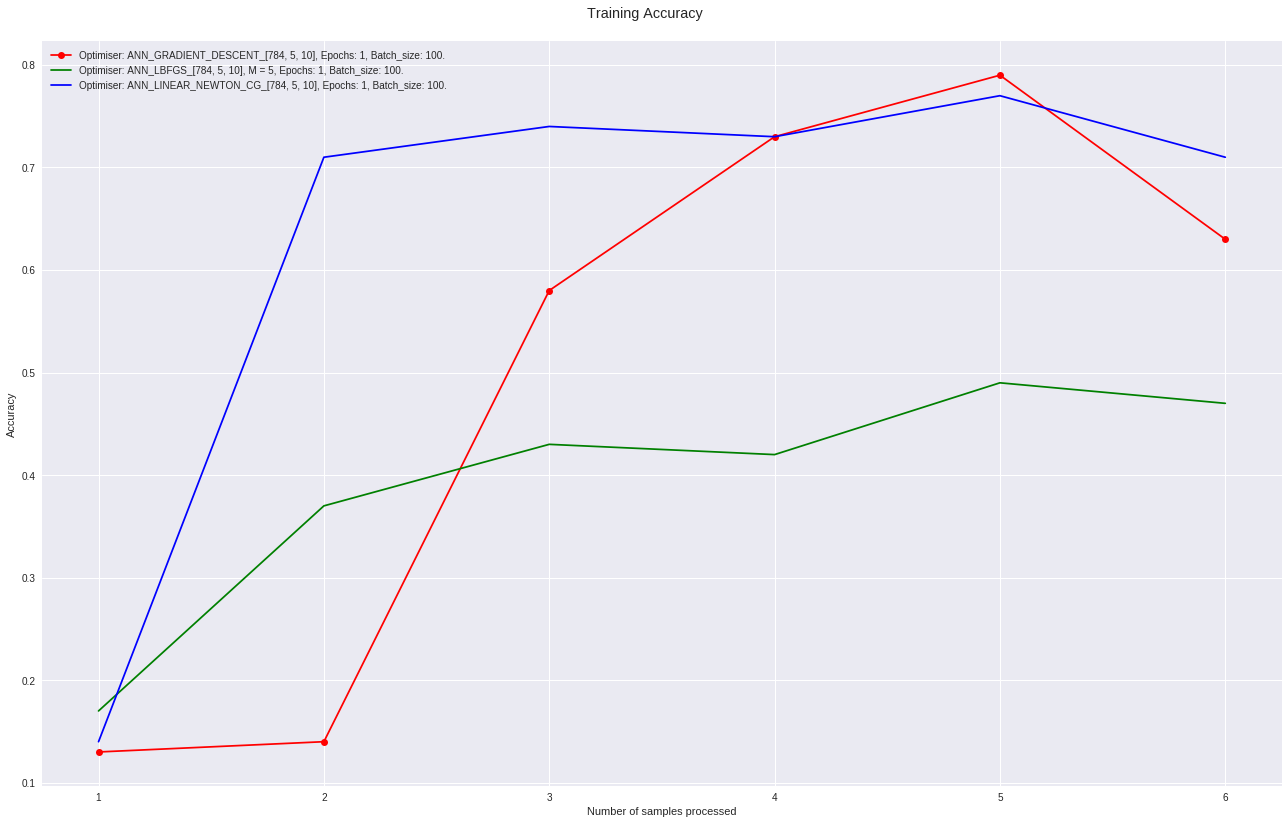

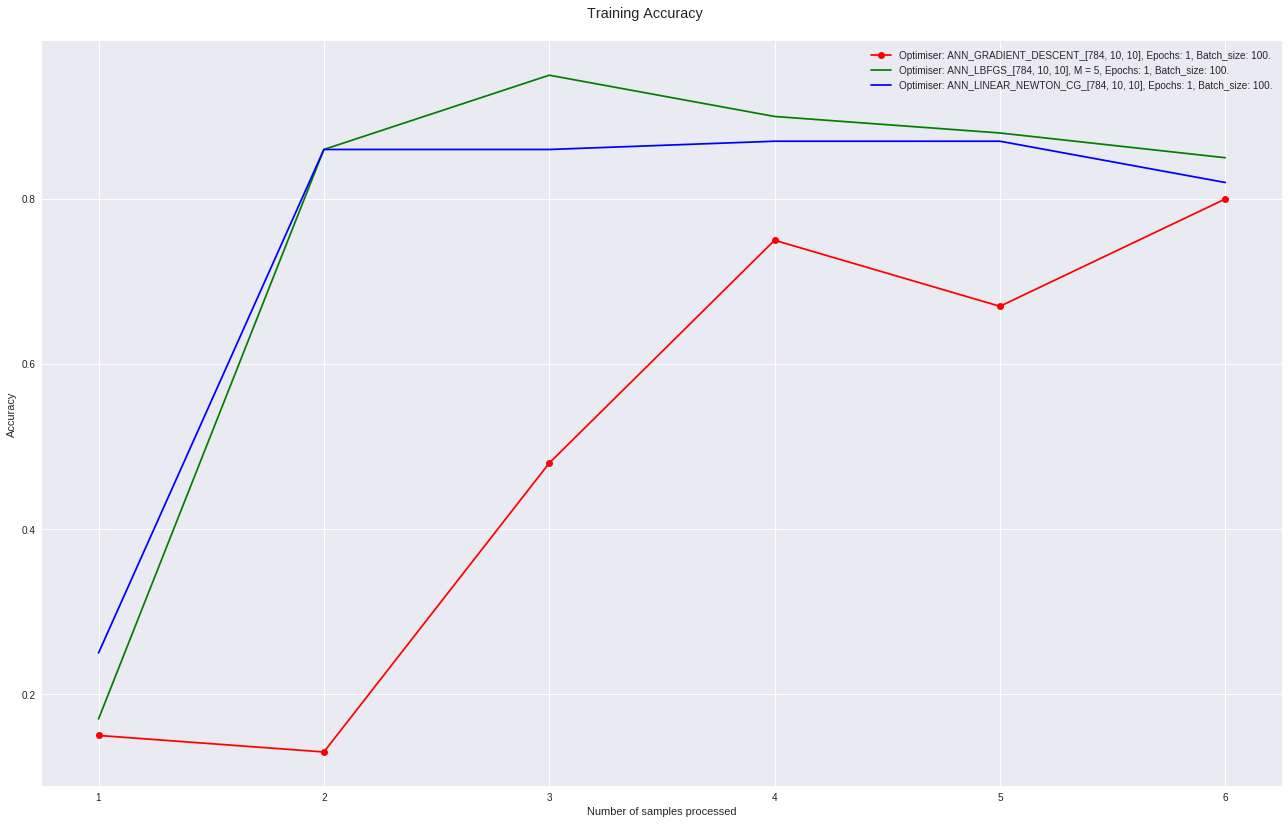

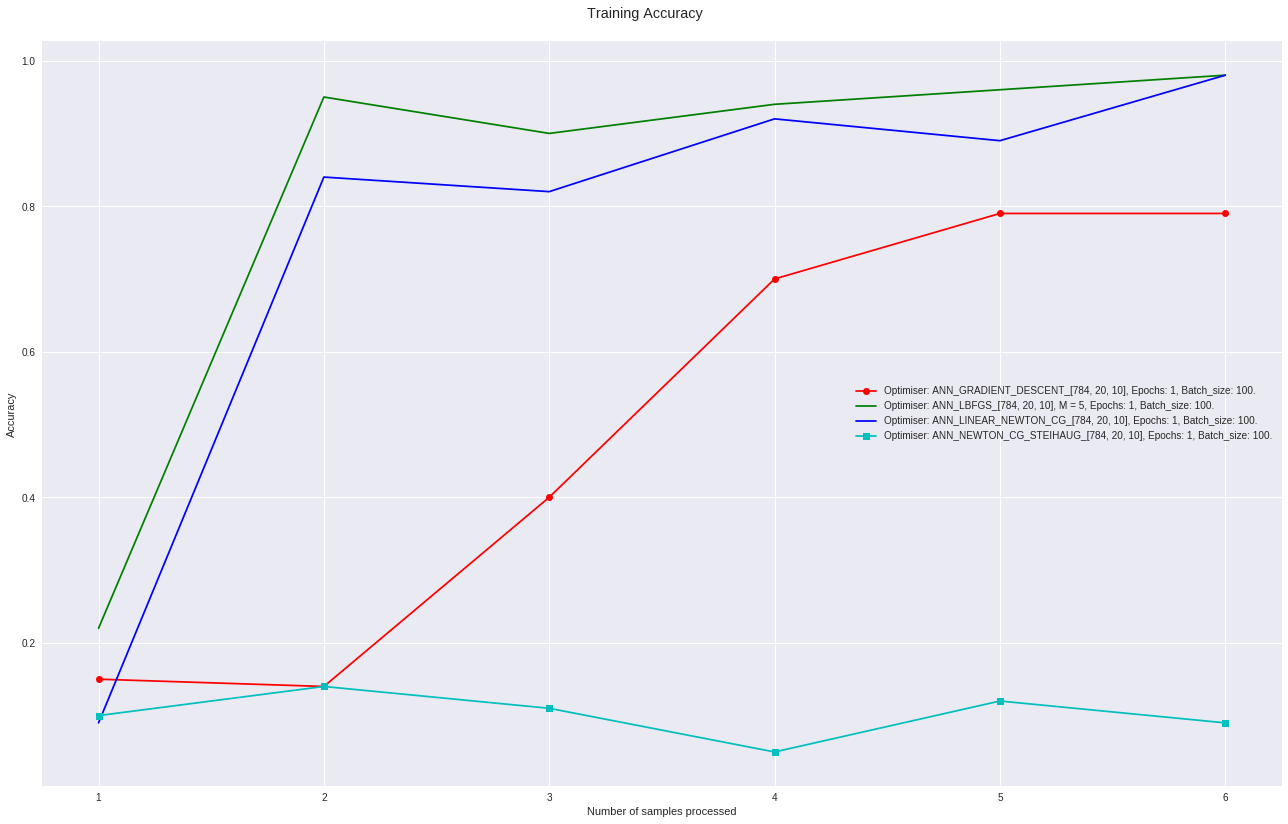

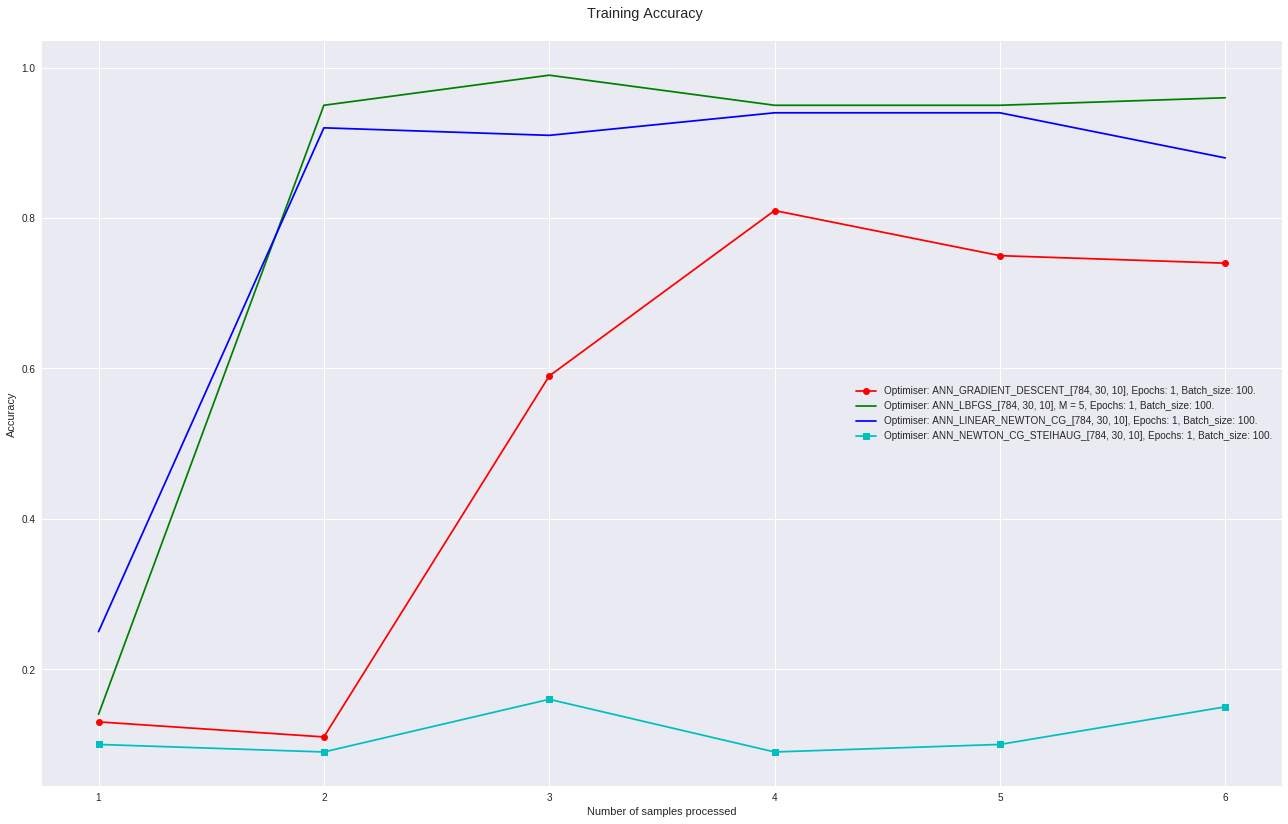

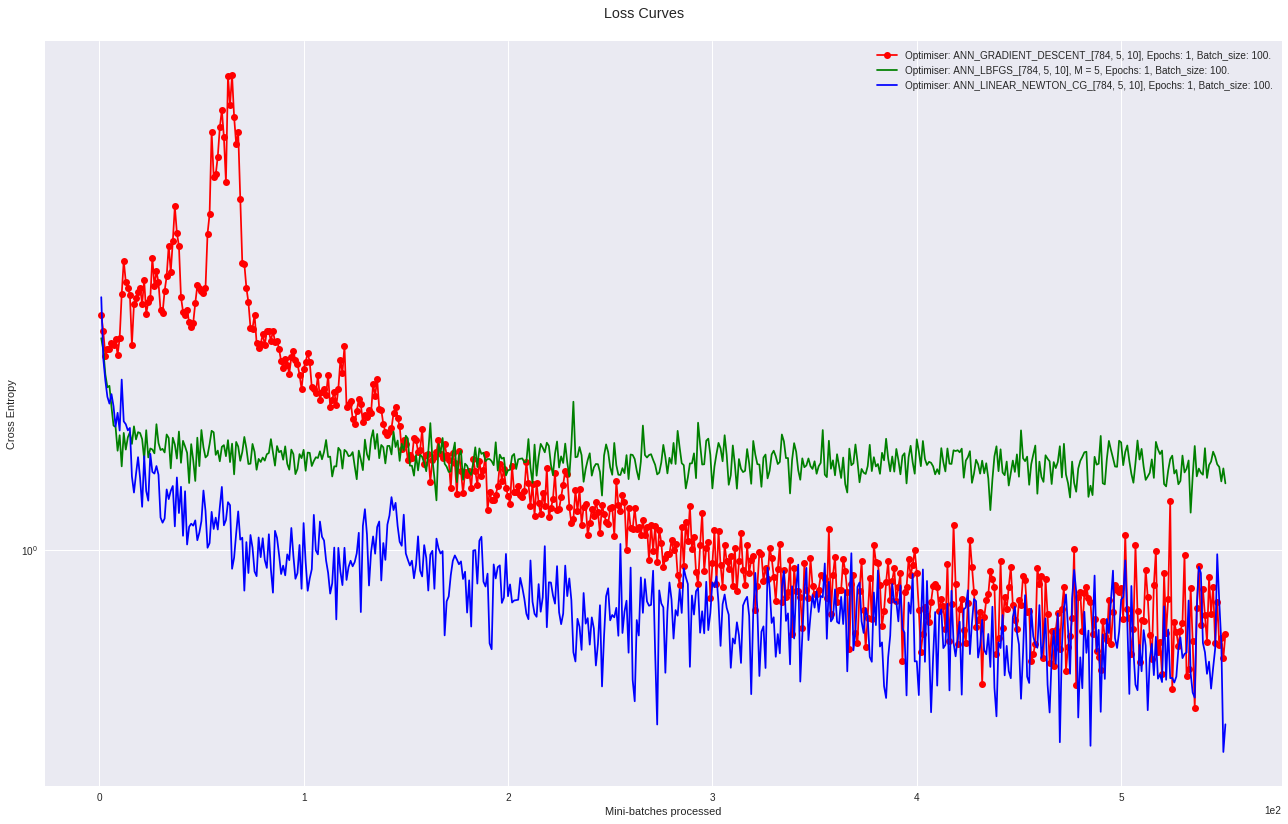

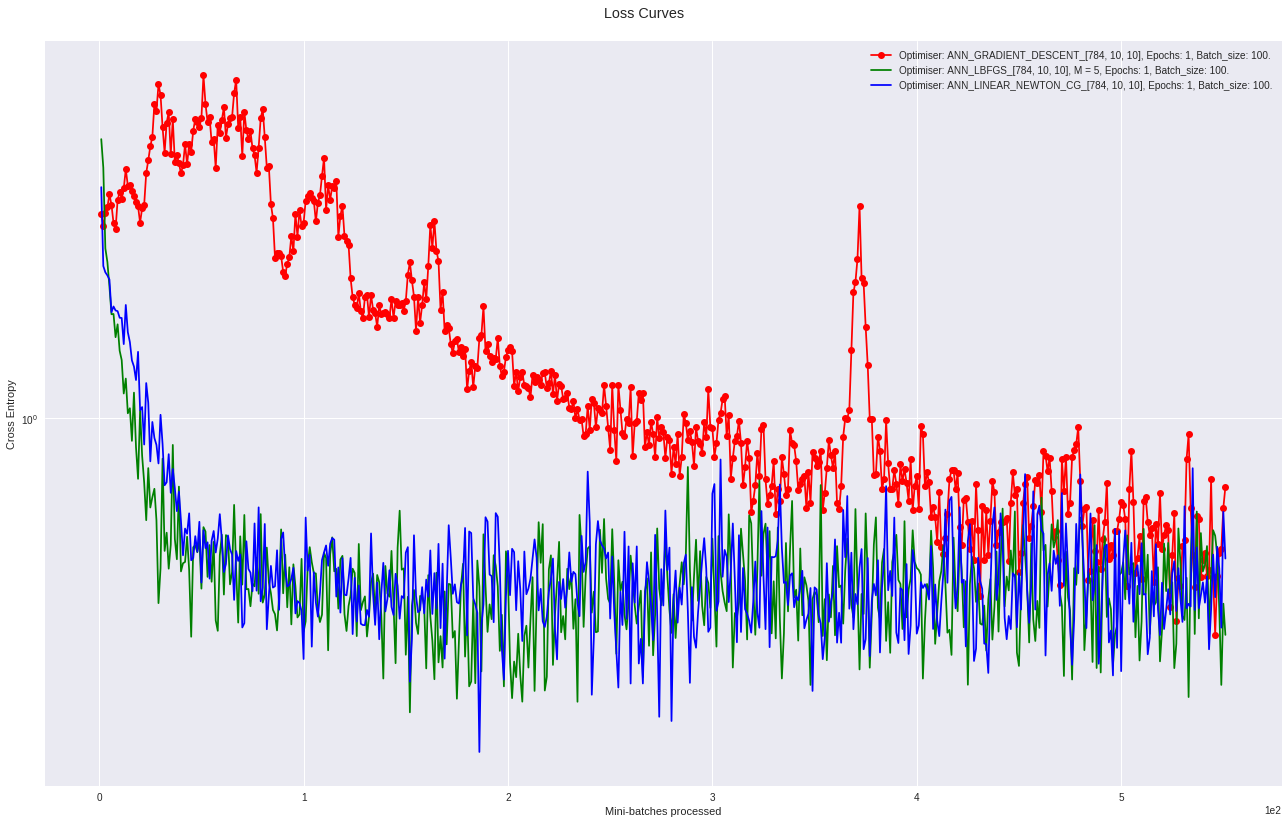

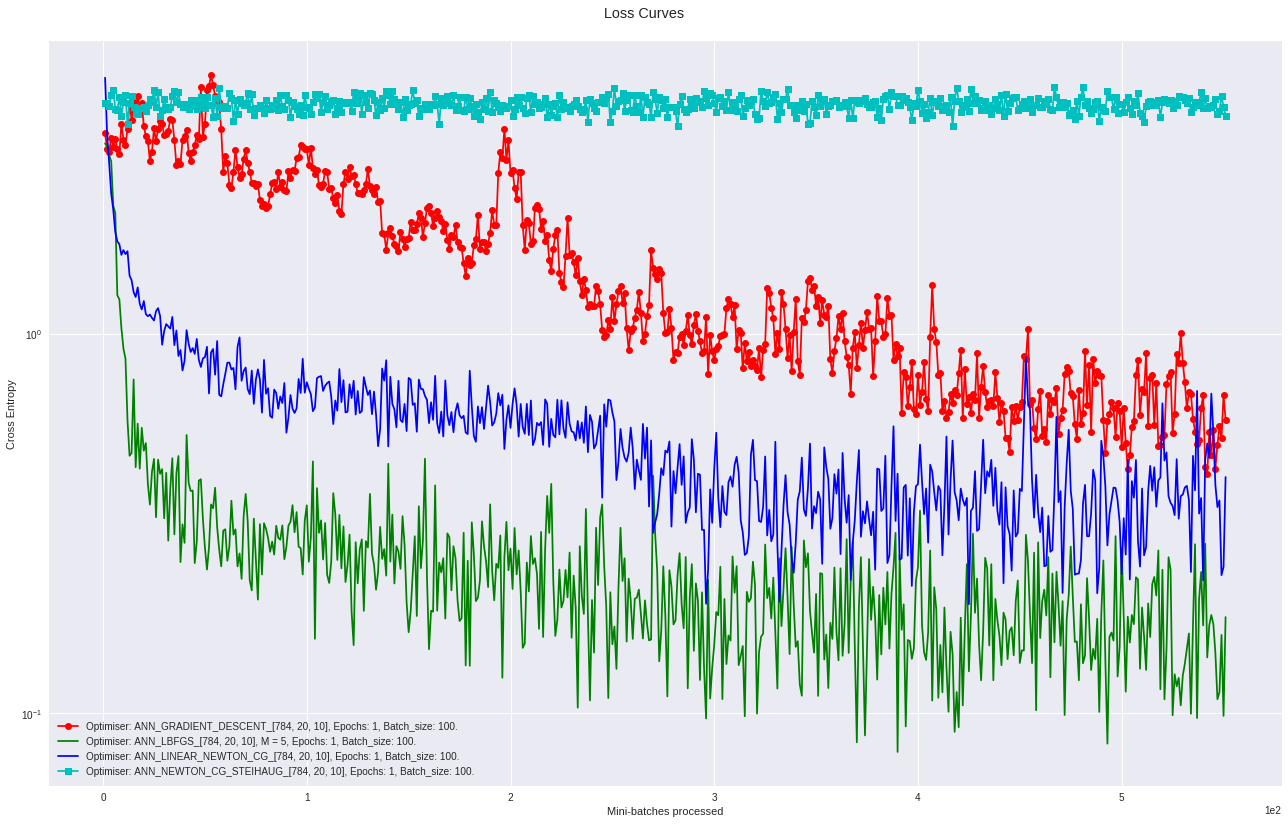

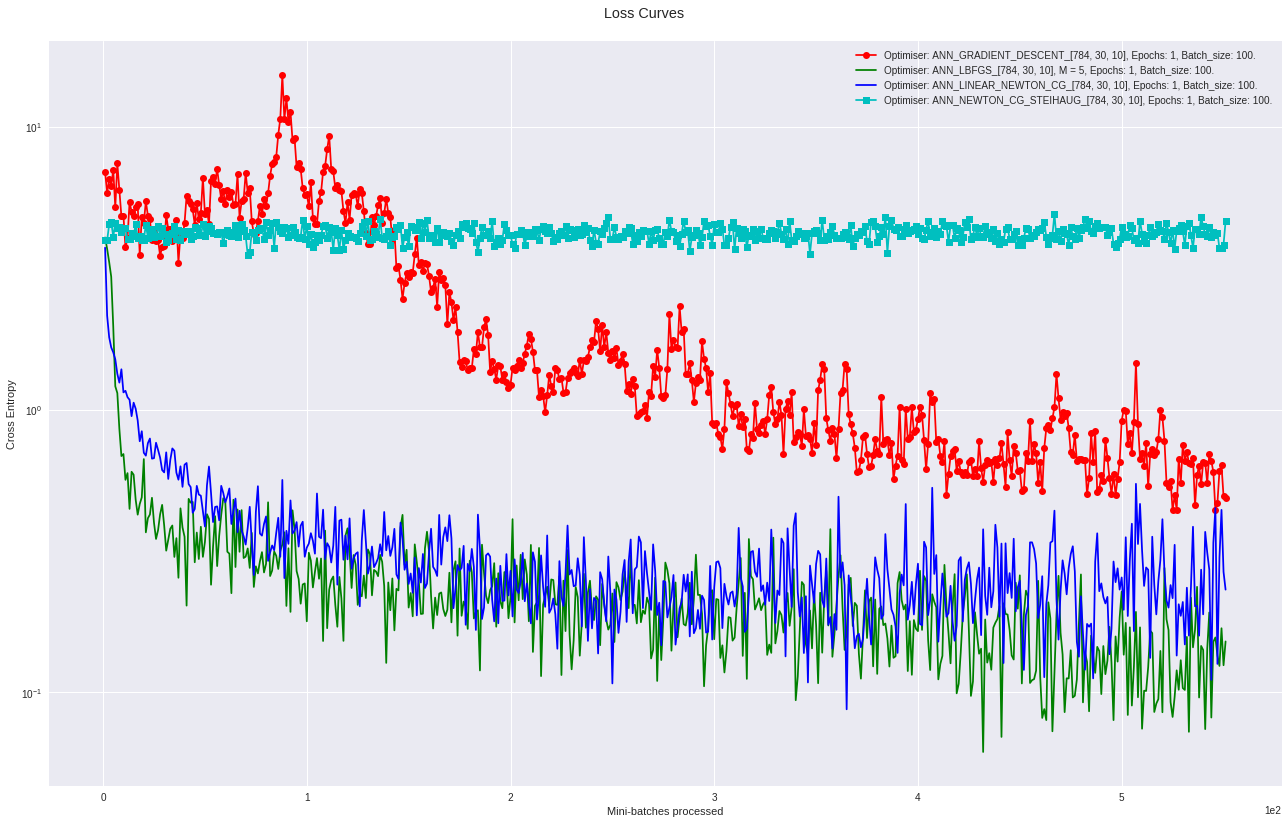

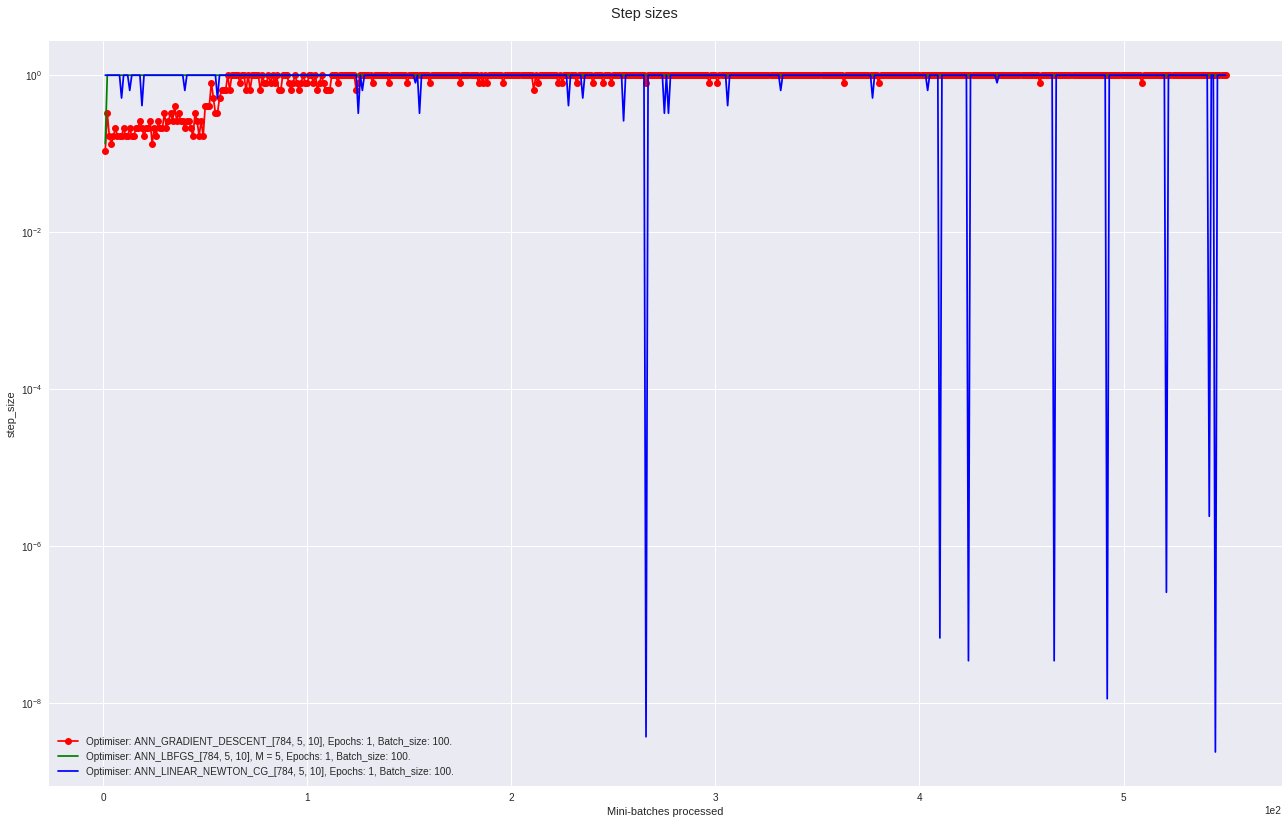

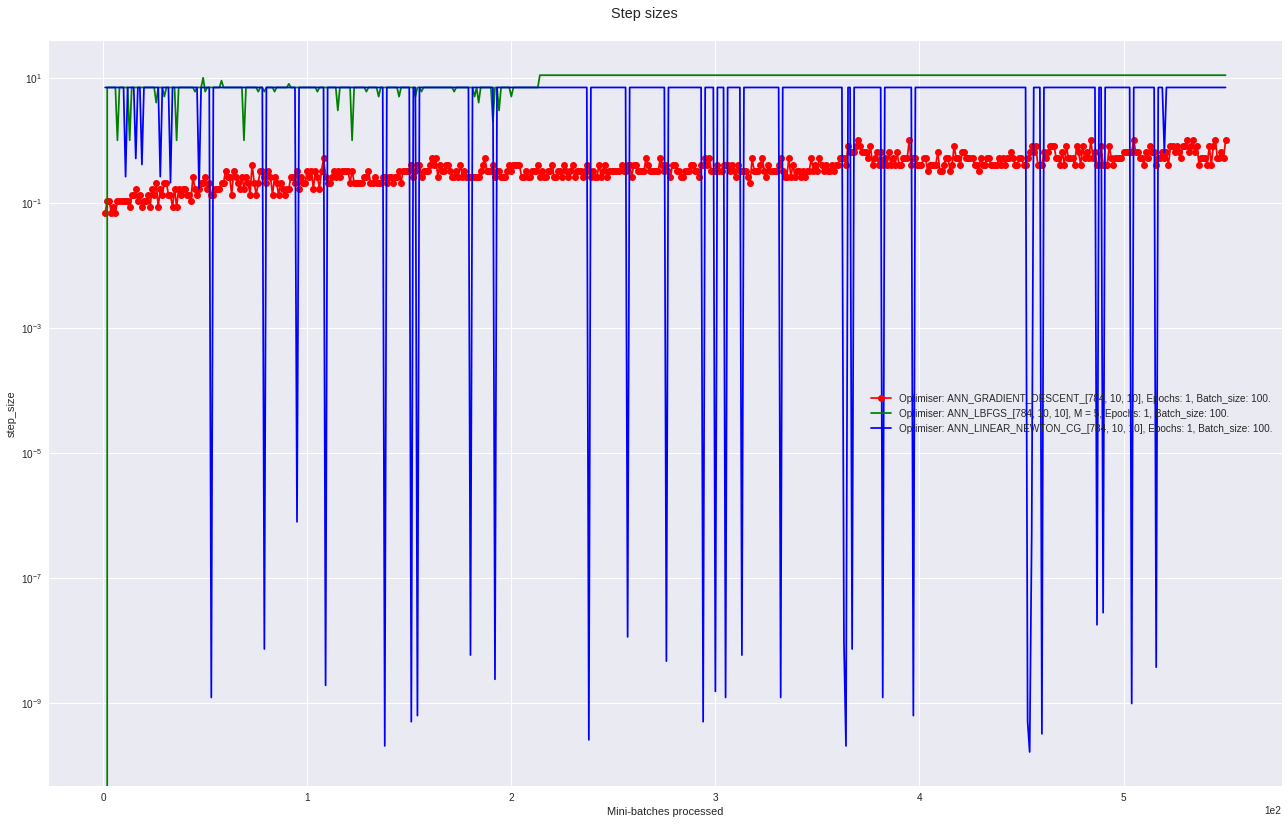

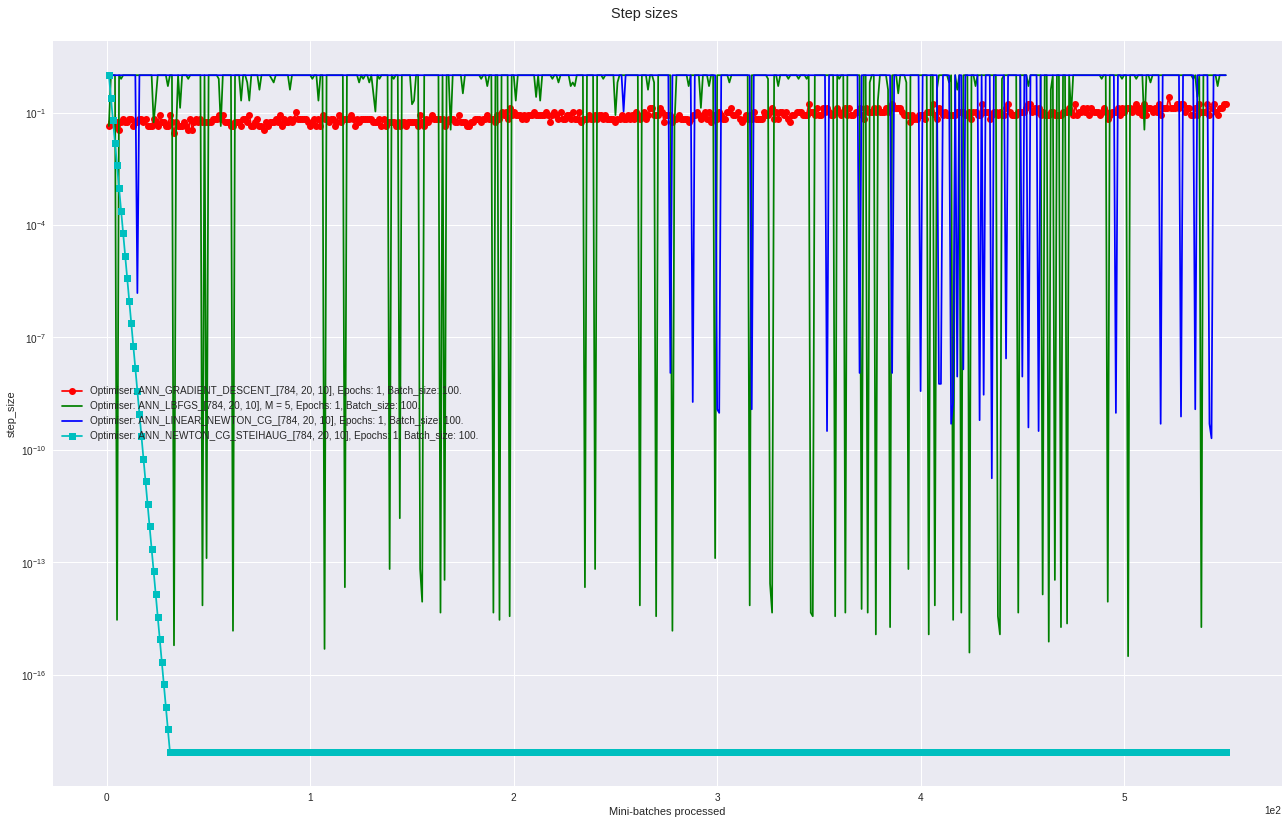

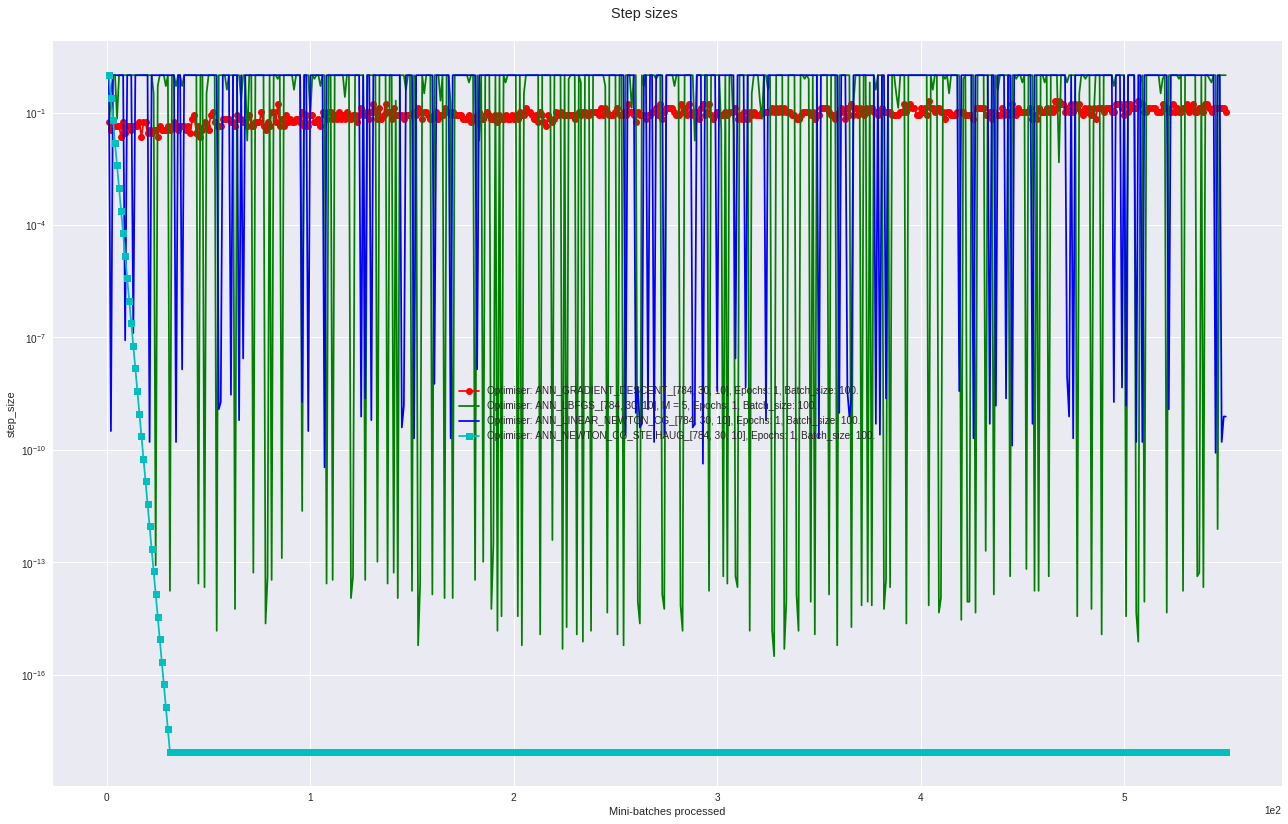

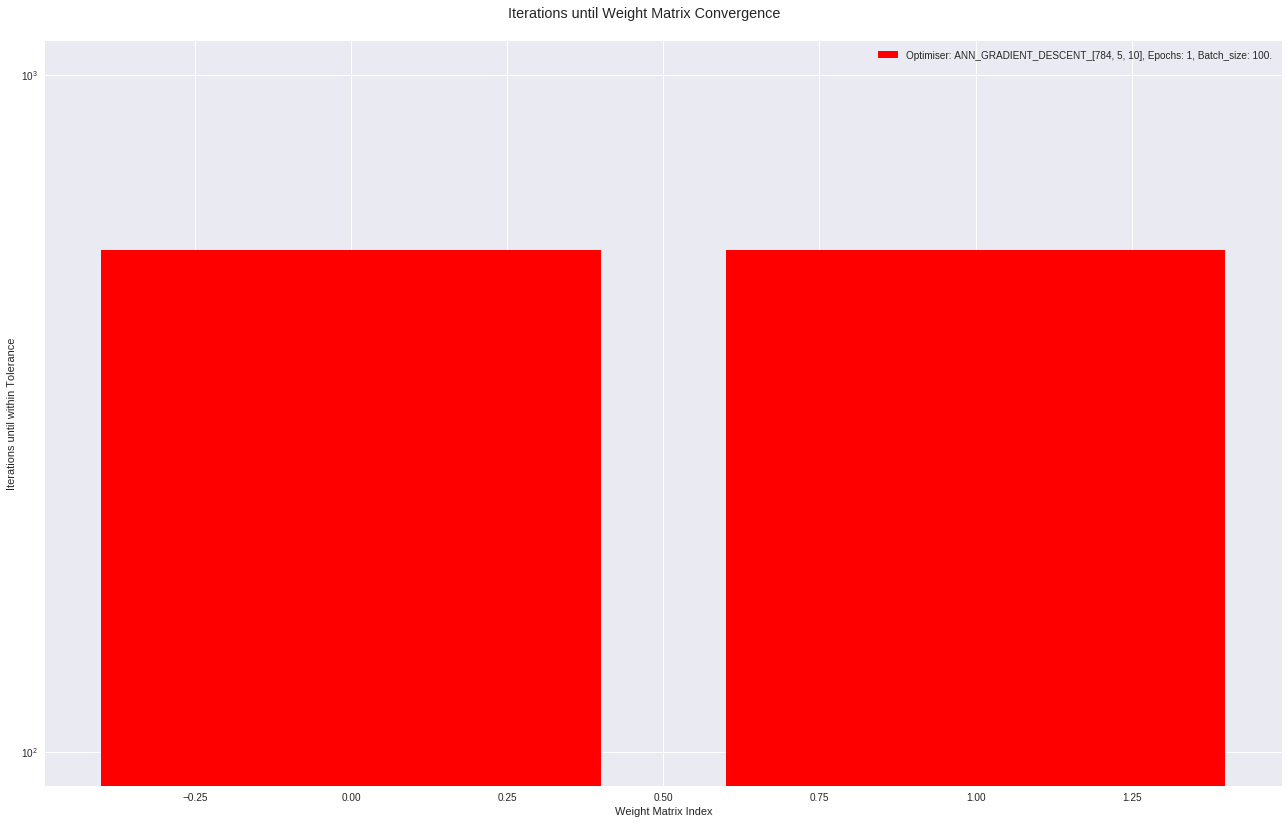

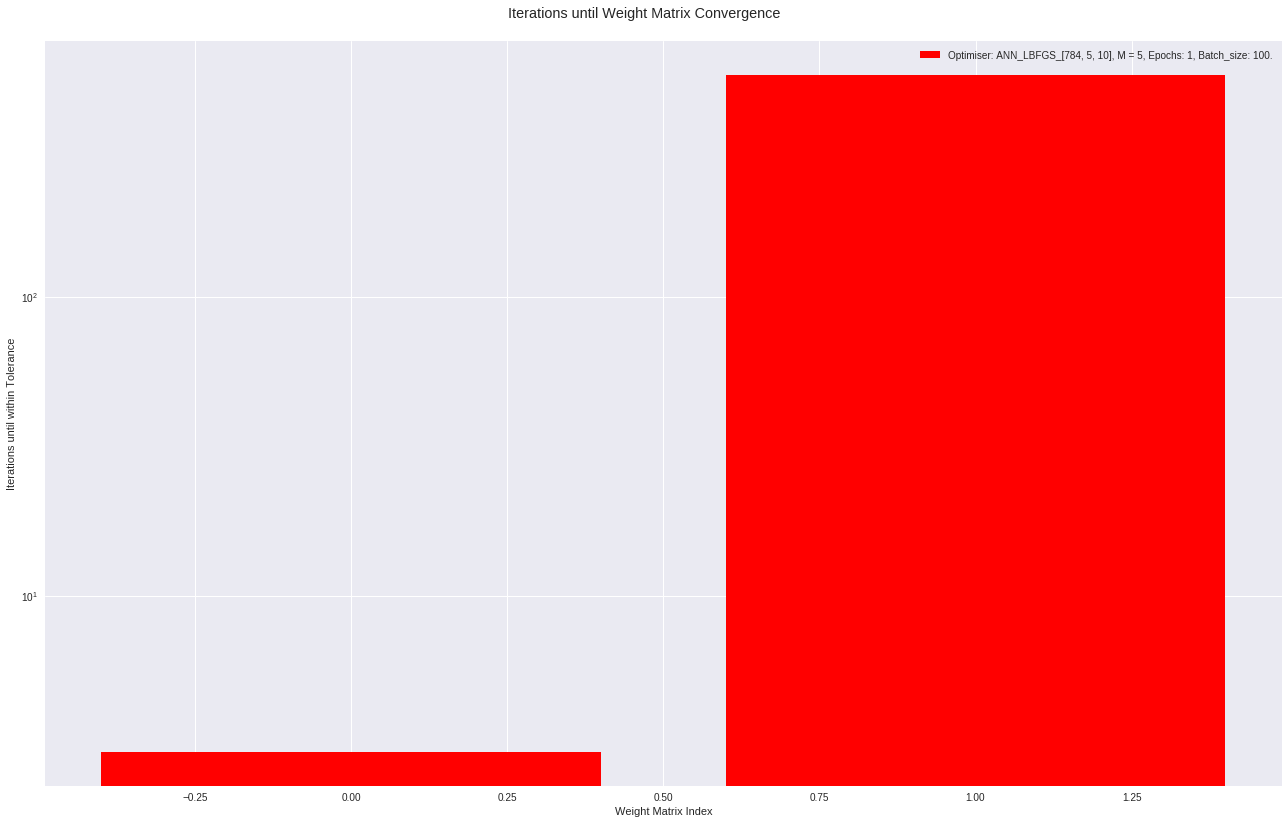

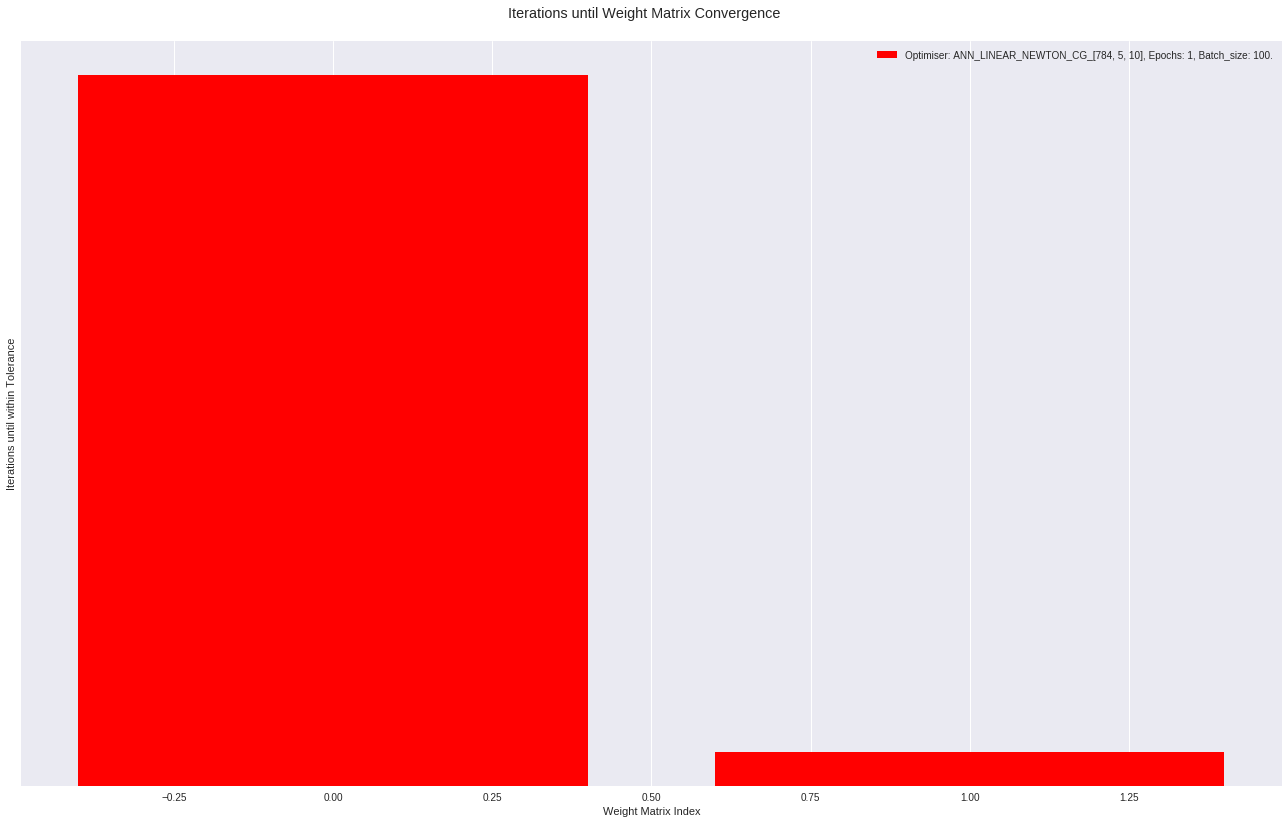

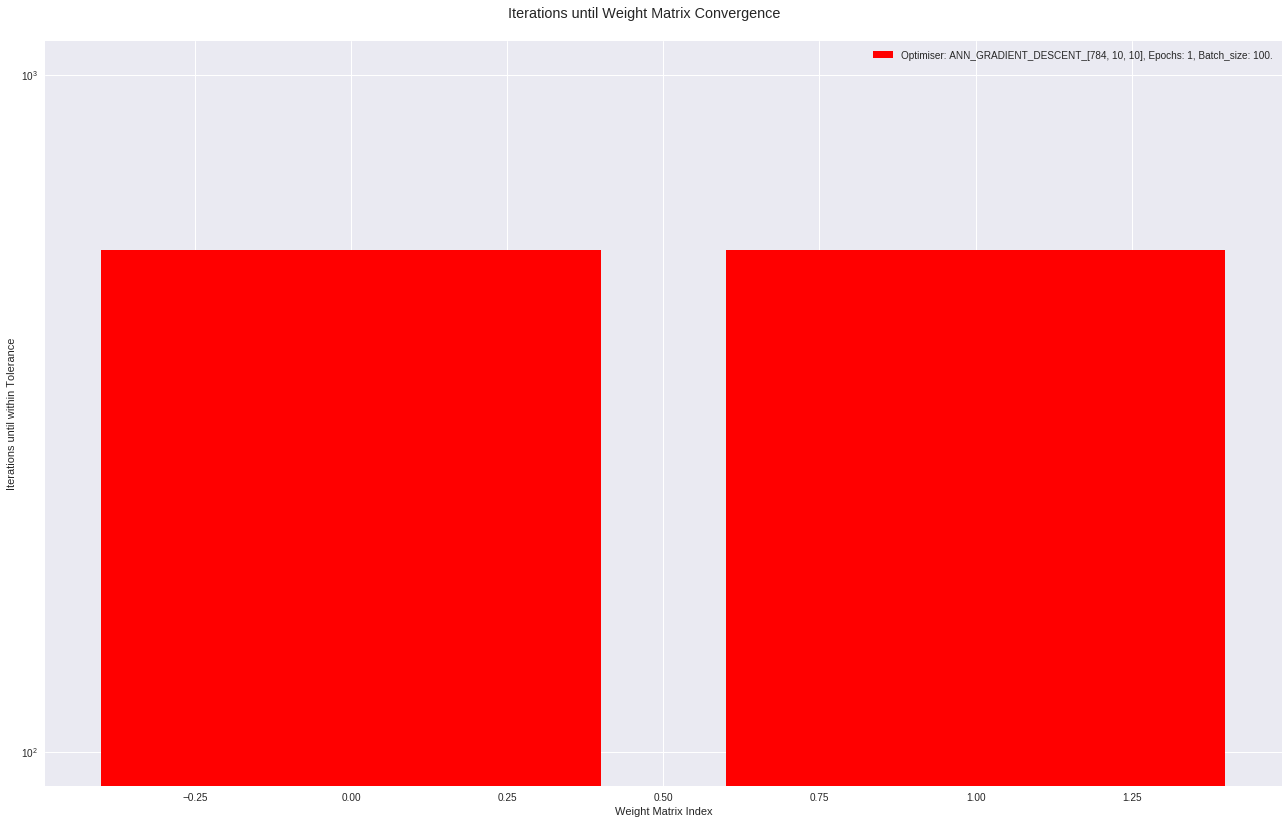

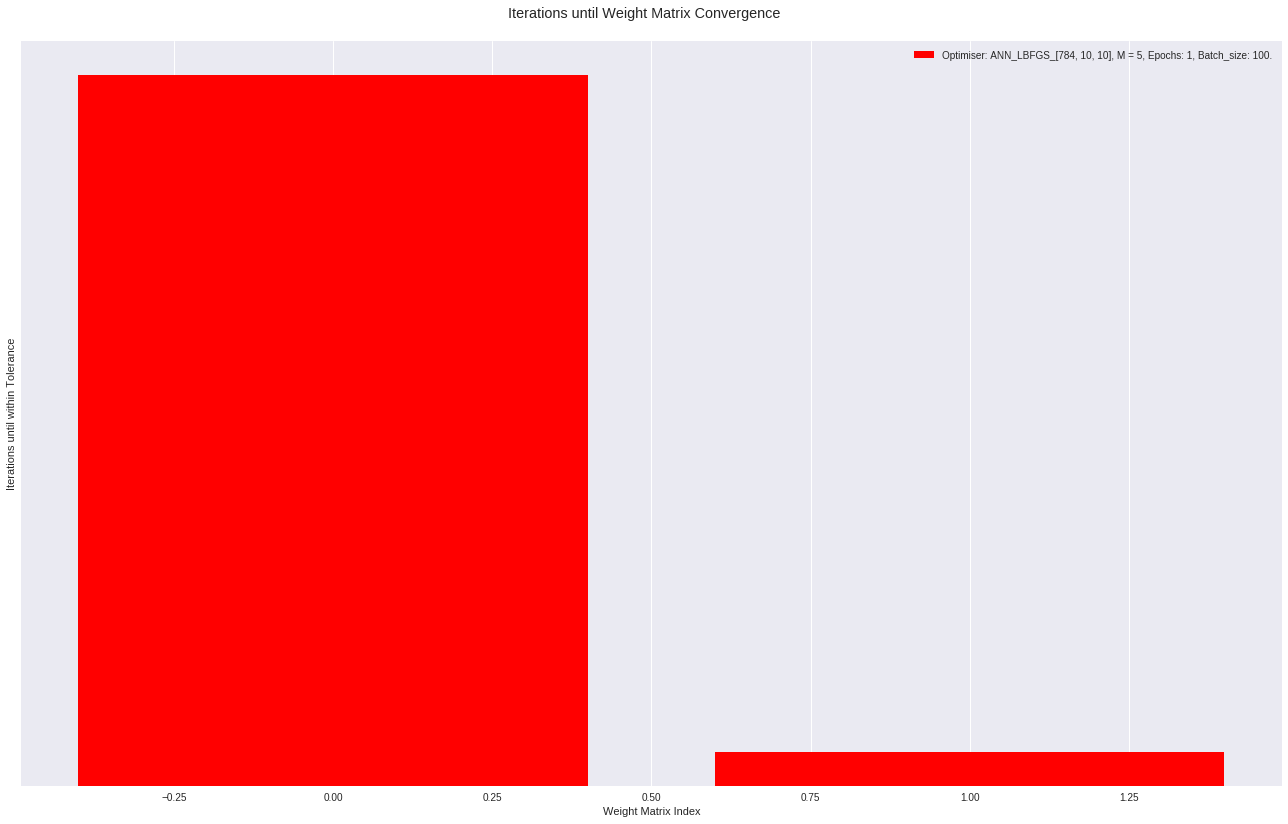

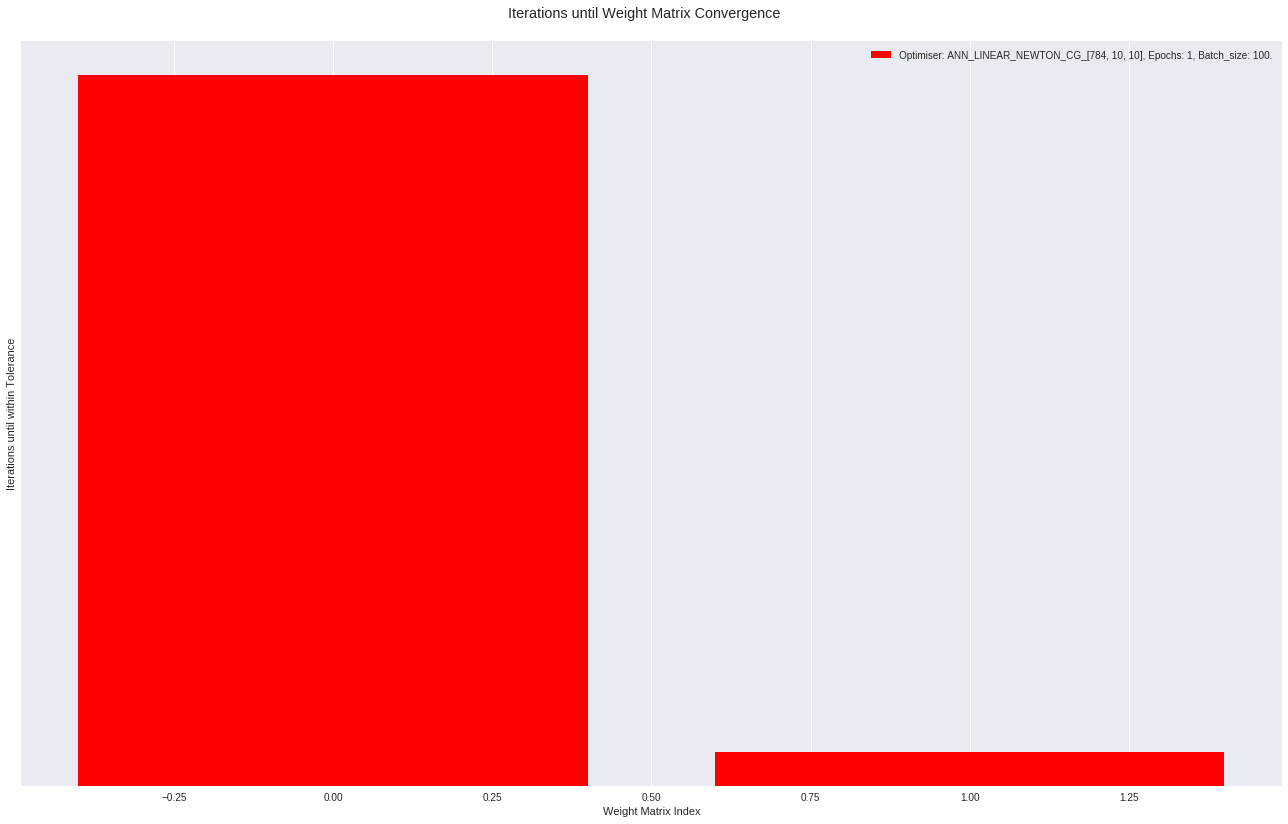

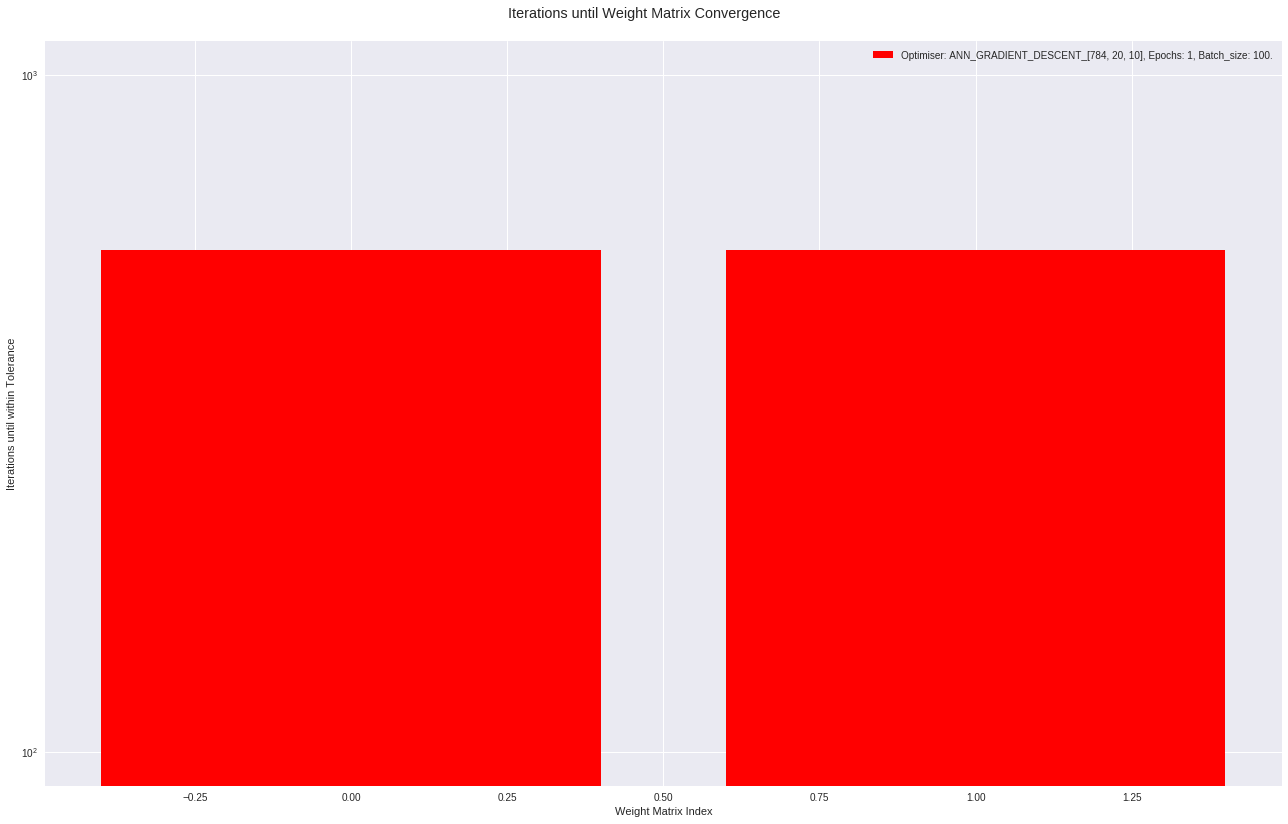

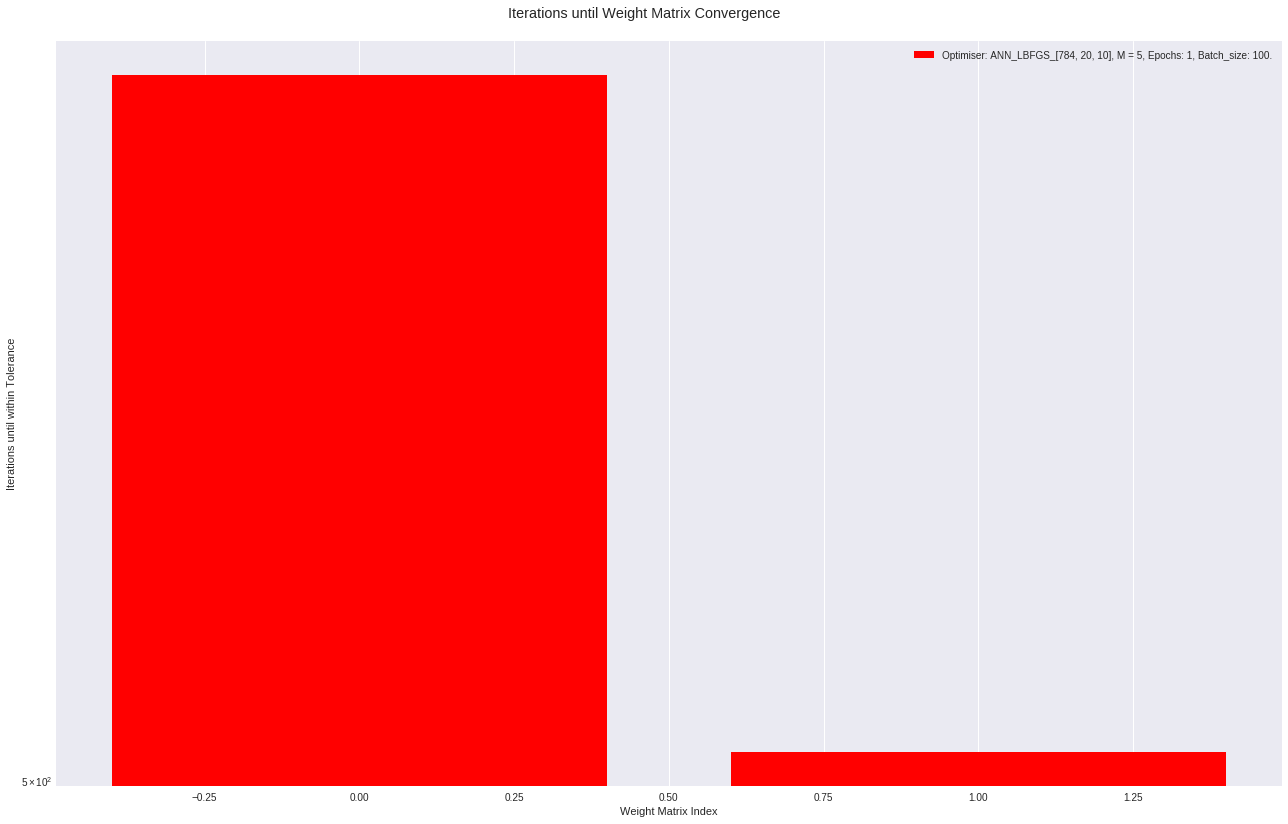

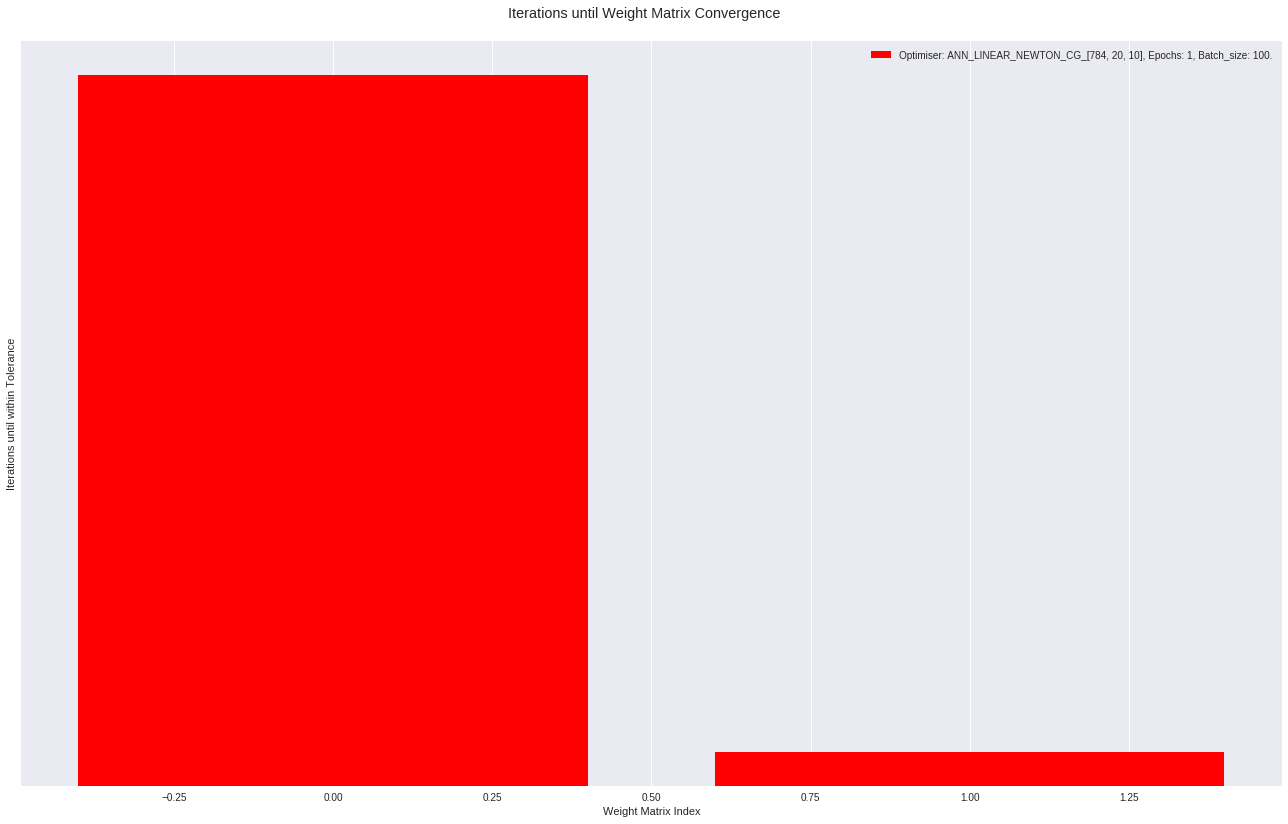

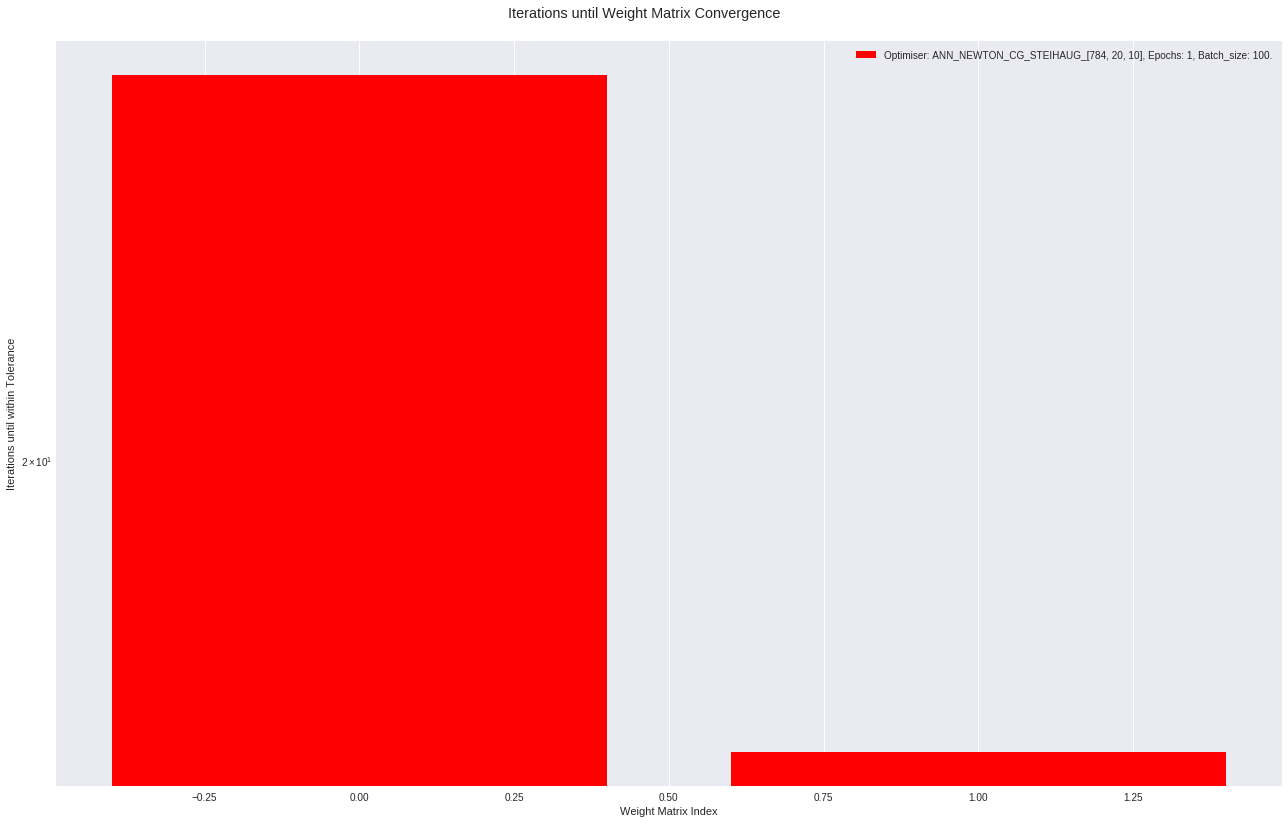

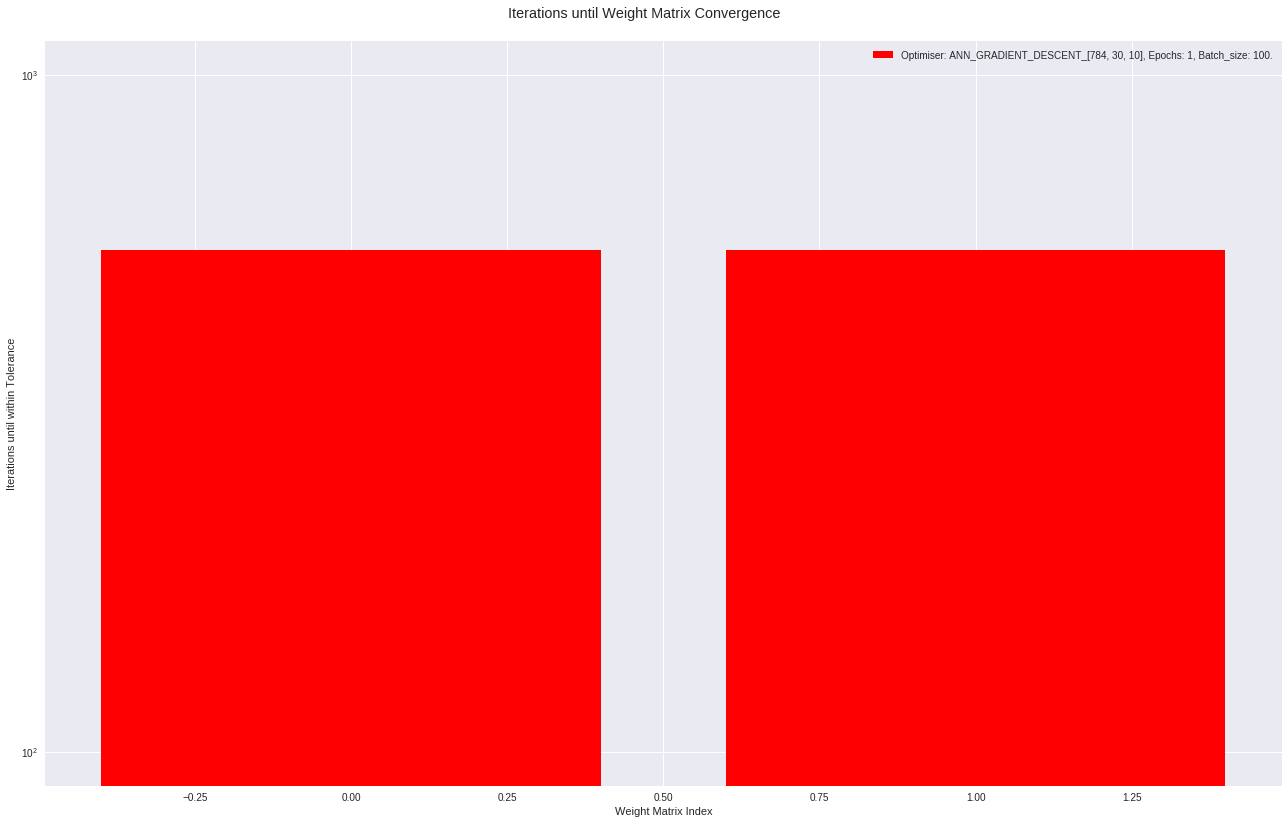

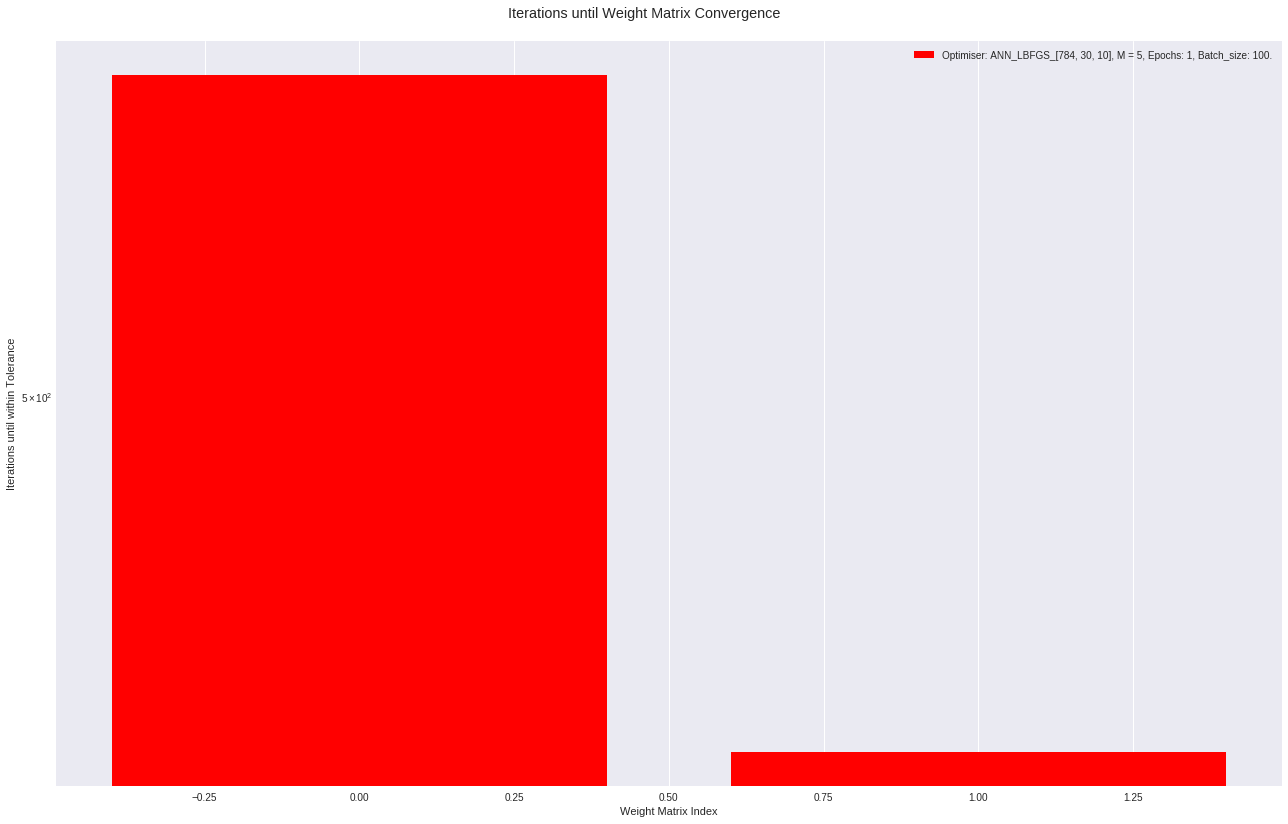

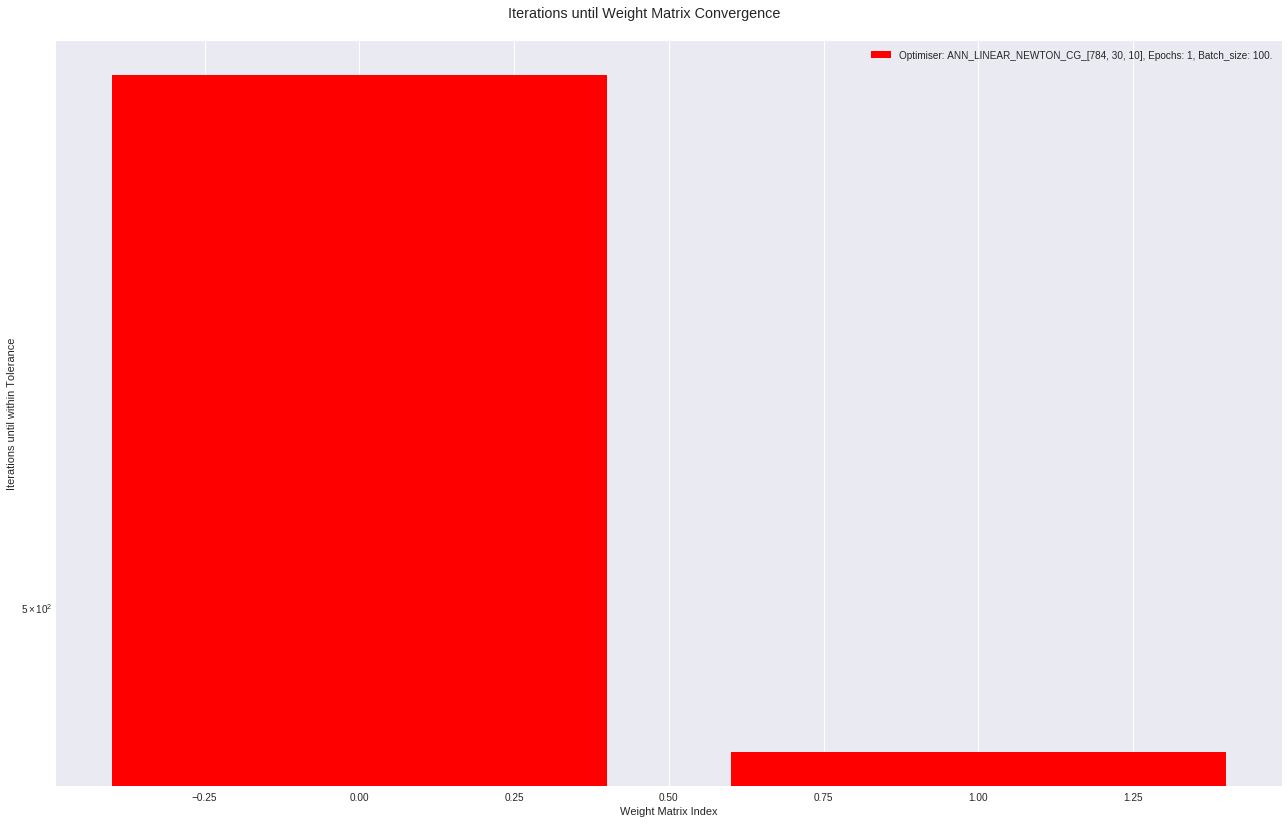

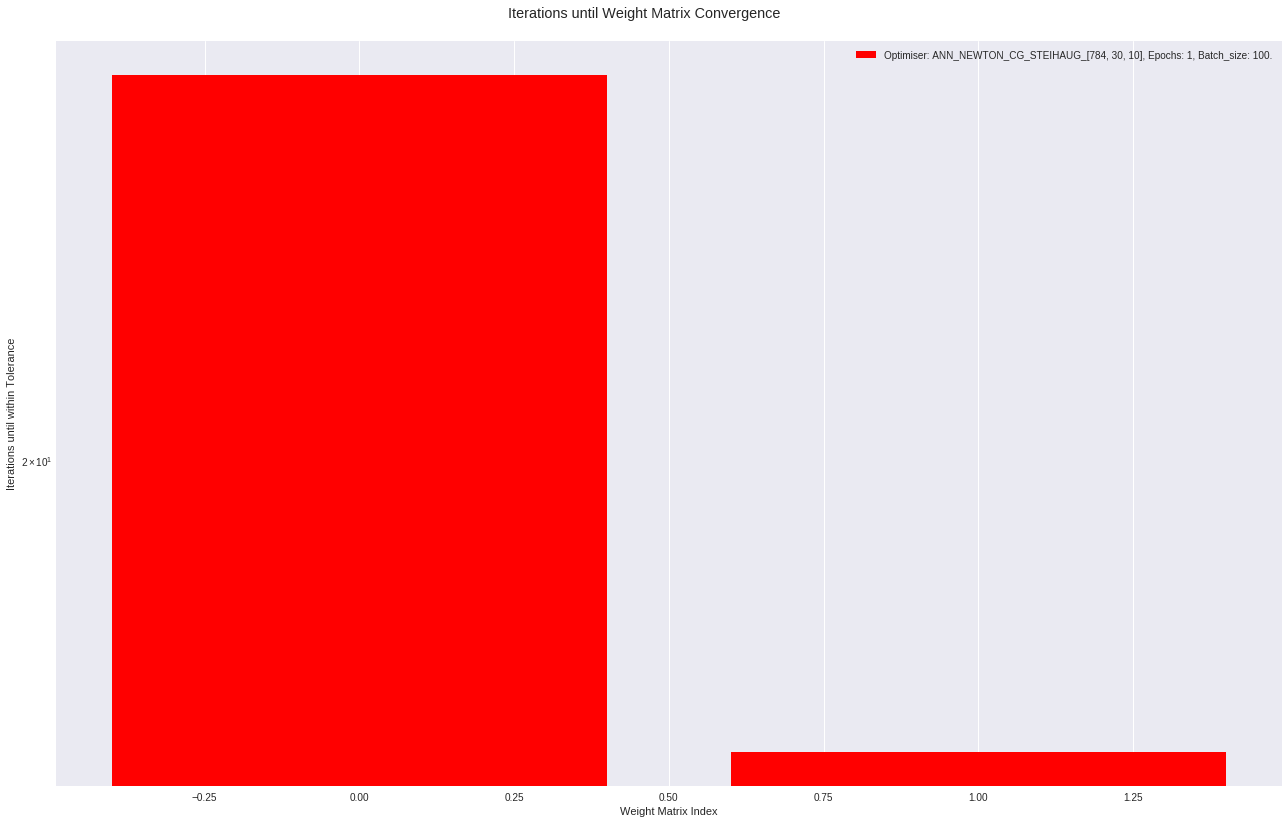

In [11]:
plot_learning_curves(experiment_results)
plot_loss(experiment_results)
plot_step(experiment_results)
plot_toleranceConverge(experiment_results)